## Table of contents:

1. [Importing libraries](#Imports)
2. [Data Cleaning](#Cleaning)
3. [Research](#Research)
4. [First EDA without Target Feature](#FirstEDA)
5. [Loading data with Target](#loading)

### Power Output
6. [EDA Power Output](#power)
7. [Feature Creation](#Engineering)
8. [Splitting Data as Time Series - Final results](#Final)
9. [Sensitivity Analysis](#sensitivity_analysis)
10. [Recursive Feature Elimination Cross Validation](#rfecv)
11. [Description of New Metrics](#desciptionofnewmetrics)
12. [Modelling](#Modelling)
13. [Models Tuning](#Tuning)
14. [Summary and Conclusions](#summary_power)

### Efficiency
15. [EDA for Efficiency](#eff)
16. [Log Transform for Solar Irradiance](#logt)
17. [Outlier detection and removal](#outlier)
18. [Modelling for Efficiency](#model_eff)
19. [Model Tuning for Efficiency](#model_tun)
20. [Summary and Conclusions for Efficiency](#summary_eff)

<a name="Imports"></a>
## 1. Imports

In [ ]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import pandas as pd
import numpy as np
from scipy import stats
import math

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.tree import plot_tree

import os
import time

# Feature Selection
from sklearn.feature_selection import RFECV

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError

import keras_tuner as kt

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [ ]:
country_names = ['Antartica', 'Australia', 'Beijing', 'Berlin', 'Brasilia', 'Pretoria', 'Washington']
cols_irradiation = ['Clear sky GHI']
cols_meteorology = [' Date', 'Temperature', 'Wind speed']

# Dataset Preparation
Preparing two datasets into one for each country with relevant features

In [ ]:
# On investigating the file I noticed that the data has to be pre-processed as the explanatory rows will affect how pandas will
# read it
with open('meteorology/'+country_names[0]+'.csv', 'r') as f:
    print(f.read())

## Testing Idea

In [ ]:
# all '# text' rows except the last which contains the columns names should be removed 
open_file = open('irradiation/'+country_names[0]+'.csv', 'r')
read_file = open_file.read()

# The idea is that splitting by \n# will leave what I require as the last value
new_read = read_file.split('\n#')

In [ ]:
# keeping just the last value of that list
clean = new_read[-1]

# writing into another csv file
write_to_file = open('clean.csv', 'w')
write_to_file.write(clean)

write_to_file.close()


In [ ]:
test = pd.read_csv('clean.csv', sep = ';')

In [ ]:
# Creating a cleaner function

def cleaner(file_path, met_or_irr = 'met'):
    
    # opening and reading files
    open_file = open(file_path, 'r')
    read_file = open_file.read()

    # splitting by '\n#'
    new_read = read_file.split('\n#')
    
    # keeping just the last value of that list
    clean = new_read[-1]

    # writing into another csv file
    if met_or_irr == 'met':
        write_to_file = open('clean_met.csv', 'w')
        write_to_file.write(clean)
    else:
        write_to_file = open('clean_irr.csv', 'w')
        write_to_file.write(clean)
    write_to_file.close()


In [ ]:
# With the above test, it works fine. Looping all files and extracting required columns

for name in country_names:
    # first step is to clean both irradiation and meteorology files
    print('Cleaning datasets for {}======='.format(name))
    irrad = cleaner('irradiation/'+name+'.csv', met_or_irr= 'irr')
    meteor = cleaner('meteorology/'+name+'.csv',)
    
    # Next I read both saved files
    print('Reading Cleaned datasets and selecting all columns for {}======='.format(name))
    irrad_set = pd.read_csv('clean_irr.csv', sep = ';')
    meteor_set = pd.read_csv('clean_met.csv', sep = ';')
    
    print('no of rows in both sets is {} and {}'.format(len(irrad_set), len(meteor_set)))
    
    # dividing Irradiation columns by 8
    irrad_set = round(irrad_set.drop(' Observation period', axis= 1)/8, 4)
    
    # Concatenating both tables
    print('Joining tables to get extracted cols for {}======='.format(name))
    joined = pd.concat([meteor_set, irrad_set], axis = 1 )
    joined.drop('UT time', axis=1, inplace= True)
    #joined['Clear sky GHI'] = round(joined['Clear sky GHI']/12, 4)
    joined.rename({' Date':'Date'}, axis = 1, inplace = True)

    
    # Confirming data
    print('Confirming join for {}======='.format(name))
    display(joined)

    # downloading into a folder called 'extracted_files_raw'
    print('Saving tables to get extracted cols for {}======='.format(name))    
    joined.to_csv('recent_extracted_files_raw/'+name+'.csv', index= False)
    
    # Removing new created files so they can be created afresh for next country
    print('Removing both newly created files after {}======='.format(name))
    print('\n')
    os.remove('clean_irr.csv')
    os.remove('clean_met.csv')


In [ ]:
# Some other tweak

for name in country_names:
    # first step is to clean both irradiation and meteorology files
    print('Cleaning datasets for {}======='.format(name))
    irrad = cleaner('irradiation/'+name+'.csv', met_or_irr= 'irr')
    meteor = cleaner('meteorology/'+name+'.csv',)
    
    # Next I read both saved files
    print('Reading Cleaned datasets and selecting all columns for {}======='.format(name))
    irrad_set = pd.read_csv('clean_irr.csv', sep = ';')[cols_irradiation]
    meteor_set = pd.read_csv('clean_met.csv', sep = ';')[cols_meteorology]
    
    print('no of rows in both sets is {} and {}'.format(len(irrad_set), len(meteor_set)))
    
    # Concatenating both tables
    print('Joining tables to get extracted cols for {}======='.format(name))
    joined = pd.concat([meteor_set, irrad_set], axis = 1 )
    joined['Clear sky GHI'] = round(joined['Clear sky GHI']/8, 4)
    joined.rename({' Date':'Date'}, axis = 1, inplace = True)
    
    # Confirming data
    print('Confirming join for {}======='.format(name))
    display(joined)

    print('max_value for {} is {}'.format(name, max(joined['Clear sky GHI'])))
    print('\n')
    
    # downloading into a folder called 'needed'
    print('Saving tables to get extracted cols for {}======='.format(name))    
    joined.to_csv('recent_needed/'+name+'.csv', index= False)
    
    # Removing new created files so they can be created afresh for next country
    print('Removing both newly created files after {}======='.format(name))
    print('\n')
    os.remove('clean_irr.csv')
    os.remove('clean_met.csv')


# Combining 
Combining all countries into one dataset.

In [ ]:
# combining all countries with a column to indicate country into one data set
country_df = pd.read_csv('recent_needed/'+country_names[0]+'.csv')
country_df['Country'] = [country_names[0]]*len(country_df)

for n in range(1, (len(country_names))):
    
    df = pd.read_csv('recent_needed/'+country_names[n]+'.csv', parse_dates= ['Date'])
    df['Country'] = [country_names[n]]*len(df)
    
    # printing out all country names to confirm the code does the right thing
    print(n, country_names[n], df.shape)
    country_df = pd.concat([country_df, df], axis = 0)

<a name="Cleaning"></a>
## 2. Data Cleaning

In [ ]:
country_df.reset_index(drop=True, inplace= True)

#### Data Type check

In [ ]:
country_df.info()

In [ ]:
# Date should be in datetime format.
country_df['Date'] = pd.to_datetime(country_df['Date'])

In [ ]:
country_df.info()

#### Missing data check

In [ ]:
country_df.isna().sum().sum()

The dataset has no missing values

#### Duplicates Check

In [ ]:
dup = country_df.duplicated()

In [ ]:
country_df[dup]

There are no duplicate entries in the dataset

<a name="Research"></a>
## 3. RESEARCH

**What is Irradiance ?**

Solar irradiance is the power per unit area (surface power density) received from the Sun in the form of electromagnetic radiation in the wavelength range of the measuring instrument. Solar irradiance is measured in watts per square metre (W/m2) in SI units.

Solar irradiance is often integrated over a given time period in order to report the radiant energy emitted into the surrounding environment (joule per square metre, J/m2) during that time period. This integrated solar irradiance is called solar irradiation, solar exposure, solar insolation, or insolation.

Irradiance may be measured in space or at the Earth's surface after atmospheric absorption and scattering. Irradiance in space is a function of distance from the Sun, the solar cycle, and cross-cycle changes. **Irradiance on the Earth's surface additionally depends on the tilt of the measuring surface, the height of the Sun above the horizon, and atmospheric conditions.** 
The solar irradiance received by a particular location or body of water depends on **the elevation above sea level, the angle of the sun (due to latitude, season and time of day) and scattering elements such as clouds** 

The study and measurement of solar irradiance have several important applications, including the prediction of energy generation from solar power plants, the heating and cooling loads of buildings, climate modeling and weather forecasting, passive daytime radiative cooling applications, and space travel.

**What is a clear sky condition ?**

A clear sky condition is defined generally as the absence of visible clouds across the entire sky dome, and clear sky irradiance is the irradiance (e.g., GHI) occurring during these conditions. A more precise definition of clear sky irradiance relies to some extent on judgment.

Clear sky irradiance, in particular, the global horizontal irradiance (GHI), provides information about the maximum possible solar energy resource available at the location under consideration, which is crucial in estimating or forecasting the performance of solar energy technologies.

Direct irradiance is the part of the solar irradiance that directly reaches a surface; diffuse irradiance is the part that is scattered by the atmosphere; global irradiance is the sum of both diffuse and direct components reaching the same surface.


<a name="FirstEDA"></a>
## 4. First EDA without Target Feature

In [ ]:
## Let's see what range the data covers
print('Minimum and maximum date for each country in the dataset are') 
(country_df.groupby('Country')['Date'].agg([min, max]))

In [ ]:
country_df['Country'].value_counts()

The dataset covers exactly 3 years across each country.

#### Clear sky GHI

From research, the GHI values the global horizontal irradiance (GHI), provides information about the maximum possible solar energy resource available at the location. So, it's an important feature.

In [ ]:
# Summary Statistics of the Clear sky GHI values across countries
def twenty_fifth(data):
    return np.percentile(data, 25)
def seventy_fifth(data):
    return np.percentile(data, 75)

country_df.groupby('Country')['Clear sky GHI'].agg([min, max, twenty_fifth, seventy_fifth, np.mean, np.std]).sort_values('mean')

In [ ]:
# Bar plot of the Clear sky GHI which will show the average for the GHI
palette = {'Antartica':'b', 'Australia':'orange', 'Beijing':'r', 'Berlin':'dimgrey', 'Brasilia':'purple', 'Pretoria':'green',
           'Washington':'violet'}
palette1 = {'Antartica':'b', 'Australia':'b', 'Beijing':'b', 'Berlin':'b', 'Brasilia':'b', 'Pretoria':'b',
           'Washington':'b'}

order = country_df.groupby('Country', as_index= False)['Clear sky GHI'].mean().sort_values('Clear sky GHI', ascending= False)
plt.figure(figsize= (12,7))
ax = sns.barplot(x= 'Country', y='Clear sky GHI', data = country_df, palette= palette1, ci= 0, 
            order=order.Country)
ax.bar_label(ax.containers[0])
plt.ylabel('Clear sky GHI (w/m²)', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.title('Average Clear sky GHI across countries', fontsize = 16)
#plt.savefig('Average_Clear_sky_GHI.jpg', dpi= 300)

In [ ]:
# distribution of Clear sky GHI values.

plt.figure(figsize= (12,7))
sns.boxplot(x= 'Country', y='Clear sky GHI', data = country_df, palette= palette, order = order.Country)
plt.ylabel('Clear sky GHI (w/m²)', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.title('Distribution of Clear sky GHI across Countries', fontsize = 16)
plt.grid()
#plt.savefig('Boxplot_Clear_sky_GHI.jpg', dpi= 300)

In [ ]:
plt.figure(figsize= (12,7))
sns.swarmplot(x='Country', y='Clear sky GHI', data = country_df, palette= palette, size = 2, order = order.Country)
plt.ylabel('Clear sky GHI (w/m²)', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.title('Swarm Distribution of Clear sky GHI across Countries', fontsize = 16)
plt.show()
#plt.savefig('Swarmplot_Clear_sky_GHI.jpg', dpi= 300)

#### Temperature

In [ ]:
# Converting to degree celcius
country_df['Temperature'] = country_df['Temperature']-273

In [ ]:
# Below, we see the temperature seasonality across countries
plt.figure(figsize= (15,10))
sns.lineplot(x='Date', y='Temperature', data = country_df, hue= 'Country', palette= palette)

plt.ylabel('Temperature(°c)', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Temperature Seasonality across Countries', fontsize = 16)
sns.despine()
plt.grid()
#plt.savefig('Temperature_seasonality.jpg', dpi= 300)


In [ ]:
# resampling into months to create a better plot

country_resamp = pd.read_csv('recent_needed/'+country_names[0]+'.csv')
country_resamp['Date'] = pd.to_datetime(country_resamp['Date'])
country_resamp.set_index('Date', inplace = True)
country_resamp = country_resamp.resample('MS')['Temperature', 'Clear sky GHI'].mean()
country_resamp = pd.DataFrame(country_resamp)
country_resamp['Country'] = [country_names[0]]*len(country_resamp)

for a in range(1, (len(country_names))):
    
    df = pd.read_csv('recent_needed/'+country_names[a]+'.csv', parse_dates= ['Date'])
    df.set_index('Date', inplace = True)
    df = df.resample('MS')['Temperature', 'Clear sky GHI'].mean()
    df = pd.DataFrame(df)
    df['Country'] = [country_names[a]]*len(df)
    
    # printing out all country names to confirm the code does the right thing
    print(a, country_names[a], df.shape)
    country_resamp = pd.concat([country_resamp, df], axis = 0)


In [ ]:
country_resamp = country_resamp.reset_index()
country_resamp['Temperature'] = country_resamp['Temperature']-273

In [ ]:
country_resamp

In [ ]:
plt.figure(figsize= (15,10))
sns.lineplot(x='Date', y='Temperature', data = country_resamp, hue= 'Country', palette= palette)
sns.scatterplot(x='Date', y='Temperature', data = country_resamp, hue= 'Country', palette= palette, legend= False)
sns.despine()
plt.ylabel('Temperature(°c)')
plt.xlabel('Date', fontsize = 12)
plt.title('Monthly Average Temperature Seasonality across Countries', fontsize = 16)
plt.grid()
#plt.savefig('Average_Temperature_seasonality.jpg', dpi= 300)

Observations from data
1. Antartica is a cold continent and as expected, we see a low temperature range. We notice a seasonality and see that we have the highest temperature towards the end of each year and beginning of the next from the graph. This is because Antarctica's summer is from October to February. 
2. Australia is the hottest continent and is usually hotter towards end of a year and beginning of next. Summer - the three hottest months December, January and February.
3. We notice a similar seasonality as in Australia and Antartica with Pretoria which is in Africa (The second hottest conitinent after Australia). The seasonality in Australia and Pretoria is the opposite of Washington, Berlin and Beijin as we notice Summer usually occurs from October to february in the former three and that period is winter for the latter three. 
4. Brasilia is the Second hottest country from the graph which is in South America the third Hottest continent in the world.
5. Washington, Berlin and Beijin have similar temperature seasonality. Which means Summer and other seasons occurs at around the same period. 

In [ ]:
# Summary statistics of the temperatures across the different countries
country_df.groupby('Country')['Temperature'].agg([min, max, np.mean]).sort_values('mean')

Rank from coldest to hottest from statistics and plots
1. Antartica
2. Beijing
3. Washington
4. Berlin
5. Pretoria
6. Brasilia
7. Australia

In [ ]:
# Temperature distribution in a box plot
plt.figure(figsize= (12,7))
sns.boxplot(x= 'Country', y='Temperature', data = country_df, palette= palette, order = order.Country)
sns.despine()
plt.ylabel('Temperature(°c)', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.title('Temperature distribution across Countries', fontsize = 16)
plt.grid()
#plt.savefig('Box_plot_Temperature.jpg', dpi= 300)

In [ ]:
# Seeing the temperature distributions in a swarm plot
plt.figure(figsize= (12,7))
sns.swarmplot(x='Country', y='Temperature', data = country_df, palette= palette, size = 2, order= order.Country)
sns.despine()
plt.ylabel('Temperature(°c)', fontsize = 12)
plt.xlabel('Country', fontsize = 12)
plt.title('Swarm Temperature distribution across Countries', fontsize = 16)
plt.grid()
#plt.savefig('Swarmplot_Temperature.jpg', dpi= 300)

We clearly see the differnce in temperature range across countries with this plot

#### Exploring relationship between Temperature and Clear Sky GHI

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Temperature', y='Clear sky GHI', data = country_df, hue= 'Country', palette = palette)
plt.xlabel('Temperature(°c)', fontsize = 12)
plt.ylabel('Clear sky GHI (w/m²)', fontsize = 12)
plt.title('Temperature(°c) vs Clear sky GHI (w/m²)', fontsize = 16)
plt.grid()
plt.savefig('Temperature_vs_ClearskyGHI.jpg', dpi= 300)

Observations
1. Generally, there's a postive relationship between temperature and Clear sky GHI.

In [ ]:
# Showing each country seperately

sns.set_style('whitegrid')
plt.figure(figsize= (8,5))
sns.relplot(x='Temperature', y='Clear sky GHI', data = country_df, kind= 'scatter', col= 'Country', col_wrap = 3, 
           hue = 'Country', palette = palette)
plt.title('Temperature(°c) vs Clear sky GHI (w/m²)', fontsize = 16)
plt.savefig('Temperature_vs_ClearskyGHI_diff.jpg', dpi= 300)

In [ ]:
# Let's see the GHI trend overtime
plt.figure(figsize= (15,10))
sns.lineplot(x='Date', y='Clear sky GHI', data = country_df, hue= 'Country', palette= palette)
sns.despine()
plt.ylabel('Clear sky GHI(w/m²)', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Clear sky GHI Seasonality across Countries', fontsize = 16)
plt.grid()
#plt.savefig('ClearskyGHI_Seasonality.jpg', dpi= 300)

In [ ]:
plt.figure(figsize= (15,10))
sns.lineplot(x='Date', y='Clear sky GHI', data = country_resamp, hue= 'Country', palette= palette)
sns.scatterplot(x='Date', y='Clear sky GHI', data = country_resamp, hue= 'Country', palette= palette, legend= False)

sns.despine()
plt.ylabel('Clear sky GHI(w/m²)', fontsize = 12)
plt.xlabel('Date', fontsize = 12)
plt.title('Monthly Average Clear sky GHI Seasonality across Countries', fontsize = 16)
plt.grid()
#plt.savefig('Average_ClearskyGHI_Seasonality.jpg', dpi= 300)

In [ ]:
# comparing the seasonality of temperature with the clear sky GHI values overtime across all countries

for na in country_names:
    sub = country_df.copy()
    sub = sub[sub.Country == na][['Date', 'Temperature', 'Clear sky GHI']]
    sub.set_index('Date', inplace= True)
    print('\n', na)
    sub.plot(subplots = True, title = 'Temperature(°c) and Clear sky GHI(w/m²) Seasonalities ' + na, figsize = (12,10))
    #plt.show()
    #plt.savefig('Temp_and_clear_'+na+'.jpg', dpi= 300)

In [ ]:
for na in country_names:
    sub = country_resamp.copy()
    sub.rename({'Temperature':'Average Temperature(°c)', 'Clear sky GHI':'Average Clear sky GHI(w/m²)'}
               ,axis=1, inplace= True)
    sub = sub[sub.Country == na][['Date', 'Average Temperature(°c)', 'Average Clear sky GHI(w/m²)']]
    sub.set_index('Date', inplace= True)
    print('\n', na)
    sub.plot(subplots = True, title = 'Temperature(°c) and Clear sky GHI(w/m²) Monthly Average Seasonalities ' + na, figsize = (12,10),
             marker= '.', fontsize= 16)
    plt.show()
    #plt.savefig('Average_Temp_and_clear_'+na+'.jpg', dpi= 300)

We notice seasonality and that the Highest GHI values occur towards or during Summer for all countries except Brasilia. 

Observations
1. Although for the hottest regions, we noticed a higher distribution range of clear sky GHI, the general temperature value itself doesn't affect the clear sky GHI as we notice that the coldest region, Antartica has the highest clear sky GHI values.
2. GHI value is influenced by season across all countries.

#### Exploring relationship between Wind Speed and Clear Sky GHI

In [ ]:
# Barplot showing wind speed average and confidence interval for the mean across countries

order = country_df.groupby('Country', as_index= False)['Wind speed'].mean().sort_values('Wind speed', ascending= False)

plt.figure(figsize= (12,7))
ax = sns.barplot(x= 'Country', y='Wind speed', data = country_df, palette= palette1, ci= 0, 
            order=order.Country)
ax.bar_label(ax.containers[0])
sns.despine()
plt.xlabel('Country', fontsize = 12)
plt.ylabel('Wind Speed(m/s)', fontsize = 12)
plt.title('Average Wind speed(m/s)', fontsize = 16)
#plt.savefig('Average_Windspeed.jpg', dpi= 300)


In [ ]:
# Let's see the windspeed distribution
plt.figure(figsize= (12,7))
sns.boxplot(x='Country', y='Wind speed', data = country_df, hue= 'Country', palette= palette, order= order.Country)
plt.title('Average Wind speed', fontsize = 16)
plt.grid()
#plt.savefig('Boxplot_windspeed.jpg', dpi= 300)

Observations
1. Antartica is usually wind.
2. Brasillia is almost never windy.

In [ ]:
# Wind speed and clear sky GHI
plt.figure(figsize= (15,10))
sns.scatterplot(x='Wind speed', y='Clear sky GHI', data = country_df, hue= 'Country', palette=palette)
plt.xlabel('Wind speed(m/s)', fontsize= 12)
plt.ylabel('Clear sky GHI (w/m²)', fontsize = 12)
plt.title('Wind speed(m/s) vs Clear sky GHI (w/m²)', fontsize = 16)
#plt.savefig('Wind_vs_clear.jpg', dpi= 300)


Observation
1. There's no linear relationship between Wind speed and clear sky GHI

## Opening and resizing all images

In [ ]:
# Specifying the path to the pictures and listing all picture directories
pic_path = 'Research Paper/EDA-Pictures/'
picture_folders = os.listdir(pic_path)

In [ ]:
for img_dir in picture_folders:
    # creating a 'resized' folder in each of the picture folders
    os.makedirs(pic_path+img_dir+'/resized')

In [ ]:
for img_dir in picture_folders:
    # the img_dir is a name of one picture directory so direc contains all files and folders in each picture directory. I had
    # to remove the 'resized' folder from that list since it wasn't an image
    direc = os.listdir(pic_path+img_dir)
    direc.remove('resized')
    
    for img in direc:
        # I basically just open all pictures, resize and save in the resized folder in each picture folder 
        image = Image.open(pic_path+img_dir+'/'+img)
        print('Resizing '+img+ '...')
        new_image = image.resize((4667, 3500))
        new_image.save(pic_path+img_dir+'/resized/resized_'+img, dpi = (300, 300))
        print('Completed \n')

<a name="loading"></a>
# 5. Power Output
loading data with target

In [ ]:
def clean_data(path):
    # Opening the excel file and arranging
    data = pd.read_excel(path, header = 1)
    data = data.drop(0).iloc[:, :6]
    
    
    # changing column names
    data.rename({'G':'Solar_Irradiance', 'v':'Wind_Speed', 'Ta':'Ambient_Temp'}, axis= 1, inplace= True)
    
    # converting columns to correct data type
    for col in data.columns:
        if col != 'Date':
            data[col] = data[col].astype('float64')
        else:
            data[col] = pd.to_datetime(data[col])
    data.sort_values('Date', inplace= True)
    return data

In [ ]:
# Reading and cleaning data
antarctica_df = clean_data('Train data/Antarctica.xlsx')

In [ ]:
antarctica_df.head()

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp    P_PV-TE    N_PV-TE
1 2019-01-01         1407.2023        6.02        250.20  35.625721  13.455113
2 2019-01-02         1387.6336        4.04        251.77  36.031725  13.427494
3 2019-01-03         1396.4022        5.43        250.19  35.644991  13.450501
4 2019-01-04         1371.8890        3.97        251.94  35.749122  13.436550
5 2019-01-05         1376.3911        3.39        250.09  36.067299  13.421173

<a name="power"></a>
## 6. EDA Power Output

In [ ]:
# features for better EDA
antarctica_df['power_bin'] = pd.qcut(antarctica_df['P_PV-TE'], q= [0, 0.4, 0.45, 0.5, 0.57, 0.63, 0.69, 0.76, 0.83, 0.9, 1],
                                     labels = ['lowest', 'lower','low','mediest', 'medium','mid',
                               'high','higher','highest','peak'])
antarctica_df['eff_bin'] = pd.qcut(antarctica_df['N_PV-TE'], q= [0, 0.4, 0.45, 0.5, 0.57, 0.63, 0.69, 0.76, 0.83, 0.9, 1],
                                     labels = ['lowest', 'lower','low','mediest', 'medium','mid',
                               'high','higher','highest','peak'])

<AxesSubplot: xlabel='Solar_Irradiance', ylabel='P_PV-TE'>

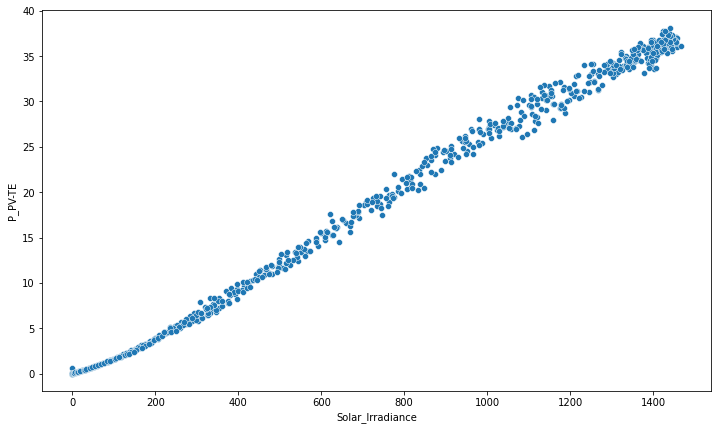

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Solar_Irradiance', y='P_PV-TE', data = antarctica_df)

Observation

1.There's an almost perfect linear relationship between the power output and Solar Irradiance.

In [ ]:
# All days where solar irradiance is 0, power should be 0 
antarctica_df[np.logical_and(antarctica_df.Solar_Irradiance ==0, antarctica_df['P_PV-TE'] == 0)]

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp  P_PV-TE  N_PV-TE  \
108 2019-04-18               0.0        7.04        231.83      0.0      0.0   
109 2019-04-19               0.0        9.23        225.50      0.0      0.0   
110 2019-04-20               0.0       10.96        225.41      0.0      0.0   
111 2019-04-21               0.0       10.69        226.51      0.0      0.0   
112 2019-04-22               0.0        7.55        231.76      0.0      0.0   
..         ...               ...         ...           ...      ...      ...   
963 2021-08-20               0.0        9.88        215.24      0.0      0.0   
964 2021-08-21               0.0        9.48        212.77      0.0      0.0   
965 2021-08-22               0.0        9.16        212.39      0.0      0.0   
966 2021-08-23               0.0        9.39        214.55      0.0      0.0   
967 2021-08-24               0.0       10.26        216.65      0.0      0.0   

    power_bin eff_bin  
108    lowest  lowest  
109    lowest  lowest  
110    lowest  lowest  
111    lowest  lowest  
112    lowest  lowest  
..        ...     ...  
963    lowest  lowest  
964    lowest  lowest  
965    lowest  lowest  
966    lowest  lowest  
967    lowest  lowest  

[390 rows x 8 columns]

In [ ]:
# finding the day where the above doesn't happen
antarctica_df[np.logical_and(antarctica_df.Solar_Irradiance ==0, antarctica_df['P_PV-TE'] > 0)]

# this day is actually an outlier and affects both power and efficiency

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp   P_PV-TE  \
968 2021-08-25               0.0        9.85        217.03  0.591542   

       N_PV-TE power_bin eff_bin  
968  10.983094     lower     low

<a name="outlier_handled" ></a>
#### Outlier_handled

In [ ]:
# I'll be replacing the values of power and efficiency with 0, since that's what it should be.
antarctica_df.iloc[967, 4:6] = [0,0]

In [ ]:
# Confirmation
antarctica_df[np.logical_and(antarctica_df.Solar_Irradiance ==0, antarctica_df['P_PV-TE'] > 0)]

Empty DataFrame
Columns: [Date, Solar_Irradiance, Wind_Speed, Ambient_Temp, P_PV-TE, N_PV-TE, power_bin, eff_bin]
Index: []

<AxesSubplot: xlabel='Ambient_Temp', ylabel='P_PV-TE'>

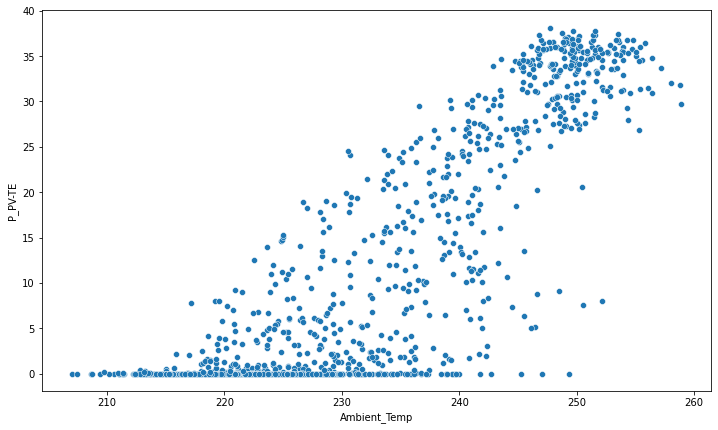

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Ambient_Temp', y='P_PV-TE', data = antarctica_df)

<AxesSubplot: xlabel='P_PV-TE', ylabel='Wind_Speed'>

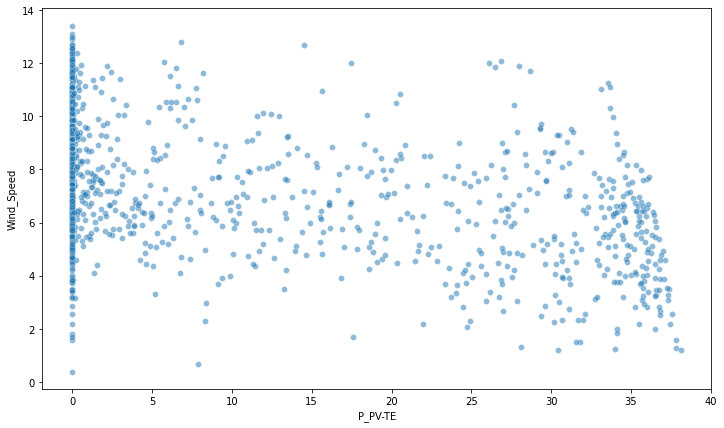

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='P_PV-TE', y='Wind_Speed', data = antarctica_df, alpha = 0.5)

In [ ]:
# average power across bins
antarctica_df.groupby('power_bin')['P_PV-TE'].mean()

power_bin
lowest      0.014433
lower       0.625736
low         1.835763
mediest     4.726161
medium      9.419372
mid        15.219313
high       22.427197
higher     28.421402
highest    32.793362
peak       35.805456
Name: P_PV-TE, dtype: float64

<AxesSubplot: xlabel='Ambient_Temp', ylabel='Solar_Irradiance'>

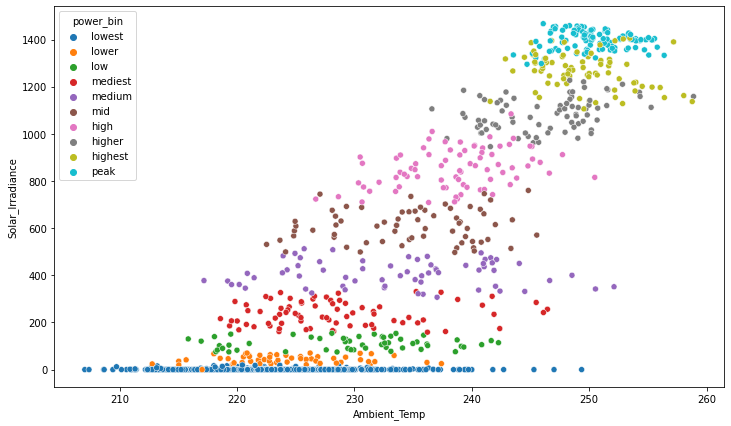

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Ambient_Temp', y='Solar_Irradiance', data = antarctica_df, hue= 'power_bin')

<a name = 'above'></a>
#### Binned

<AxesSubplot: xlabel='Wind_Speed', ylabel='Solar_Irradiance'>

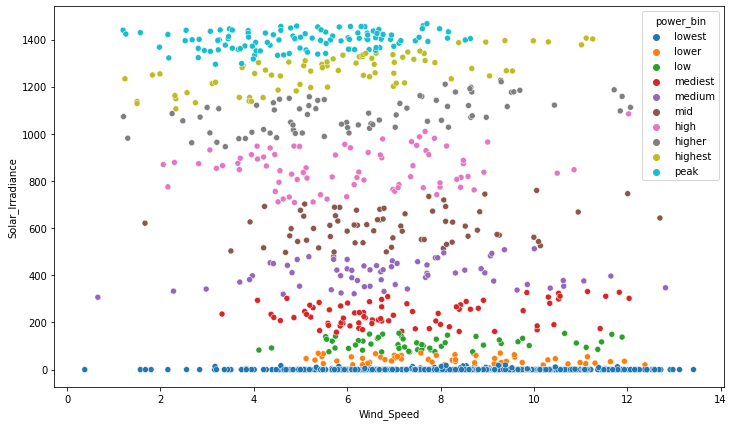

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Wind_Speed', y='Solar_Irradiance', data = antarctica_df, hue= 'power_bin')

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

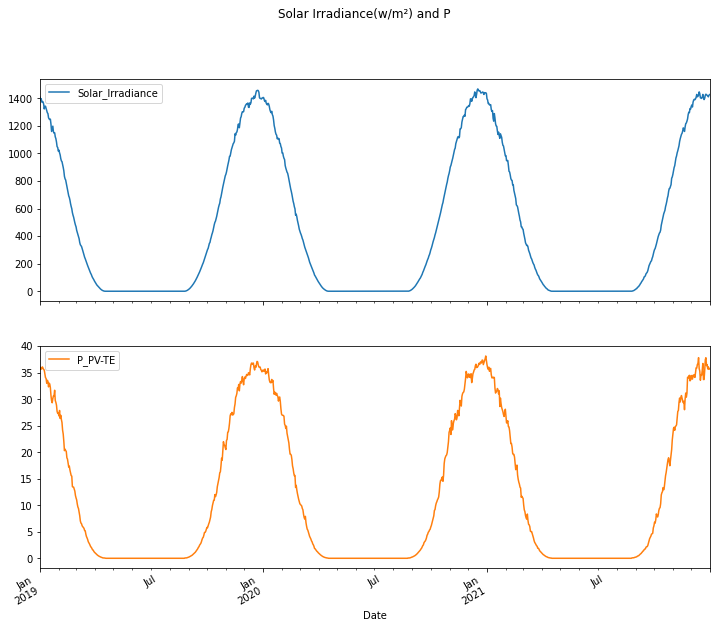

In [ ]:
# Comparing Seasonality of Irradiance to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Solar_Irradiance', 'P_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Solar Irradiance(w/m²) and P', figsize = (12,10))


Observations
1. There's very similar seasonality between solar Irradiance and the target variable and both are stationary that explains the almost perfect linear relationship.

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

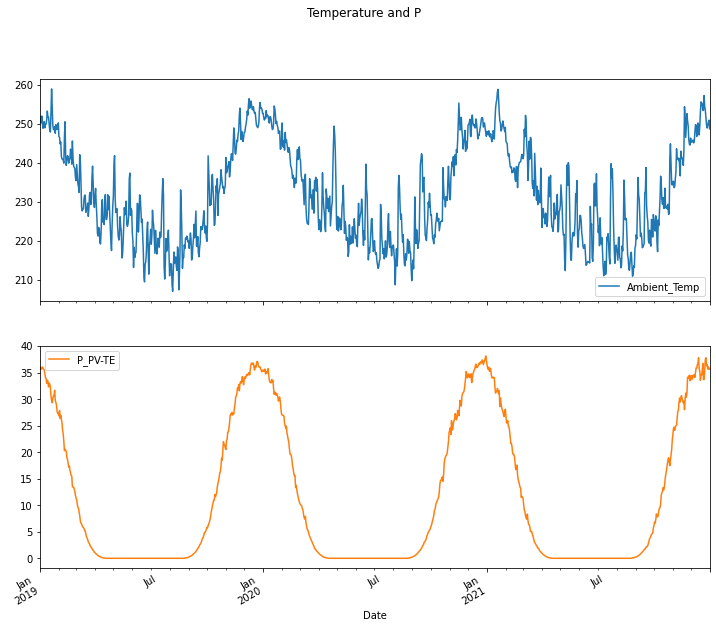

In [ ]:
# Comparing Seasonality of Temperature to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Ambient_Temp', 'P_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Temperature and P', figsize = (12,10))

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

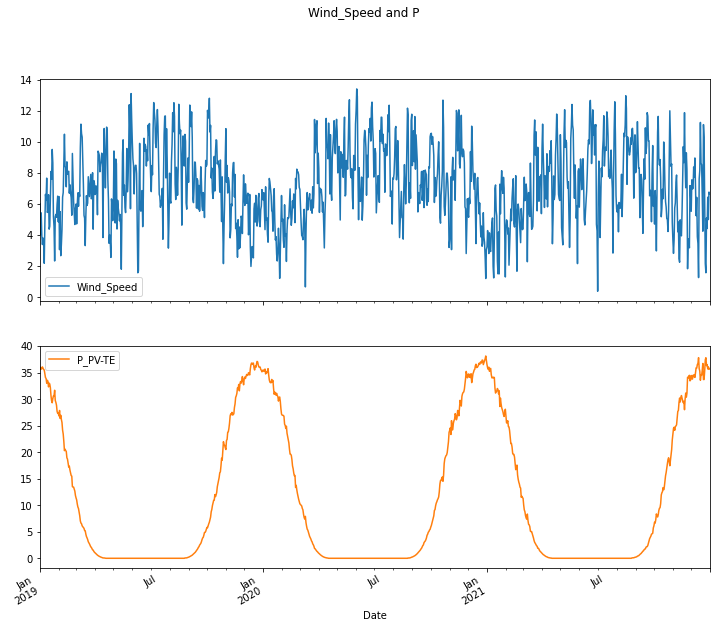

In [ ]:
# Comparing trend of Wind Speed to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Wind_Speed', 'P_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Wind_Speed and P', figsize = (12,10))


<a name="Engineering"></a>
## 7. Feature Creation

The target Variable has a trend with time there's basically a polynomial relationship between day of year and the target variable.

In [ ]:
antarctica_df['month'] = antarctica_df['Date'].dt.month
antarctica_df['dayofyear'] = antarctica_df['Date'].dt.dayofyear
antarctica_df['day'] = antarctica_df['Date'].dt.day
antarctica_df['weekday'] = antarctica_df['Date'].dt.weekday
antarctica_df['weekofyear'] = antarctica_df['Date'].dt.weekofyear
#antarctica_df['year'] = antarctica_df['Date'].dt.year


In [ ]:
antarctica_df.head()

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp    P_PV-TE  \
1 2019-01-01         1407.2023        6.02        250.20  35.625721   
2 2019-01-02         1387.6336        4.04        251.77  36.031725   
3 2019-01-03         1396.4022        5.43        250.19  35.644991   
4 2019-01-04         1371.8890        3.97        251.94  35.749122   
5 2019-01-05         1376.3911        3.39        250.09  36.067299   

     N_PV-TE power_bin eff_bin  month  dayofyear  day  weekday  weekofyear  
1  13.455113      peak  higher      1          1    1        1           1  
2  13.427494      peak    high      1          2    2        2           1  
3  13.450501      peak  higher      1          3    3        3           1  
4  13.436550      peak  higher      1          4    4        4           1  
5  13.421173      peak    high      1          5    5        5           1

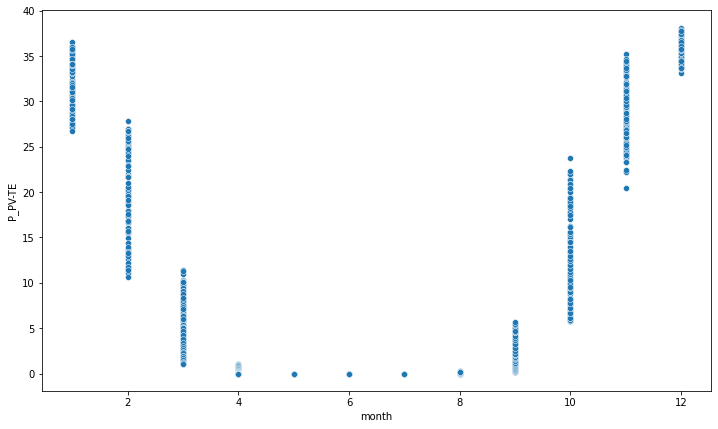

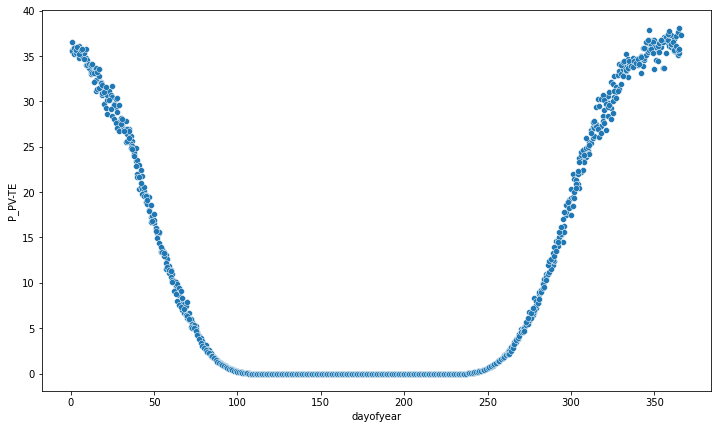

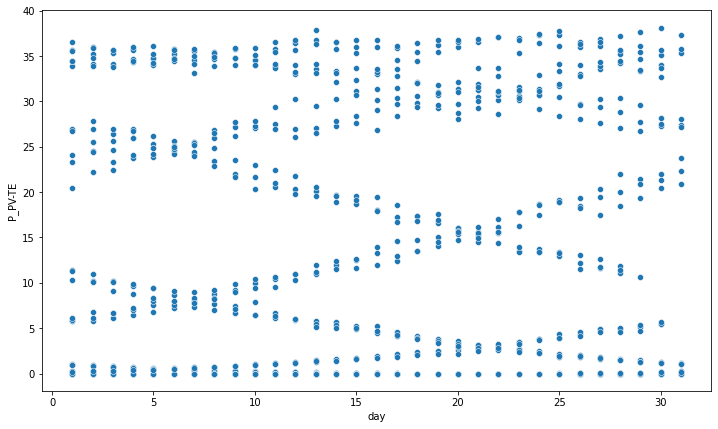

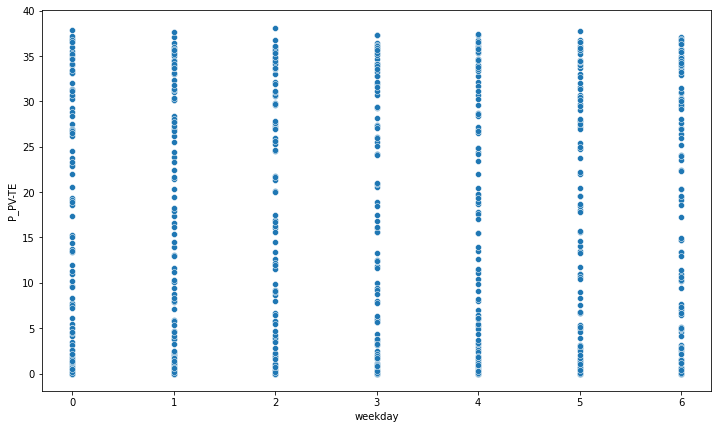

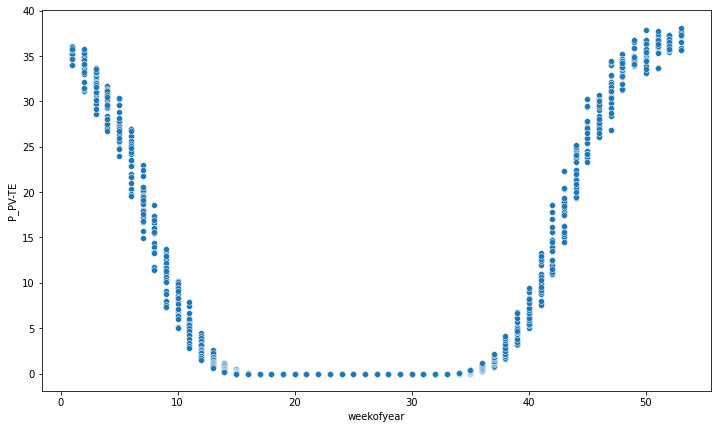

In [ ]:
# Plotting all time features using a loop
for time_feat in list(antarctica_df.columns)[8:]:
    plt.figure(figsize= (12,7))
    sns.scatterplot(x=time_feat, y='P_PV-TE', data = antarctica_df)

Observations

We notice that there's mostly polynomial relationship between the time features and the power output 

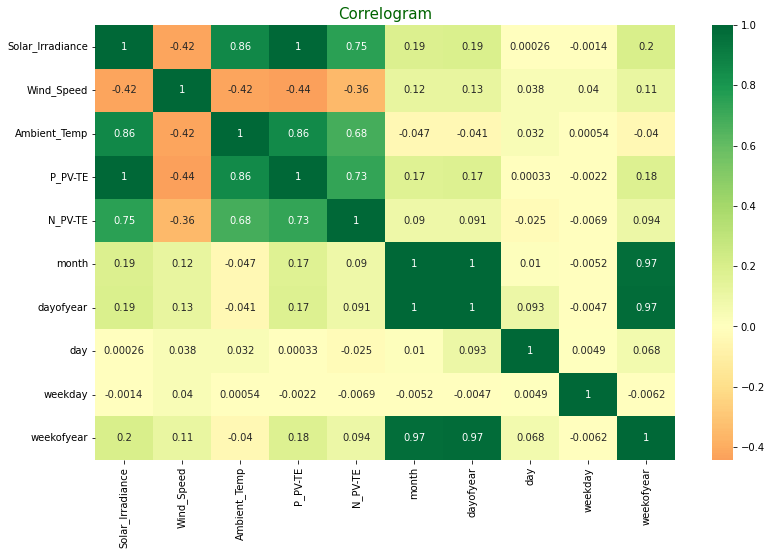

In [ ]:
# Correlation Heatmap 
corr = antarctica_df.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

Observations
1. We notice a perfect positive correlation between Solar Irradiance and P_PV-TE, we also notice a high positive correlation with ambient temp and a low negative correlation with windspeed.

In [ ]:
def scale_datasets(X_train, X_test, kind= 'standard'):
    '''Performs minmax or standard scaling on thrain and test datasets'''
    if kind == 'standard':
        standard_scaler = StandardScaler()
        x_train_scaled = pd.DataFrame(
          standard_scaler.fit_transform(X_train),
          columns=X_train.columns
      )
        x_test_scaled = pd.DataFrame(
          standard_scaler.transform(X_test),
          columns = X_test.columns
      )
    elif kind == 'min':
        mm_scaler = MinMaxScaler()
        x_train_scaled = pd.DataFrame(
          mm_scaler.fit_transform(X_train),
          columns=X_train.columns
      )
        x_test_scaled = pd.DataFrame(
          mm_scaler.transform(X_test),
          columns = X_test.columns
      )
    return x_train_scaled, x_test_scaled

In [ ]:
def plot_feat_imp(train_data, model):
    '''Plots the feature importances of models'''
    plt.bar(train_data.columns, model.feature_importances_)
    plt.title('Feature Importances for'+model.__class__.__name__)
    plt.xticks(rotation = 90)
    plt.show()
    
def plot_real_pred(X_test, y_test, model):
    '''Plots the real values against the predicted values of any model'''
    plt.figure(figsize = (10,6))
    plt.scatter(y_test, model.predict(X_test))
    plt.xlabel('Real Values')
    plt.ylabel('Predicted Values')
    plt.grid()

<a name="Final"></a>
## 8. Spliting data as time Series
Using 2021 as test data.

In [ ]:
n_train = antarctica_df.shape[0] - round(antarctica_df.shape[0]*0.333)
n_train

731

In [ ]:
X_traina = antarctica_df.drop(['P_PV-TE', 'N_PV-TE', 'power_bin', 'eff_bin'], axis= 1).iloc[:n_train, :]
y_traina = antarctica_df[['P_PV-TE']].iloc[:n_train, :]

X_testa = antarctica_df.drop(['P_PV-TE', 'N_PV-TE', 'power_bin', 'eff_bin'], axis= 1).iloc[n_train:, :]
y_testa = antarctica_df[['P_PV-TE']].iloc[n_train:, :]

In [ ]:
X_training = X_traina.drop('Date', axis = 1)
X_testing = X_testa.drop('Date', axis = 1)

In [ ]:
# Earliest day in the test set is January 1, 2021
X_testa.Date.min()

Timestamp('2021-01-01 00:00:00')

<a name="sensitivity_analysis"></a>
## 9. Sensitivity Analysis
Global Sensitivity Analysis Using Linear Regression. From the EDA, temperature and solar Irradiance are linearly related to 
the target but windspeed doesn't seem to have any relationship although there's a medium -ve correlation with windspeed and power output.

In [ ]:
lin_reg = LinearRegression()

In [ ]:
# Scaling features so the coefficient magnitude makes sense.
X_training, X_testing = scale_datasets(X_training, X_testing, kind ='min')

In [ ]:
X_training

Solar_Irradiance  Wind_Speed  Ambient_Temp  month  dayofyear       day  \
0            0.959097    0.420063      0.832562    0.0   0.000000  0.000000   
1            0.945760    0.264890      0.862847    0.0   0.002740  0.033333   
2            0.951737    0.373824      0.832369    0.0   0.005479  0.066667   
3            0.935029    0.259404      0.866127    0.0   0.008219  0.100000   
4            0.938098    0.213950      0.830440    0.0   0.010959  0.133333   
..                ...         ...           ...    ...        ...       ...   
726          0.972601    0.252351      0.820988    1.0   0.989041  0.866667   
727          0.981646    0.225705      0.831983    1.0   0.991781  0.900000   
728          0.980842    0.148119      0.804012    1.0   0.994521  0.933333   
729          0.981136    0.042320      0.784915    1.0   0.997260  0.966667   
730          0.978117    0.188871      0.766011    1.0   1.000000  1.000000   

      weekday  weekofyear  
0    0.166667    0.000000  
1    0.333333    0.000000  
2    0.500000    0.000000  
3    0.666667    0.000000  
4    0.833333    0.000000  
..        ...         ...  
726  1.000000    0.980769  
727  0.000000    1.000000  
728  0.166667    1.000000  
729  0.333333    1.000000  
730  0.500000    1.000000  

[731 rows x 8 columns]

In [ ]:
lin_reg.fit(X_training, y_traina)

LinearRegression()

In [ ]:
pred = lin_reg.predict(X_testing)

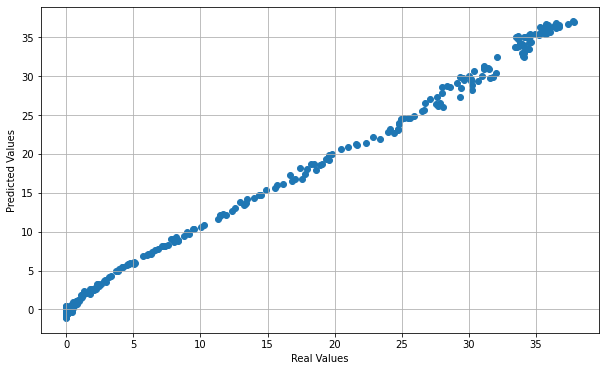

In [ ]:
plot_real_pred(X_testing, y_testa, lin_reg)

In [ ]:
## getting the coefficients of the linear regression model
lin_reg.coef_

array([[ 3.82039134e+01, -1.65083115e+00, -8.32964327e-01,
        -2.32995973e+01,  2.44556089e+01, -1.92573928e+00,
        -1.25675339e-02,  3.69138503e-01]])

([0, 1, 2, 3, 4, 5, 6, 7],
 [Text(0, 0, 'Solar_Irradiance'),
  Text(1, 0, 'Wind_Speed'),
  Text(2, 0, 'Ambient_Temp'),
  Text(3, 0, 'month'),
  Text(4, 0, 'dayofyear'),
  Text(5, 0, 'day'),
  Text(6, 0, 'weekday'),
  Text(7, 0, 'weekofyear')])

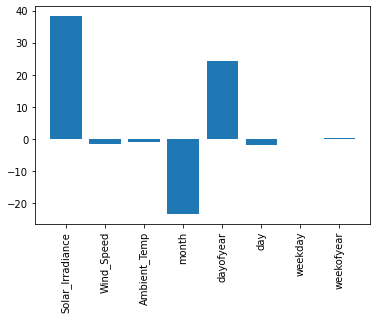

In [ ]:
plt.bar(X_testing.columns, lin_reg.coef_[0])
plt.xticks(rotation = 90)

In [ ]:
np.sqrt(mean_squared_error(y_testa, pred))

0.6852059035483334

**Observation.**

From the coefficients of the Linear regression model, we can see that the predictions are ruled by Solar Irradiance with the highest coefficient, day of year and then month with a negative correlation. 

However, this results can't be accepted because from the EDA month and day of year aren't libearly related to the power output and as pointed out earlier this is a drawback of using Linear regression for sensitivity analysis.

**To do an acceptable feature selection, Recursive feature elimination was carried out below.**

In [ ]:
## Sensitivity analysis plot showing how power changes with Irradiance and windspeed
antarctica_df['Temperature'] = pd.qcut(antarctica_df['P_PV-TE'], q= [0, 0.40, 0.5, 0.75, 1], labels = ['lowest','low', 'medium', 'high'])

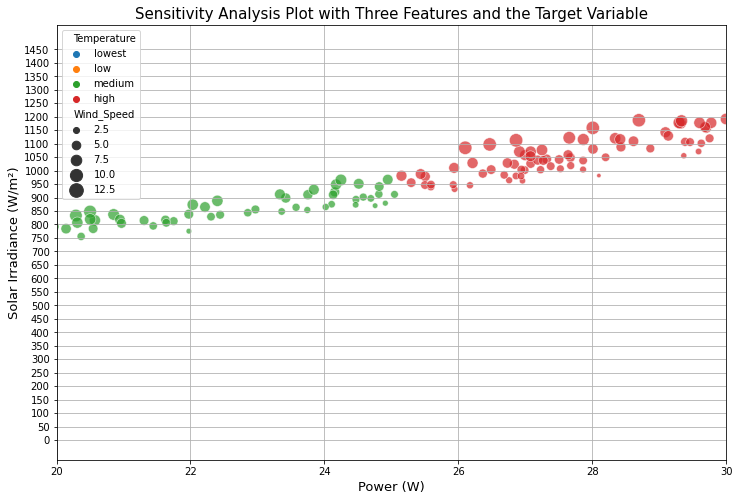

In [ ]:
plt.figure(figsize= (12,8))
sns.scatterplot(x='P_PV-TE', y='Solar_Irradiance', size = 'Wind_Speed', data = antarctica_df, hue= 'Temperature', 
                sizes = (5, 200), alpha= 0.7)
plt.yticks(list(range(0, 1500, 50)))
plt.title('Sensitivity Analysis Plot with Three Features and the Target Variable', fontsize= 15)
plt.ylabel('Solar Irradiance (W/m²)', fontsize = 13)
plt.xlabel('Power (W)', fontsize = 13)
plt.xlim(left = 20, right= 30)
plt.grid()
#plt.savefig('sensitivity_analysis_zoomed.jpg', dpi= 300)

### Brief Introduction and Observations

Until quite recently, sensitivity analysis was conceived and often defined as a local measure of the effect of a given input on a given output. This is customarily obtained by computing via a direct or indirect approach, system derivatives such as Sj = ∂Y/∂ Xj , where Y is the output of interest and Xj an input factor.


Sensitivity analysis can be said to be ‘The study of how the uncertainty in the output of a model (numerical or otherwise) can be apportioned to different sources of uncertainty in the model input’. 

In this plot, we see that as the power Increases, the Solar Irradiance and Temperature Increases. Now, while holding the Solar Irradiance constant we notice that as the windspeed decreases, the power Increases.

<a name="rfecv"></a>
### 10. Recursive Feature Elimination Cross Validation

In [ ]:
# Experimenting on 7 models
regressors = {
    'LGBM': LGBMRegressor(random_state=1),
    'Linear_regression':LinearRegression(),
    'Ridge': Ridge(),
    'XGB': XGBRegressor(random_state = 66),
    'cat': CatBoostRegressor(random_state = 77),
    'RandomForest': RandomForestRegressor(random_state = 99),
    'Decision Tree': DecisionTreeRegressor(random_state = 12),
    'Adaboost': AdaBoostRegressor(random_state= 40)
}

In [ ]:
def recurse(X_train, y_train, model):
    rfecv = RFECV(estimator= model, step=1, scoring = 'neg_mean_squared_error', cv= 5, verbose= 5, n_jobs=-1)
    
    # fitting with data
    rfecv.fit(X_train, y_train)
    
    # reducing the dataset and leaving the n best columns
    # rfecv.transform(X_train)
    
    print('Optimal Number of features for {} is: {}'.format(model.__class__.__name__, rfecv.n_features_))
    print(rfecv.get_feature_names_out())
    
    # prints out the mean cv score when n features were used
    print(rfecv.cv_results_['mean_test_score'], '\n')

In [ ]:
#rfecv = RFECV(estimator= DecisionTreeRegressor(), step=1, scoring = 'neg_mean_squared_error', cv= 5, verbose= 5, n_jobs=-1)
#rfecv.fit(X_training, y_traina)
#print('Optimal Number of features {}'.format(rfecv.n_features_))

#rfecv.transform(X_training)

In [ ]:
for mods in regressors:
    recurse(X_training, y_traina, regressors[mods])

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Optimal Number of features for LGBMRegressor is: 2
['Solar_Irradiance' 'Wind_Speed']
[-1.80682516e+02 -1.03831616e-01 -1.17020639e-01 -1.20833690e-01
 -1.31808508e-01 -1.32472570e-01 -1.34269119e-01 -1.34083663e-01] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Optimal Number of features for LinearRegression is: 1
['Solar_Irradiance']
[-0.66719617 -0.69469323 -0.69766708 -0.78983542 -0.7900076  -0.73309671
 -0.73019525 -1.17133089] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting est

172:	learn: 0.2931006	total: 608ms	remaining: 2.91s
173:	learn: 0.2915237	total: 611ms	remaining: 2.9s
174:	learn: 0.2905945	total: 613ms	remaining: 2.89s
175:	learn: 0.2895887	total: 616ms	remaining: 2.88s
176:	learn: 0.2880487	total: 618ms	remaining: 2.87s
177:	learn: 0.2873049	total: 620ms	remaining: 2.86s
178:	learn: 0.2857895	total: 622ms	remaining: 2.85s
179:	learn: 0.2847243	total: 624ms	remaining: 2.84s
180:	learn: 0.2829053	total: 627ms	remaining: 2.84s
181:	learn: 0.2817802	total: 630ms	remaining: 2.83s
182:	learn: 0.2808371	total: 632ms	remaining: 2.82s
183:	learn: 0.2793514	total: 635ms	remaining: 2.81s
184:	learn: 0.2778473	total: 637ms	remaining: 2.81s
185:	learn: 0.2767169	total: 640ms	remaining: 2.8s
186:	learn: 0.2755288	total: 642ms	remaining: 2.79s
187:	learn: 0.2741302	total: 644ms	remaining: 2.78s
188:	learn: 0.2725702	total: 647ms	remaining: 2.77s
189:	learn: 0.2714632	total: 649ms	remaining: 2.77s
190:	learn: 0.2695674	total: 651ms	remaining: 2.76s
191:	learn: 0.

343:	learn: 0.1659423	total: 1.07s	remaining: 2.05s
344:	learn: 0.1658644	total: 1.08s	remaining: 2.04s
345:	learn: 0.1657967	total: 1.08s	remaining: 2.04s
346:	learn: 0.1657315	total: 1.08s	remaining: 2.04s
347:	learn: 0.1652993	total: 1.09s	remaining: 2.04s
348:	learn: 0.1652267	total: 1.09s	remaining: 2.03s
349:	learn: 0.1651028	total: 1.09s	remaining: 2.03s
350:	learn: 0.1645862	total: 1.09s	remaining: 2.02s
351:	learn: 0.1645199	total: 1.1s	remaining: 2.02s
352:	learn: 0.1644613	total: 1.1s	remaining: 2.02s
353:	learn: 0.1640036	total: 1.1s	remaining: 2.01s
354:	learn: 0.1634689	total: 1.1s	remaining: 2.01s
355:	learn: 0.1630131	total: 1.11s	remaining: 2s
356:	learn: 0.1628918	total: 1.11s	remaining: 2s
357:	learn: 0.1626009	total: 1.11s	remaining: 2s
358:	learn: 0.1623947	total: 1.12s	remaining: 2s
359:	learn: 0.1623411	total: 1.12s	remaining: 1.99s
360:	learn: 0.1618400	total: 1.13s	remaining: 2s
361:	learn: 0.1614384	total: 1.13s	remaining: 1.99s
362:	learn: 0.1610391	total: 1.

502:	learn: 0.1207164	total: 1.54s	remaining: 1.52s
503:	learn: 0.1206093	total: 1.54s	remaining: 1.52s
504:	learn: 0.1204347	total: 1.54s	remaining: 1.51s
505:	learn: 0.1201323	total: 1.55s	remaining: 1.51s
506:	learn: 0.1198821	total: 1.55s	remaining: 1.51s
507:	learn: 0.1196133	total: 1.55s	remaining: 1.51s
508:	learn: 0.1193082	total: 1.56s	remaining: 1.5s
509:	learn: 0.1191420	total: 1.56s	remaining: 1.5s
510:	learn: 0.1190857	total: 1.56s	remaining: 1.5s
511:	learn: 0.1189716	total: 1.56s	remaining: 1.49s
512:	learn: 0.1186523	total: 1.57s	remaining: 1.49s
513:	learn: 0.1184650	total: 1.57s	remaining: 1.49s
514:	learn: 0.1182554	total: 1.57s	remaining: 1.48s
515:	learn: 0.1180513	total: 1.57s	remaining: 1.48s
516:	learn: 0.1178422	total: 1.58s	remaining: 1.48s
517:	learn: 0.1175487	total: 1.58s	remaining: 1.47s
518:	learn: 0.1172903	total: 1.59s	remaining: 1.47s
519:	learn: 0.1170637	total: 1.59s	remaining: 1.47s
520:	learn: 0.1168933	total: 1.6s	remaining: 1.47s
521:	learn: 0.11

664:	learn: 0.0936575	total: 2s	remaining: 1.01s
665:	learn: 0.0934753	total: 2.01s	remaining: 1.01s
666:	learn: 0.0933065	total: 2.01s	remaining: 1s
667:	learn: 0.0932106	total: 2.01s	remaining: 1s
668:	learn: 0.0931043	total: 2.02s	remaining: 999ms
669:	learn: 0.0929916	total: 2.02s	remaining: 995ms
670:	learn: 0.0929055	total: 2.02s	remaining: 992ms
671:	learn: 0.0928138	total: 2.02s	remaining: 988ms
672:	learn: 0.0927068	total: 2.03s	remaining: 985ms
673:	learn: 0.0925214	total: 2.03s	remaining: 982ms
674:	learn: 0.0923483	total: 2.03s	remaining: 980ms
675:	learn: 0.0922914	total: 2.04s	remaining: 976ms
676:	learn: 0.0921927	total: 2.04s	remaining: 973ms
677:	learn: 0.0920169	total: 2.04s	remaining: 970ms
678:	learn: 0.0918632	total: 2.05s	remaining: 968ms
679:	learn: 0.0916711	total: 2.05s	remaining: 965ms
680:	learn: 0.0915277	total: 2.05s	remaining: 962ms
681:	learn: 0.0913409	total: 2.06s	remaining: 959ms
682:	learn: 0.0912626	total: 2.06s	remaining: 956ms
683:	learn: 0.0911461

830:	learn: 0.0761100	total: 2.47s	remaining: 503ms
831:	learn: 0.0759384	total: 2.48s	remaining: 500ms
832:	learn: 0.0758812	total: 2.48s	remaining: 497ms
833:	learn: 0.0758304	total: 2.48s	remaining: 494ms
834:	learn: 0.0757029	total: 2.48s	remaining: 491ms
835:	learn: 0.0756265	total: 2.48s	remaining: 487ms
836:	learn: 0.0754600	total: 2.49s	remaining: 484ms
837:	learn: 0.0754105	total: 2.49s	remaining: 482ms
838:	learn: 0.0753880	total: 2.49s	remaining: 478ms
839:	learn: 0.0752595	total: 2.5s	remaining: 475ms
840:	learn: 0.0751811	total: 2.5s	remaining: 472ms
841:	learn: 0.0751146	total: 2.5s	remaining: 469ms
842:	learn: 0.0750084	total: 2.5s	remaining: 466ms
843:	learn: 0.0749156	total: 2.51s	remaining: 463ms
844:	learn: 0.0748279	total: 2.51s	remaining: 460ms
845:	learn: 0.0746957	total: 2.52s	remaining: 458ms
846:	learn: 0.0746399	total: 2.52s	remaining: 455ms
847:	learn: 0.0745010	total: 2.52s	remaining: 452ms
848:	learn: 0.0743522	total: 2.52s	remaining: 449ms
849:	learn: 0.07

Fitting estimator with 7 features.
Learning rate set to 0.038965
0:	learn: 13.2856753	total: 3.11ms	remaining: 3.11s
1:	learn: 12.8521271	total: 6.05ms	remaining: 3.02s
2:	learn: 12.3874048	total: 9.04ms	remaining: 3s
3:	learn: 11.9757335	total: 11.2ms	remaining: 2.79s
4:	learn: 11.5627278	total: 13.4ms	remaining: 2.66s
5:	learn: 11.1556882	total: 15.3ms	remaining: 2.54s
6:	learn: 10.7602777	total: 18.4ms	remaining: 2.61s
7:	learn: 10.3772903	total: 20.9ms	remaining: 2.59s
8:	learn: 10.0137887	total: 22.3ms	remaining: 2.45s
9:	learn: 9.6665381	total: 24.4ms	remaining: 2.42s
10:	learn: 9.3392030	total: 26.7ms	remaining: 2.4s
11:	learn: 9.0135556	total: 29.4ms	remaining: 2.42s
12:	learn: 8.7004944	total: 31ms	remaining: 2.35s
13:	learn: 8.4175209	total: 33.3ms	remaining: 2.34s
14:	learn: 8.1236032	total: 35.5ms	remaining: 2.33s
15:	learn: 7.8383888	total: 37.5ms	remaining: 2.31s
16:	learn: 7.5690696	total: 39.7ms	remaining: 2.29s
17:	learn: 7.3217703	total: 41.8ms	remaining: 2.28s
18:	le

176:	learn: 0.3182451	total: 416ms	remaining: 1.94s
177:	learn: 0.3169632	total: 419ms	remaining: 1.94s
178:	learn: 0.3148713	total: 423ms	remaining: 1.94s
179:	learn: 0.3136405	total: 427ms	remaining: 1.94s
180:	learn: 0.3122940	total: 429ms	remaining: 1.94s
181:	learn: 0.3103742	total: 432ms	remaining: 1.94s
182:	learn: 0.3096683	total: 434ms	remaining: 1.94s
183:	learn: 0.3084092	total: 437ms	remaining: 1.94s
184:	learn: 0.3060925	total: 439ms	remaining: 1.94s
185:	learn: 0.3052273	total: 442ms	remaining: 1.94s
186:	learn: 0.3035671	total: 445ms	remaining: 1.93s
187:	learn: 0.3015288	total: 447ms	remaining: 1.93s
188:	learn: 0.3006916	total: 449ms	remaining: 1.93s
189:	learn: 0.2988373	total: 452ms	remaining: 1.93s
190:	learn: 0.2979288	total: 455ms	remaining: 1.93s
191:	learn: 0.2968865	total: 457ms	remaining: 1.92s
192:	learn: 0.2956814	total: 460ms	remaining: 1.92s
193:	learn: 0.2945439	total: 465ms	remaining: 1.93s
194:	learn: 0.2936997	total: 469ms	remaining: 1.94s
195:	learn: 

362:	learn: 0.1731645	total: 878ms	remaining: 1.54s
363:	learn: 0.1726267	total: 881ms	remaining: 1.54s
364:	learn: 0.1725431	total: 883ms	remaining: 1.54s
365:	learn: 0.1720914	total: 886ms	remaining: 1.53s
366:	learn: 0.1716700	total: 888ms	remaining: 1.53s
367:	learn: 0.1714351	total: 890ms	remaining: 1.53s
368:	learn: 0.1711061	total: 893ms	remaining: 1.53s
369:	learn: 0.1708582	total: 896ms	remaining: 1.53s
370:	learn: 0.1703718	total: 899ms	remaining: 1.52s
371:	learn: 0.1700131	total: 902ms	remaining: 1.52s
372:	learn: 0.1697598	total: 905ms	remaining: 1.52s
373:	learn: 0.1694089	total: 907ms	remaining: 1.52s
374:	learn: 0.1691959	total: 910ms	remaining: 1.52s
375:	learn: 0.1689037	total: 912ms	remaining: 1.51s
376:	learn: 0.1685225	total: 914ms	remaining: 1.51s
377:	learn: 0.1682988	total: 917ms	remaining: 1.51s
378:	learn: 0.1680673	total: 920ms	remaining: 1.51s
379:	learn: 0.1677996	total: 922ms	remaining: 1.5s
380:	learn: 0.1676444	total: 925ms	remaining: 1.5s
381:	learn: 0.

549:	learn: 0.1258650	total: 1.34s	remaining: 1.1s
550:	learn: 0.1258284	total: 1.35s	remaining: 1.1s
551:	learn: 0.1257641	total: 1.35s	remaining: 1.1s
552:	learn: 0.1255140	total: 1.35s	remaining: 1.09s
553:	learn: 0.1254817	total: 1.36s	remaining: 1.09s
554:	learn: 0.1251816	total: 1.36s	remaining: 1.09s
555:	learn: 0.1249239	total: 1.36s	remaining: 1.09s
556:	learn: 0.1247518	total: 1.36s	remaining: 1.08s
557:	learn: 0.1245166	total: 1.37s	remaining: 1.08s
558:	learn: 0.1244748	total: 1.37s	remaining: 1.08s
559:	learn: 0.1242417	total: 1.37s	remaining: 1.08s
560:	learn: 0.1239578	total: 1.38s	remaining: 1.08s
561:	learn: 0.1237078	total: 1.38s	remaining: 1.07s
562:	learn: 0.1236640	total: 1.38s	remaining: 1.07s
563:	learn: 0.1236401	total: 1.38s	remaining: 1.07s
564:	learn: 0.1234209	total: 1.39s	remaining: 1.07s
565:	learn: 0.1231195	total: 1.39s	remaining: 1.06s
566:	learn: 0.1229243	total: 1.39s	remaining: 1.06s
567:	learn: 0.1227041	total: 1.39s	remaining: 1.06s
568:	learn: 0.1

728:	learn: 0.0990397	total: 1.81s	remaining: 672ms
729:	learn: 0.0989540	total: 1.81s	remaining: 669ms
730:	learn: 0.0989089	total: 1.81s	remaining: 667ms
731:	learn: 0.0987221	total: 1.81s	remaining: 664ms
732:	learn: 0.0986040	total: 1.82s	remaining: 662ms
733:	learn: 0.0984904	total: 1.82s	remaining: 660ms
734:	learn: 0.0983548	total: 1.82s	remaining: 657ms
735:	learn: 0.0983338	total: 1.82s	remaining: 655ms
736:	learn: 0.0982640	total: 1.83s	remaining: 652ms
737:	learn: 0.0981525	total: 1.83s	remaining: 650ms
738:	learn: 0.0980271	total: 1.83s	remaining: 648ms
739:	learn: 0.0979127	total: 1.84s	remaining: 645ms
740:	learn: 0.0978532	total: 1.84s	remaining: 643ms
741:	learn: 0.0977444	total: 1.84s	remaining: 640ms
742:	learn: 0.0976590	total: 1.84s	remaining: 637ms
743:	learn: 0.0975328	total: 1.84s	remaining: 635ms
744:	learn: 0.0974205	total: 1.85s	remaining: 632ms
745:	learn: 0.0972510	total: 1.85s	remaining: 629ms
746:	learn: 0.0972182	total: 1.85s	remaining: 627ms
747:	learn: 

933:	learn: 0.0809591	total: 2.26s	remaining: 160ms
934:	learn: 0.0808938	total: 2.26s	remaining: 157ms
935:	learn: 0.0808372	total: 2.27s	remaining: 155ms
936:	learn: 0.0806733	total: 2.27s	remaining: 153ms
937:	learn: 0.0805728	total: 2.27s	remaining: 150ms
938:	learn: 0.0804837	total: 2.27s	remaining: 148ms
939:	learn: 0.0804104	total: 2.28s	remaining: 145ms
940:	learn: 0.0803127	total: 2.28s	remaining: 143ms
941:	learn: 0.0802104	total: 2.28s	remaining: 140ms
942:	learn: 0.0801395	total: 2.28s	remaining: 138ms
943:	learn: 0.0801322	total: 2.29s	remaining: 136ms
944:	learn: 0.0800537	total: 2.29s	remaining: 133ms
945:	learn: 0.0799679	total: 2.29s	remaining: 131ms
946:	learn: 0.0798828	total: 2.29s	remaining: 128ms
947:	learn: 0.0798082	total: 2.29s	remaining: 126ms
948:	learn: 0.0797125	total: 2.3s	remaining: 124ms
949:	learn: 0.0795978	total: 2.3s	remaining: 121ms
950:	learn: 0.0795926	total: 2.3s	remaining: 119ms
951:	learn: 0.0795695	total: 2.3s	remaining: 116ms
952:	learn: 0.07

117:	learn: 0.4921881	total: 296ms	remaining: 2.21s
118:	learn: 0.4868522	total: 298ms	remaining: 2.21s
119:	learn: 0.4822517	total: 301ms	remaining: 2.2s
120:	learn: 0.4769515	total: 303ms	remaining: 2.2s
121:	learn: 0.4725097	total: 306ms	remaining: 2.2s
122:	learn: 0.4678774	total: 308ms	remaining: 2.2s
123:	learn: 0.4633914	total: 311ms	remaining: 2.19s
124:	learn: 0.4595070	total: 313ms	remaining: 2.19s
125:	learn: 0.4547365	total: 315ms	remaining: 2.19s
126:	learn: 0.4501340	total: 318ms	remaining: 2.18s
127:	learn: 0.4464072	total: 320ms	remaining: 2.18s
128:	learn: 0.4422333	total: 324ms	remaining: 2.19s
129:	learn: 0.4384177	total: 326ms	remaining: 2.19s
130:	learn: 0.4345263	total: 329ms	remaining: 2.18s
131:	learn: 0.4306062	total: 331ms	remaining: 2.17s
132:	learn: 0.4266227	total: 333ms	remaining: 2.17s
133:	learn: 0.4235641	total: 337ms	remaining: 2.17s
134:	learn: 0.4196222	total: 339ms	remaining: 2.17s
135:	learn: 0.4155707	total: 341ms	remaining: 2.17s
136:	learn: 0.41

301:	learn: 0.2035580	total: 757ms	remaining: 1.75s
302:	learn: 0.2027754	total: 760ms	remaining: 1.75s
303:	learn: 0.2022204	total: 762ms	remaining: 1.75s
304:	learn: 0.2016320	total: 765ms	remaining: 1.74s
305:	learn: 0.2008267	total: 767ms	remaining: 1.74s
306:	learn: 0.2000358	total: 769ms	remaining: 1.74s
307:	learn: 0.1993221	total: 771ms	remaining: 1.73s
308:	learn: 0.1986978	total: 774ms	remaining: 1.73s
309:	learn: 0.1977849	total: 777ms	remaining: 1.73s
310:	learn: 0.1970799	total: 779ms	remaining: 1.73s
311:	learn: 0.1967399	total: 781ms	remaining: 1.72s
312:	learn: 0.1962194	total: 784ms	remaining: 1.72s
313:	learn: 0.1954320	total: 786ms	remaining: 1.72s
314:	learn: 0.1947659	total: 789ms	remaining: 1.72s
315:	learn: 0.1942890	total: 794ms	remaining: 1.72s
316:	learn: 0.1938758	total: 797ms	remaining: 1.72s
317:	learn: 0.1935439	total: 833ms	remaining: 1.79s
318:	learn: 0.1928532	total: 837ms	remaining: 1.79s
319:	learn: 0.1924622	total: 861ms	remaining: 1.83s
320:	learn: 

481:	learn: 0.1358481	total: 1.4s	remaining: 1.51s
482:	learn: 0.1355478	total: 1.41s	remaining: 1.51s
483:	learn: 0.1354985	total: 1.41s	remaining: 1.5s
484:	learn: 0.1352813	total: 1.41s	remaining: 1.5s
485:	learn: 0.1349814	total: 1.42s	remaining: 1.5s
486:	learn: 0.1347983	total: 1.43s	remaining: 1.5s
487:	learn: 0.1345587	total: 1.43s	remaining: 1.5s
488:	learn: 0.1343527	total: 1.43s	remaining: 1.5s
489:	learn: 0.1342077	total: 1.43s	remaining: 1.49s
490:	learn: 0.1341649	total: 1.44s	remaining: 1.49s
491:	learn: 0.1339807	total: 1.44s	remaining: 1.49s
492:	learn: 0.1339502	total: 1.44s	remaining: 1.48s
493:	learn: 0.1339208	total: 1.44s	remaining: 1.48s
494:	learn: 0.1337125	total: 1.45s	remaining: 1.47s
495:	learn: 0.1335674	total: 1.45s	remaining: 1.47s
496:	learn: 0.1333198	total: 1.45s	remaining: 1.47s
497:	learn: 0.1328846	total: 1.45s	remaining: 1.46s
498:	learn: 0.1325728	total: 1.45s	remaining: 1.46s
499:	learn: 0.1322794	total: 1.46s	remaining: 1.46s
500:	learn: 0.13220

656:	learn: 0.1095918	total: 1.88s	remaining: 980ms
657:	learn: 0.1094847	total: 1.88s	remaining: 977ms
658:	learn: 0.1093631	total: 1.88s	remaining: 974ms
659:	learn: 0.1090754	total: 1.88s	remaining: 971ms
660:	learn: 0.1088999	total: 1.89s	remaining: 967ms
661:	learn: 0.1086827	total: 1.89s	remaining: 964ms
662:	learn: 0.1086543	total: 1.89s	remaining: 961ms
663:	learn: 0.1085501	total: 1.89s	remaining: 958ms
664:	learn: 0.1083784	total: 1.9s	remaining: 955ms
665:	learn: 0.1082847	total: 1.9s	remaining: 952ms
666:	learn: 0.1080942	total: 1.9s	remaining: 949ms
667:	learn: 0.1079558	total: 1.9s	remaining: 946ms
668:	learn: 0.1078616	total: 1.9s	remaining: 942ms
669:	learn: 0.1077400	total: 1.91s	remaining: 940ms
670:	learn: 0.1075864	total: 1.91s	remaining: 937ms
671:	learn: 0.1074139	total: 1.91s	remaining: 933ms
672:	learn: 0.1073372	total: 1.91s	remaining: 930ms
673:	learn: 0.1071947	total: 1.92s	remaining: 927ms
674:	learn: 0.1070647	total: 1.92s	remaining: 924ms
675:	learn: 0.106

855:	learn: 0.0869932	total: 2.33s	remaining: 392ms
856:	learn: 0.0869486	total: 2.33s	remaining: 389ms
857:	learn: 0.0868859	total: 2.33s	remaining: 386ms
858:	learn: 0.0868305	total: 2.34s	remaining: 384ms
859:	learn: 0.0867163	total: 2.34s	remaining: 381ms
860:	learn: 0.0866513	total: 2.34s	remaining: 378ms
861:	learn: 0.0866353	total: 2.34s	remaining: 375ms
862:	learn: 0.0865842	total: 2.35s	remaining: 373ms
863:	learn: 0.0865439	total: 2.35s	remaining: 370ms
864:	learn: 0.0865259	total: 2.35s	remaining: 367ms
865:	learn: 0.0864678	total: 2.35s	remaining: 364ms
866:	learn: 0.0863660	total: 2.36s	remaining: 362ms
867:	learn: 0.0863562	total: 2.36s	remaining: 359ms
868:	learn: 0.0862422	total: 2.36s	remaining: 356ms
869:	learn: 0.0861223	total: 2.36s	remaining: 353ms
870:	learn: 0.0860466	total: 2.37s	remaining: 351ms
871:	learn: 0.0859787	total: 2.37s	remaining: 348ms
872:	learn: 0.0859472	total: 2.37s	remaining: 345ms
873:	learn: 0.0858620	total: 2.37s	remaining: 342ms
874:	learn: 

46:	learn: 2.6398666	total: 98.3ms	remaining: 1.99s
47:	learn: 2.5510750	total: 101ms	remaining: 1.99s
48:	learn: 2.4676946	total: 103ms	remaining: 2s
49:	learn: 2.3904481	total: 105ms	remaining: 2s
50:	learn: 2.3124299	total: 107ms	remaining: 2s
51:	learn: 2.2360111	total: 110ms	remaining: 2s
52:	learn: 2.1637293	total: 112ms	remaining: 2.01s
53:	learn: 2.0943397	total: 114ms	remaining: 2s
54:	learn: 2.0234059	total: 116ms	remaining: 2s
55:	learn: 1.9622689	total: 119ms	remaining: 2s
56:	learn: 1.9058052	total: 121ms	remaining: 2s
57:	learn: 1.8451281	total: 124ms	remaining: 2.02s
58:	learn: 1.7851589	total: 127ms	remaining: 2.02s
59:	learn: 1.7280186	total: 129ms	remaining: 2.02s
60:	learn: 1.6782157	total: 133ms	remaining: 2.04s
61:	learn: 1.6261822	total: 135ms	remaining: 2.04s
62:	learn: 1.5779093	total: 138ms	remaining: 2.05s
63:	learn: 1.5305753	total: 141ms	remaining: 2.06s
64:	learn: 1.4849952	total: 143ms	remaining: 2.05s
65:	learn: 1.4426367	total: 144ms	remaining: 2.04s
66:

243:	learn: 0.2429136	total: 555ms	remaining: 1.72s
244:	learn: 0.2426662	total: 557ms	remaining: 1.72s
245:	learn: 0.2416099	total: 559ms	remaining: 1.71s
246:	learn: 0.2407099	total: 562ms	remaining: 1.71s
247:	learn: 0.2403441	total: 564ms	remaining: 1.71s
248:	learn: 0.2397926	total: 567ms	remaining: 1.71s
249:	learn: 0.2395014	total: 571ms	remaining: 1.71s
250:	learn: 0.2392743	total: 575ms	remaining: 1.72s
251:	learn: 0.2381254	total: 578ms	remaining: 1.72s
252:	learn: 0.2370918	total: 581ms	remaining: 1.71s
253:	learn: 0.2365056	total: 586ms	remaining: 1.72s
254:	learn: 0.2349085	total: 588ms	remaining: 1.72s
255:	learn: 0.2348088	total: 590ms	remaining: 1.72s
256:	learn: 0.2332451	total: 592ms	remaining: 1.71s
257:	learn: 0.2326569	total: 595ms	remaining: 1.71s
258:	learn: 0.2320150	total: 597ms	remaining: 1.71s
259:	learn: 0.2312423	total: 600ms	remaining: 1.71s
260:	learn: 0.2304852	total: 602ms	remaining: 1.71s
261:	learn: 0.2297957	total: 605ms	remaining: 1.7s
262:	learn: 0

423:	learn: 0.1501835	total: 1.01s	remaining: 1.38s
424:	learn: 0.1501342	total: 1.01s	remaining: 1.37s
425:	learn: 0.1498141	total: 1.02s	remaining: 1.37s
426:	learn: 0.1497304	total: 1.02s	remaining: 1.37s
427:	learn: 0.1494528	total: 1.02s	remaining: 1.37s
428:	learn: 0.1493911	total: 1.02s	remaining: 1.36s
429:	learn: 0.1489588	total: 1.03s	remaining: 1.36s
430:	learn: 0.1487001	total: 1.03s	remaining: 1.36s
431:	learn: 0.1483598	total: 1.03s	remaining: 1.36s
432:	learn: 0.1481168	total: 1.03s	remaining: 1.35s
433:	learn: 0.1480017	total: 1.04s	remaining: 1.35s
434:	learn: 0.1476235	total: 1.04s	remaining: 1.35s
435:	learn: 0.1475460	total: 1.04s	remaining: 1.35s
436:	learn: 0.1472530	total: 1.04s	remaining: 1.34s
437:	learn: 0.1469055	total: 1.04s	remaining: 1.34s
438:	learn: 0.1466777	total: 1.05s	remaining: 1.34s
439:	learn: 0.1464232	total: 1.05s	remaining: 1.34s
440:	learn: 0.1460968	total: 1.05s	remaining: 1.33s
441:	learn: 0.1460198	total: 1.05s	remaining: 1.33s
442:	learn: 

614:	learn: 0.1116294	total: 1.47s	remaining: 923ms
615:	learn: 0.1114512	total: 1.48s	remaining: 921ms
616:	learn: 0.1112758	total: 1.48s	remaining: 918ms
617:	learn: 0.1111056	total: 1.48s	remaining: 916ms
618:	learn: 0.1109915	total: 1.48s	remaining: 913ms
619:	learn: 0.1108878	total: 1.49s	remaining: 911ms
620:	learn: 0.1107869	total: 1.49s	remaining: 908ms
621:	learn: 0.1107661	total: 1.49s	remaining: 905ms
622:	learn: 0.1104350	total: 1.49s	remaining: 903ms
623:	learn: 0.1102990	total: 1.49s	remaining: 901ms
624:	learn: 0.1100019	total: 1.5s	remaining: 898ms
625:	learn: 0.1098771	total: 1.5s	remaining: 896ms
626:	learn: 0.1096623	total: 1.5s	remaining: 893ms
627:	learn: 0.1096492	total: 1.5s	remaining: 891ms
628:	learn: 0.1094877	total: 1.5s	remaining: 888ms
629:	learn: 0.1092546	total: 1.51s	remaining: 886ms
630:	learn: 0.1091920	total: 1.51s	remaining: 883ms
631:	learn: 0.1090395	total: 1.51s	remaining: 881ms
632:	learn: 0.1089058	total: 1.51s	remaining: 878ms
633:	learn: 0.108

810:	learn: 0.0893356	total: 1.93s	remaining: 450ms
811:	learn: 0.0891785	total: 1.94s	remaining: 448ms
812:	learn: 0.0890962	total: 1.94s	remaining: 446ms
813:	learn: 0.0889524	total: 1.94s	remaining: 444ms
814:	learn: 0.0888944	total: 1.94s	remaining: 441ms
815:	learn: 0.0888068	total: 1.95s	remaining: 439ms
816:	learn: 0.0887608	total: 1.95s	remaining: 436ms
817:	learn: 0.0886866	total: 1.95s	remaining: 434ms
818:	learn: 0.0886465	total: 1.95s	remaining: 431ms
819:	learn: 0.0886082	total: 1.96s	remaining: 429ms
820:	learn: 0.0884573	total: 1.96s	remaining: 427ms
821:	learn: 0.0884311	total: 1.96s	remaining: 424ms
822:	learn: 0.0883395	total: 1.96s	remaining: 422ms
823:	learn: 0.0881444	total: 1.96s	remaining: 420ms
824:	learn: 0.0879838	total: 1.97s	remaining: 417ms
825:	learn: 0.0878786	total: 1.97s	remaining: 415ms
826:	learn: 0.0877337	total: 1.97s	remaining: 412ms
827:	learn: 0.0876324	total: 1.97s	remaining: 410ms
828:	learn: 0.0875938	total: 1.98s	remaining: 407ms
829:	learn: 

996:	learn: 0.0741597	total: 2.39s	remaining: 7.21ms
997:	learn: 0.0740941	total: 2.4s	remaining: 4.8ms
998:	learn: 0.0740143	total: 2.4s	remaining: 2.4ms
999:	learn: 0.0739053	total: 2.4s	remaining: 0us
Fitting estimator with 4 features.
Learning rate set to 0.038965
0:	learn: 13.2608956	total: 1.86ms	remaining: 1.86s
1:	learn: 12.7951067	total: 3.45ms	remaining: 1.72s
2:	learn: 12.3278465	total: 5.11ms	remaining: 1.7s
3:	learn: 11.8797669	total: 6.87ms	remaining: 1.71s
4:	learn: 11.4669291	total: 9.05ms	remaining: 1.8s
5:	learn: 11.0501802	total: 10.9ms	remaining: 1.8s
6:	learn: 10.6593502	total: 12.8ms	remaining: 1.81s
7:	learn: 10.2847419	total: 14.7ms	remaining: 1.82s
8:	learn: 9.9206310	total: 16.5ms	remaining: 1.81s
9:	learn: 9.5830921	total: 18.5ms	remaining: 1.83s
10:	learn: 9.2541231	total: 20.3ms	remaining: 1.83s
11:	learn: 8.9277391	total: 22.3ms	remaining: 1.84s
12:	learn: 8.6120251	total: 24.4ms	remaining: 1.85s
13:	learn: 8.3007023	total: 26.5ms	remaining: 1.87s
14:	lear

185:	learn: 0.4981715	total: 400ms	remaining: 1.75s
186:	learn: 0.4971861	total: 402ms	remaining: 1.75s
187:	learn: 0.4959235	total: 404ms	remaining: 1.74s
188:	learn: 0.4947202	total: 406ms	remaining: 1.74s
189:	learn: 0.4937300	total: 408ms	remaining: 1.74s
190:	learn: 0.4927022	total: 410ms	remaining: 1.74s
191:	learn: 0.4917561	total: 412ms	remaining: 1.74s
192:	learn: 0.4898742	total: 414ms	remaining: 1.73s
193:	learn: 0.4887411	total: 416ms	remaining: 1.73s
194:	learn: 0.4877980	total: 418ms	remaining: 1.73s
195:	learn: 0.4866167	total: 420ms	remaining: 1.72s
196:	learn: 0.4855932	total: 422ms	remaining: 1.72s
197:	learn: 0.4846778	total: 424ms	remaining: 1.72s
198:	learn: 0.4833798	total: 426ms	remaining: 1.72s
199:	learn: 0.4822337	total: 428ms	remaining: 1.71s
200:	learn: 0.4805834	total: 431ms	remaining: 1.71s
201:	learn: 0.4790798	total: 433ms	remaining: 1.71s
202:	learn: 0.4777182	total: 435ms	remaining: 1.71s
203:	learn: 0.4763761	total: 437ms	remaining: 1.7s
204:	learn: 0

408:	learn: 0.3352446	total: 840ms	remaining: 1.21s
409:	learn: 0.3350819	total: 842ms	remaining: 1.21s
410:	learn: 0.3348928	total: 845ms	remaining: 1.21s
411:	learn: 0.3343259	total: 848ms	remaining: 1.21s
412:	learn: 0.3341690	total: 849ms	remaining: 1.21s
413:	learn: 0.3339845	total: 851ms	remaining: 1.21s
414:	learn: 0.3338055	total: 853ms	remaining: 1.2s
415:	learn: 0.3336712	total: 855ms	remaining: 1.2s
416:	learn: 0.3332558	total: 858ms	remaining: 1.2s
417:	learn: 0.3328089	total: 859ms	remaining: 1.2s
418:	learn: 0.3326281	total: 861ms	remaining: 1.19s
419:	learn: 0.3320093	total: 864ms	remaining: 1.19s
420:	learn: 0.3315682	total: 866ms	remaining: 1.19s
421:	learn: 0.3309226	total: 868ms	remaining: 1.19s
422:	learn: 0.3308176	total: 869ms	remaining: 1.19s
423:	learn: 0.3306882	total: 871ms	remaining: 1.18s
424:	learn: 0.3305062	total: 873ms	remaining: 1.18s
425:	learn: 0.3300304	total: 876ms	remaining: 1.18s
426:	learn: 0.3293788	total: 878ms	remaining: 1.18s
427:	learn: 0.32

627:	learn: 0.2705620	total: 1.29s	remaining: 763ms
628:	learn: 0.2701661	total: 1.29s	remaining: 761ms
629:	learn: 0.2699076	total: 1.29s	remaining: 759ms
630:	learn: 0.2696559	total: 1.29s	remaining: 757ms
631:	learn: 0.2694186	total: 1.3s	remaining: 755ms
632:	learn: 0.2692099	total: 1.3s	remaining: 753ms
633:	learn: 0.2688333	total: 1.3s	remaining: 751ms
634:	learn: 0.2687247	total: 1.3s	remaining: 749ms
635:	learn: 0.2683502	total: 1.3s	remaining: 746ms
636:	learn: 0.2679721	total: 1.31s	remaining: 744ms
637:	learn: 0.2679044	total: 1.31s	remaining: 743ms
638:	learn: 0.2676588	total: 1.31s	remaining: 740ms
639:	learn: 0.2673821	total: 1.31s	remaining: 738ms
640:	learn: 0.2673327	total: 1.31s	remaining: 736ms
641:	learn: 0.2671725	total: 1.32s	remaining: 734ms
642:	learn: 0.2671129	total: 1.32s	remaining: 732ms
643:	learn: 0.2667481	total: 1.32s	remaining: 730ms
644:	learn: 0.2667002	total: 1.32s	remaining: 728ms
645:	learn: 0.2663324	total: 1.32s	remaining: 726ms
646:	learn: 0.266

846:	learn: 0.2261659	total: 1.73s	remaining: 313ms
847:	learn: 0.2259477	total: 1.73s	remaining: 311ms
848:	learn: 0.2257273	total: 1.74s	remaining: 309ms
849:	learn: 0.2256007	total: 1.74s	remaining: 307ms
850:	learn: 0.2254242	total: 1.74s	remaining: 305ms
851:	learn: 0.2251431	total: 1.74s	remaining: 303ms
852:	learn: 0.2249335	total: 1.74s	remaining: 301ms
853:	learn: 0.2246781	total: 1.75s	remaining: 299ms
854:	learn: 0.2245366	total: 1.75s	remaining: 296ms
855:	learn: 0.2244158	total: 1.75s	remaining: 294ms
856:	learn: 0.2240633	total: 1.75s	remaining: 292ms
857:	learn: 0.2236942	total: 1.75s	remaining: 290ms
858:	learn: 0.2234400	total: 1.76s	remaining: 288ms
859:	learn: 0.2232278	total: 1.76s	remaining: 286ms
860:	learn: 0.2231474	total: 1.76s	remaining: 284ms
861:	learn: 0.2229115	total: 1.76s	remaining: 282ms
862:	learn: 0.2227427	total: 1.76s	remaining: 280ms
863:	learn: 0.2226467	total: 1.77s	remaining: 278ms
864:	learn: 0.2225104	total: 1.77s	remaining: 276ms
865:	learn: 

30:	learn: 4.5072162	total: 72.2ms	remaining: 2.26s
31:	learn: 4.3523023	total: 74.9ms	remaining: 2.27s
32:	learn: 4.2013096	total: 77.7ms	remaining: 2.28s
33:	learn: 4.0528371	total: 79.8ms	remaining: 2.27s
34:	learn: 3.9155553	total: 81.9ms	remaining: 2.26s
35:	learn: 3.7823876	total: 84.5ms	remaining: 2.26s
36:	learn: 3.6553272	total: 87.3ms	remaining: 2.27s
37:	learn: 3.5343574	total: 90.3ms	remaining: 2.28s
38:	learn: 3.4114858	total: 94.3ms	remaining: 2.32s
39:	learn: 3.2955736	total: 96.4ms	remaining: 2.31s
40:	learn: 3.1854486	total: 98.9ms	remaining: 2.31s
41:	learn: 3.0771013	total: 101ms	remaining: 2.3s
42:	learn: 2.9707129	total: 103ms	remaining: 2.29s
43:	learn: 2.8672850	total: 105ms	remaining: 2.29s
44:	learn: 2.7754660	total: 108ms	remaining: 2.29s
45:	learn: 2.6815478	total: 110ms	remaining: 2.28s
46:	learn: 2.5906324	total: 112ms	remaining: 2.28s
47:	learn: 2.5054759	total: 114ms	remaining: 2.27s
48:	learn: 2.4227446	total: 116ms	remaining: 2.26s
49:	learn: 2.3419300	

234:	learn: 0.4228079	total: 517ms	remaining: 1.68s
235:	learn: 0.4218491	total: 519ms	remaining: 1.68s
236:	learn: 0.4208560	total: 521ms	remaining: 1.68s
237:	learn: 0.4197340	total: 523ms	remaining: 1.68s
238:	learn: 0.4189383	total: 525ms	remaining: 1.67s
239:	learn: 0.4185237	total: 527ms	remaining: 1.67s
240:	learn: 0.4173755	total: 529ms	remaining: 1.67s
241:	learn: 0.4168098	total: 531ms	remaining: 1.66s
242:	learn: 0.4156105	total: 533ms	remaining: 1.66s
243:	learn: 0.4151692	total: 535ms	remaining: 1.66s
244:	learn: 0.4145129	total: 537ms	remaining: 1.65s
245:	learn: 0.4137726	total: 539ms	remaining: 1.65s
246:	learn: 0.4125946	total: 543ms	remaining: 1.65s
247:	learn: 0.4116248	total: 545ms	remaining: 1.65s
248:	learn: 0.4108360	total: 547ms	remaining: 1.65s
249:	learn: 0.4103270	total: 548ms	remaining: 1.64s
250:	learn: 0.4094063	total: 550ms	remaining: 1.64s
251:	learn: 0.4083947	total: 552ms	remaining: 1.64s
252:	learn: 0.4070239	total: 554ms	remaining: 1.64s
253:	learn: 

462:	learn: 0.2961958	total: 963ms	remaining: 1.12s
463:	learn: 0.2959066	total: 965ms	remaining: 1.11s
464:	learn: 0.2955048	total: 967ms	remaining: 1.11s
465:	learn: 0.2951266	total: 969ms	remaining: 1.11s
466:	learn: 0.2949995	total: 971ms	remaining: 1.11s
467:	learn: 0.2948966	total: 973ms	remaining: 1.1s
468:	learn: 0.2944271	total: 975ms	remaining: 1.1s
469:	learn: 0.2942656	total: 977ms	remaining: 1.1s
470:	learn: 0.2938711	total: 979ms	remaining: 1.1s
471:	learn: 0.2935752	total: 981ms	remaining: 1.1s
472:	learn: 0.2933263	total: 983ms	remaining: 1.09s
473:	learn: 0.2931704	total: 985ms	remaining: 1.09s
474:	learn: 0.2928745	total: 987ms	remaining: 1.09s
475:	learn: 0.2927447	total: 989ms	remaining: 1.09s
476:	learn: 0.2925949	total: 991ms	remaining: 1.09s
477:	learn: 0.2922395	total: 993ms	remaining: 1.08s
478:	learn: 0.2920931	total: 995ms	remaining: 1.08s
479:	learn: 0.2918107	total: 998ms	remaining: 1.08s
480:	learn: 0.2914818	total: 1s	remaining: 1.08s
481:	learn: 0.291363

688:	learn: 0.2460246	total: 1.41s	remaining: 635ms
689:	learn: 0.2459204	total: 1.41s	remaining: 633ms
690:	learn: 0.2457610	total: 1.41s	remaining: 631ms
691:	learn: 0.2455193	total: 1.41s	remaining: 629ms
692:	learn: 0.2451907	total: 1.42s	remaining: 627ms
693:	learn: 0.2448139	total: 1.42s	remaining: 625ms
694:	learn: 0.2445723	total: 1.42s	remaining: 623ms
695:	learn: 0.2443965	total: 1.42s	remaining: 621ms
696:	learn: 0.2441852	total: 1.42s	remaining: 619ms
697:	learn: 0.2440600	total: 1.43s	remaining: 617ms
698:	learn: 0.2438662	total: 1.43s	remaining: 615ms
699:	learn: 0.2437623	total: 1.43s	remaining: 613ms
700:	learn: 0.2433596	total: 1.43s	remaining: 611ms
701:	learn: 0.2433333	total: 1.43s	remaining: 609ms
702:	learn: 0.2431168	total: 1.44s	remaining: 607ms
703:	learn: 0.2429836	total: 1.44s	remaining: 605ms
704:	learn: 0.2427623	total: 1.44s	remaining: 602ms
705:	learn: 0.2424803	total: 1.44s	remaining: 600ms
706:	learn: 0.2423129	total: 1.44s	remaining: 598ms
707:	learn: 

909:	learn: 0.2106192	total: 1.86s	remaining: 184ms
910:	learn: 0.2105721	total: 1.86s	remaining: 182ms
911:	learn: 0.2105034	total: 1.86s	remaining: 180ms
912:	learn: 0.2101932	total: 1.86s	remaining: 177ms
913:	learn: 0.2101196	total: 1.86s	remaining: 175ms
914:	learn: 0.2098113	total: 1.87s	remaining: 173ms
915:	learn: 0.2097345	total: 1.87s	remaining: 171ms
916:	learn: 0.2095383	total: 1.87s	remaining: 169ms
917:	learn: 0.2094585	total: 1.87s	remaining: 167ms
918:	learn: 0.2092686	total: 1.87s	remaining: 165ms
919:	learn: 0.2092163	total: 1.88s	remaining: 163ms
920:	learn: 0.2090376	total: 1.88s	remaining: 161ms
921:	learn: 0.2089654	total: 1.88s	remaining: 159ms
922:	learn: 0.2089112	total: 1.88s	remaining: 157ms
923:	learn: 0.2087331	total: 1.88s	remaining: 155ms
924:	learn: 0.2086628	total: 1.89s	remaining: 153ms
925:	learn: 0.2086062	total: 1.89s	remaining: 151ms
926:	learn: 0.2085270	total: 1.89s	remaining: 149ms
927:	learn: 0.2083599	total: 1.89s	remaining: 147ms
928:	learn: 

124:	learn: 0.5844741	total: 215ms	remaining: 1.5s
125:	learn: 0.5822971	total: 217ms	remaining: 1.51s
126:	learn: 0.5796847	total: 219ms	remaining: 1.5s
127:	learn: 0.5774054	total: 221ms	remaining: 1.5s
128:	learn: 0.5757870	total: 222ms	remaining: 1.5s
129:	learn: 0.5735059	total: 224ms	remaining: 1.5s
130:	learn: 0.5720759	total: 226ms	remaining: 1.5s
131:	learn: 0.5702568	total: 228ms	remaining: 1.5s
132:	learn: 0.5679077	total: 230ms	remaining: 1.5s
133:	learn: 0.5658799	total: 232ms	remaining: 1.5s
134:	learn: 0.5638309	total: 234ms	remaining: 1.5s
135:	learn: 0.5622498	total: 236ms	remaining: 1.5s
136:	learn: 0.5607485	total: 237ms	remaining: 1.49s
137:	learn: 0.5596331	total: 239ms	remaining: 1.49s
138:	learn: 0.5582426	total: 240ms	remaining: 1.49s
139:	learn: 0.5568427	total: 243ms	remaining: 1.49s
140:	learn: 0.5548095	total: 246ms	remaining: 1.5s
141:	learn: 0.5535420	total: 247ms	remaining: 1.49s
142:	learn: 0.5517940	total: 249ms	remaining: 1.49s
143:	learn: 0.5502792	to

294:	learn: 0.4179054	total: 505ms	remaining: 1.21s
295:	learn: 0.4175920	total: 506ms	remaining: 1.2s
296:	learn: 0.4169638	total: 508ms	remaining: 1.2s
297:	learn: 0.4163185	total: 510ms	remaining: 1.2s
298:	learn: 0.4158853	total: 512ms	remaining: 1.2s
299:	learn: 0.4153189	total: 514ms	remaining: 1.2s
300:	learn: 0.4150243	total: 516ms	remaining: 1.2s
301:	learn: 0.4142173	total: 518ms	remaining: 1.2s
302:	learn: 0.4134435	total: 520ms	remaining: 1.2s
303:	learn: 0.4132188	total: 521ms	remaining: 1.19s
304:	learn: 0.4127583	total: 523ms	remaining: 1.19s
305:	learn: 0.4125393	total: 525ms	remaining: 1.19s
306:	learn: 0.4120115	total: 527ms	remaining: 1.19s
307:	learn: 0.4117435	total: 528ms	remaining: 1.19s
308:	learn: 0.4111648	total: 530ms	remaining: 1.19s
309:	learn: 0.4104228	total: 532ms	remaining: 1.18s
310:	learn: 0.4097823	total: 533ms	remaining: 1.18s
311:	learn: 0.4095229	total: 534ms	remaining: 1.18s
312:	learn: 0.4088103	total: 536ms	remaining: 1.18s
313:	learn: 0.408372

459:	learn: 0.3642984	total: 794ms	remaining: 932ms
460:	learn: 0.3638922	total: 795ms	remaining: 929ms
461:	learn: 0.3635748	total: 797ms	remaining: 928ms
462:	learn: 0.3635022	total: 799ms	remaining: 926ms
463:	learn: 0.3631826	total: 800ms	remaining: 924ms
464:	learn: 0.3629826	total: 802ms	remaining: 923ms
465:	learn: 0.3625642	total: 804ms	remaining: 921ms
466:	learn: 0.3622575	total: 805ms	remaining: 919ms
467:	learn: 0.3620607	total: 807ms	remaining: 918ms
468:	learn: 0.3617319	total: 809ms	remaining: 916ms
469:	learn: 0.3615387	total: 811ms	remaining: 914ms
470:	learn: 0.3610606	total: 813ms	remaining: 913ms
471:	learn: 0.3608742	total: 814ms	remaining: 911ms
472:	learn: 0.3605105	total: 816ms	remaining: 910ms
473:	learn: 0.3602633	total: 818ms	remaining: 908ms
474:	learn: 0.3596946	total: 820ms	remaining: 906ms
475:	learn: 0.3595305	total: 823ms	remaining: 905ms
476:	learn: 0.3594126	total: 824ms	remaining: 904ms
477:	learn: 0.3591327	total: 826ms	remaining: 902ms
478:	learn: 

692:	learn: 0.3057183	total: 1.23s	remaining: 543ms
693:	learn: 0.3055763	total: 1.23s	remaining: 541ms
694:	learn: 0.3053442	total: 1.23s	remaining: 540ms
695:	learn: 0.3049362	total: 1.23s	remaining: 538ms
696:	learn: 0.3045634	total: 1.23s	remaining: 536ms
697:	learn: 0.3044716	total: 1.24s	remaining: 534ms
698:	learn: 0.3044013	total: 1.24s	remaining: 533ms
699:	learn: 0.3042305	total: 1.24s	remaining: 531ms
700:	learn: 0.3041499	total: 1.24s	remaining: 529ms
701:	learn: 0.3039501	total: 1.24s	remaining: 527ms
702:	learn: 0.3038725	total: 1.24s	remaining: 525ms
703:	learn: 0.3034746	total: 1.24s	remaining: 523ms
704:	learn: 0.3034068	total: 1.25s	remaining: 521ms
705:	learn: 0.3029488	total: 1.25s	remaining: 520ms
706:	learn: 0.3025140	total: 1.25s	remaining: 518ms
707:	learn: 0.3024160	total: 1.25s	remaining: 516ms
708:	learn: 0.3023151	total: 1.25s	remaining: 514ms
709:	learn: 0.3021972	total: 1.25s	remaining: 513ms
710:	learn: 0.3019829	total: 1.26s	remaining: 511ms
711:	learn: 

868:	learn: 0.2772721	total: 1.51s	remaining: 228ms
869:	learn: 0.2772105	total: 1.51s	remaining: 226ms
870:	learn: 0.2769241	total: 1.52s	remaining: 225ms
871:	learn: 0.2768699	total: 1.52s	remaining: 223ms
872:	learn: 0.2767684	total: 1.52s	remaining: 221ms
873:	learn: 0.2767096	total: 1.52s	remaining: 220ms
874:	learn: 0.2766493	total: 1.52s	remaining: 218ms
875:	learn: 0.2765953	total: 1.53s	remaining: 216ms
876:	learn: 0.2764274	total: 1.53s	remaining: 214ms
877:	learn: 0.2761773	total: 1.53s	remaining: 213ms
878:	learn: 0.2761250	total: 1.53s	remaining: 211ms
879:	learn: 0.2760296	total: 1.53s	remaining: 209ms
880:	learn: 0.2758404	total: 1.54s	remaining: 207ms
881:	learn: 0.2757150	total: 1.54s	remaining: 206ms
882:	learn: 0.2755856	total: 1.54s	remaining: 204ms
883:	learn: 0.2755279	total: 1.54s	remaining: 202ms
884:	learn: 0.2751474	total: 1.54s	remaining: 200ms
885:	learn: 0.2750517	total: 1.54s	remaining: 199ms
886:	learn: 0.2748246	total: 1.55s	remaining: 197ms
887:	learn: 

100:	learn: 0.6278797	total: 138ms	remaining: 1.23s
101:	learn: 0.6222307	total: 140ms	remaining: 1.23s
102:	learn: 0.6167508	total: 141ms	remaining: 1.23s
103:	learn: 0.6115310	total: 142ms	remaining: 1.23s
104:	learn: 0.6066819	total: 144ms	remaining: 1.22s
105:	learn: 0.6022048	total: 145ms	remaining: 1.22s
106:	learn: 0.5976430	total: 147ms	remaining: 1.22s
107:	learn: 0.5935941	total: 148ms	remaining: 1.22s
108:	learn: 0.5897662	total: 150ms	remaining: 1.22s
109:	learn: 0.5863468	total: 151ms	remaining: 1.22s
110:	learn: 0.5830292	total: 152ms	remaining: 1.22s
111:	learn: 0.5799033	total: 154ms	remaining: 1.22s
112:	learn: 0.5768338	total: 155ms	remaining: 1.22s
113:	learn: 0.5740580	total: 156ms	remaining: 1.21s
114:	learn: 0.5714755	total: 158ms	remaining: 1.21s
115:	learn: 0.5691795	total: 159ms	remaining: 1.21s
116:	learn: 0.5663302	total: 161ms	remaining: 1.21s
117:	learn: 0.5641227	total: 163ms	remaining: 1.22s
118:	learn: 0.5619481	total: 164ms	remaining: 1.21s
119:	learn: 

302:	learn: 0.4785411	total: 410ms	remaining: 944ms
303:	learn: 0.4783241	total: 412ms	remaining: 943ms
304:	learn: 0.4781790	total: 413ms	remaining: 942ms
305:	learn: 0.4780140	total: 415ms	remaining: 940ms
306:	learn: 0.4779736	total: 416ms	remaining: 939ms
307:	learn: 0.4777693	total: 418ms	remaining: 938ms
308:	learn: 0.4776712	total: 419ms	remaining: 937ms
309:	learn: 0.4774743	total: 420ms	remaining: 935ms
310:	learn: 0.4773163	total: 422ms	remaining: 934ms
311:	learn: 0.4766224	total: 423ms	remaining: 932ms
312:	learn: 0.4764886	total: 424ms	remaining: 931ms
313:	learn: 0.4762985	total: 426ms	remaining: 930ms
314:	learn: 0.4756828	total: 427ms	remaining: 928ms
315:	learn: 0.4756633	total: 428ms	remaining: 927ms
316:	learn: 0.4754842	total: 430ms	remaining: 927ms
317:	learn: 0.4754456	total: 431ms	remaining: 925ms
318:	learn: 0.4750800	total: 433ms	remaining: 923ms
319:	learn: 0.4749545	total: 434ms	remaining: 922ms
320:	learn: 0.4747634	total: 435ms	remaining: 921ms
321:	learn: 

503:	learn: 0.4461372	total: 689ms	remaining: 678ms
504:	learn: 0.4460252	total: 690ms	remaining: 677ms
505:	learn: 0.4459452	total: 691ms	remaining: 675ms
506:	learn: 0.4459029	total: 693ms	remaining: 674ms
507:	learn: 0.4457894	total: 694ms	remaining: 672ms
508:	learn: 0.4456814	total: 695ms	remaining: 671ms
509:	learn: 0.4456200	total: 697ms	remaining: 670ms
510:	learn: 0.4456161	total: 697ms	remaining: 667ms
511:	learn: 0.4453260	total: 699ms	remaining: 666ms
512:	learn: 0.4452672	total: 700ms	remaining: 665ms
513:	learn: 0.4451445	total: 702ms	remaining: 663ms
514:	learn: 0.4450866	total: 703ms	remaining: 662ms
515:	learn: 0.4448071	total: 704ms	remaining: 660ms
516:	learn: 0.4446944	total: 705ms	remaining: 659ms
517:	learn: 0.4445553	total: 707ms	remaining: 658ms
518:	learn: 0.4443864	total: 708ms	remaining: 656ms
519:	learn: 0.4443183	total: 709ms	remaining: 655ms
520:	learn: 0.4442161	total: 711ms	remaining: 653ms
521:	learn: 0.4439014	total: 712ms	remaining: 652ms
522:	learn: 

695:	learn: 0.4273871	total: 964ms	remaining: 421ms
696:	learn: 0.4273728	total: 967ms	remaining: 420ms
697:	learn: 0.4273354	total: 968ms	remaining: 419ms
698:	learn: 0.4272788	total: 970ms	remaining: 418ms
699:	learn: 0.4271052	total: 972ms	remaining: 416ms
700:	learn: 0.4270914	total: 973ms	remaining: 415ms
701:	learn: 0.4270070	total: 974ms	remaining: 414ms
702:	learn: 0.4267207	total: 975ms	remaining: 412ms
703:	learn: 0.4266593	total: 977ms	remaining: 411ms
704:	learn: 0.4265810	total: 978ms	remaining: 409ms
705:	learn: 0.4265616	total: 979ms	remaining: 408ms
706:	learn: 0.4265506	total: 981ms	remaining: 407ms
707:	learn: 0.4264758	total: 983ms	remaining: 405ms
708:	learn: 0.4264652	total: 984ms	remaining: 404ms
709:	learn: 0.4264550	total: 985ms	remaining: 403ms
710:	learn: 0.4263138	total: 987ms	remaining: 401ms
711:	learn: 0.4262559	total: 988ms	remaining: 400ms
712:	learn: 0.4261940	total: 989ms	remaining: 398ms
713:	learn: 0.4261652	total: 990ms	remaining: 397ms
714:	learn: 

892:	learn: 0.4139909	total: 1.24s	remaining: 149ms
893:	learn: 0.4138645	total: 1.24s	remaining: 147ms
894:	learn: 0.4138620	total: 1.24s	remaining: 146ms
895:	learn: 0.4137010	total: 1.25s	remaining: 145ms
896:	learn: 0.4136134	total: 1.25s	remaining: 143ms
897:	learn: 0.4135539	total: 1.25s	remaining: 142ms
898:	learn: 0.4135408	total: 1.25s	remaining: 140ms
899:	learn: 0.4133852	total: 1.25s	remaining: 139ms
900:	learn: 0.4133817	total: 1.25s	remaining: 138ms
901:	learn: 0.4131554	total: 1.25s	remaining: 136ms
902:	learn: 0.4130678	total: 1.25s	remaining: 135ms
903:	learn: 0.4130067	total: 1.25s	remaining: 133ms
904:	learn: 0.4129549	total: 1.26s	remaining: 132ms
905:	learn: 0.4128860	total: 1.26s	remaining: 131ms
906:	learn: 0.4128269	total: 1.26s	remaining: 129ms
907:	learn: 0.4127871	total: 1.26s	remaining: 128ms
908:	learn: 0.4127501	total: 1.26s	remaining: 126ms
909:	learn: 0.4127020	total: 1.26s	remaining: 125ms
910:	learn: 0.4126442	total: 1.26s	remaining: 124ms
911:	learn: 

65:	learn: 1.2791822	total: 89.8ms	remaining: 1.27s
66:	learn: 1.2425018	total: 91.5ms	remaining: 1.27s
67:	learn: 1.2062697	total: 92.7ms	remaining: 1.27s
68:	learn: 1.1719445	total: 94ms	remaining: 1.27s
69:	learn: 1.1381627	total: 95.5ms	remaining: 1.27s
70:	learn: 1.1065747	total: 96.8ms	remaining: 1.27s
71:	learn: 1.0759468	total: 98ms	remaining: 1.26s
72:	learn: 1.0473962	total: 99.3ms	remaining: 1.26s
73:	learn: 1.0195253	total: 101ms	remaining: 1.26s
74:	learn: 0.9933704	total: 102ms	remaining: 1.26s
75:	learn: 0.9678717	total: 103ms	remaining: 1.25s
76:	learn: 0.9435831	total: 105ms	remaining: 1.25s
77:	learn: 0.9211228	total: 106ms	remaining: 1.25s
78:	learn: 0.8994084	total: 108ms	remaining: 1.25s
79:	learn: 0.8786994	total: 109ms	remaining: 1.25s
80:	learn: 0.8588798	total: 110ms	remaining: 1.25s
81:	learn: 0.8407879	total: 111ms	remaining: 1.24s
82:	learn: 0.8234340	total: 112ms	remaining: 1.24s
83:	learn: 0.8064415	total: 114ms	remaining: 1.24s
84:	learn: 0.7905074	total:

271:	learn: 0.4839834	total: 367ms	remaining: 983ms
272:	learn: 0.4837403	total: 369ms	remaining: 982ms
273:	learn: 0.4836782	total: 370ms	remaining: 981ms
274:	learn: 0.4833693	total: 372ms	remaining: 980ms
275:	learn: 0.4833412	total: 373ms	remaining: 978ms
276:	learn: 0.4830698	total: 374ms	remaining: 976ms
277:	learn: 0.4829238	total: 375ms	remaining: 975ms
278:	learn: 0.4826891	total: 377ms	remaining: 974ms
279:	learn: 0.4822405	total: 378ms	remaining: 973ms
280:	learn: 0.4822287	total: 379ms	remaining: 970ms
281:	learn: 0.4821861	total: 381ms	remaining: 969ms
282:	learn: 0.4821484	total: 382ms	remaining: 968ms
283:	learn: 0.4813996	total: 384ms	remaining: 967ms
284:	learn: 0.4813535	total: 385ms	remaining: 966ms
285:	learn: 0.4809491	total: 386ms	remaining: 964ms
286:	learn: 0.4808405	total: 388ms	remaining: 963ms
287:	learn: 0.4806413	total: 389ms	remaining: 962ms
288:	learn: 0.4804149	total: 390ms	remaining: 960ms
289:	learn: 0.4803817	total: 392ms	remaining: 959ms
290:	learn: 

472:	learn: 0.4489652	total: 642ms	remaining: 715ms
473:	learn: 0.4488820	total: 643ms	remaining: 714ms
474:	learn: 0.4488732	total: 645ms	remaining: 713ms
475:	learn: 0.4488342	total: 646ms	remaining: 711ms
476:	learn: 0.4486408	total: 647ms	remaining: 710ms
477:	learn: 0.4486302	total: 649ms	remaining: 708ms
478:	learn: 0.4486218	total: 650ms	remaining: 707ms
479:	learn: 0.4485226	total: 651ms	remaining: 706ms
480:	learn: 0.4481738	total: 653ms	remaining: 704ms
481:	learn: 0.4480668	total: 654ms	remaining: 703ms
482:	learn: 0.4479397	total: 655ms	remaining: 701ms
483:	learn: 0.4477819	total: 657ms	remaining: 700ms
484:	learn: 0.4477737	total: 658ms	remaining: 699ms
485:	learn: 0.4477084	total: 660ms	remaining: 698ms
486:	learn: 0.4475250	total: 661ms	remaining: 696ms
487:	learn: 0.4474874	total: 662ms	remaining: 695ms
488:	learn: 0.4473783	total: 664ms	remaining: 693ms
489:	learn: 0.4471356	total: 665ms	remaining: 692ms
490:	learn: 0.4470724	total: 666ms	remaining: 691ms
491:	learn: 

662:	learn: 0.4307229	total: 913ms	remaining: 464ms
663:	learn: 0.4306438	total: 915ms	remaining: 463ms
664:	learn: 0.4305925	total: 916ms	remaining: 462ms
665:	learn: 0.4305152	total: 917ms	remaining: 460ms
666:	learn: 0.4304473	total: 919ms	remaining: 459ms
667:	learn: 0.4302827	total: 920ms	remaining: 457ms
668:	learn: 0.4299622	total: 921ms	remaining: 456ms
669:	learn: 0.4298970	total: 923ms	remaining: 454ms
670:	learn: 0.4298042	total: 924ms	remaining: 453ms
671:	learn: 0.4297390	total: 926ms	remaining: 452ms
672:	learn: 0.4296872	total: 927ms	remaining: 450ms
673:	learn: 0.4295748	total: 928ms	remaining: 449ms
674:	learn: 0.4294842	total: 929ms	remaining: 447ms
675:	learn: 0.4292916	total: 931ms	remaining: 446ms
676:	learn: 0.4292285	total: 932ms	remaining: 445ms
677:	learn: 0.4291361	total: 933ms	remaining: 443ms
678:	learn: 0.4290592	total: 935ms	remaining: 442ms
679:	learn: 0.4290095	total: 936ms	remaining: 441ms
680:	learn: 0.4289752	total: 938ms	remaining: 439ms
681:	learn: 

865:	learn: 0.4155286	total: 1.19s	remaining: 184ms
866:	learn: 0.4154768	total: 1.19s	remaining: 183ms
867:	learn: 0.4154374	total: 1.19s	remaining: 182ms
868:	learn: 0.4153739	total: 1.2s	remaining: 180ms
869:	learn: 0.4153514	total: 1.2s	remaining: 179ms
870:	learn: 0.4153118	total: 1.2s	remaining: 178ms
871:	learn: 0.4152731	total: 1.2s	remaining: 176ms
872:	learn: 0.4152431	total: 1.2s	remaining: 175ms
873:	learn: 0.4151810	total: 1.2s	remaining: 173ms
874:	learn: 0.4151273	total: 1.2s	remaining: 172ms
875:	learn: 0.4150889	total: 1.21s	remaining: 171ms
876:	learn: 0.4150510	total: 1.21s	remaining: 169ms
877:	learn: 0.4150492	total: 1.21s	remaining: 168ms
878:	learn: 0.4149972	total: 1.21s	remaining: 166ms
879:	learn: 0.4149590	total: 1.21s	remaining: 165ms
880:	learn: 0.4149149	total: 1.21s	remaining: 164ms
881:	learn: 0.4149080	total: 1.21s	remaining: 162ms
882:	learn: 0.4148449	total: 1.21s	remaining: 161ms
883:	learn: 0.4147103	total: 1.21s	remaining: 159ms
884:	learn: 0.41459

In [ ]:
# manually creating something similar for SVR and KNN since svr in the rbf kernel doesnt provide coef_ or 
# feature importances

models = {'SupportVector':SVR(), 'KNN': KNeighborsRegressor(), 
         'LGBM': LGBMRegressor(random_state=1),
    'XGB': XGBRegressor(random_state = 66)
}

columns = X_testing.columns
scores = []
cols = []
test_scores = []

for model in models:
    print('FOR MODEL '+model)
    for switch in range(len(columns)):
        if switch>=0 and switch<=len(columns)-1:
            current_cols = list(columns)[:switch+1]
            #print('training on columns', current_cols)
            cross_val = cross_val_score(models[model], X_training[current_cols], y_traina, scoring = 'neg_mean_squared_error',
                                                      cv= 5, verbose= False, n_jobs=-1)
            #print('Using {} mean rmse is {}'.format(current_cols, np.mean(cross_val*-1)))
            models[model].fit(X_training[current_cols], y_traina)
            pred = models[model].predict(X_testing[current_cols])
            test_scores.append(np.sqrt(mean_squared_error(y_testa, pred)))
            scores.append(np.mean(cross_val*-1))
            cols.append(current_cols)
            
        else:
            break
    print('For model, we had the lowest crossval score of {} with {}'.format(min(scores), cols[scores.index(min(scores))]))
    print('For model, we had the lowest test score of {} with {}'.format(min(test_scores), 
                                                                         cols[test_scores.index(min(test_scores))]))
    #print('trained on columns', cols, scores)
    print('\n')
    scores = []
    cols = []
    test_scores = []

FOR MODEL SupportVector
For model, we had the lowest crossval score of 0.4709657551058367 with ['Solar_Irradiance']
For model, we had the lowest test score of 0.6156727292952441 with ['Solar_Irradiance', 'Wind_Speed']


FOR MODEL KNN
For model, we had the lowest crossval score of 0.39807166161687346 with ['Solar_Irradiance', 'Wind_Speed']
For model, we had the lowest test score of 0.4578069287889115 with ['Solar_Irradiance', 'Wind_Speed']


FOR MODEL LGBM
For model, we had the lowest crossval score of 0.1038316158878656 with ['Solar_Irradiance', 'Wind_Speed']
For model, we had the lowest test score of 0.2353092291057081 with ['Solar_Irradiance', 'Wind_Speed']


FOR MODEL XGB
For model, we had the lowest crossval score of 0.08691168880024853 with ['Solar_Irradiance', 'Wind_Speed']
For model, we had the lowest test score of 0.26537396998323776 with ['Solar_Irradiance', 'Wind_Speed']




## Summary. 

From the results obtained above, I'll be modelling with just Solar Irradiance and windspeed.

<a name="desciptionofnewmetrics"></a>
# 11. Description of new metrics
rrmse = $\sqrt{\frac{\sum \limits _{i=1} ^{n} (Y_{i} - \hat{Y}_{i})^{2}}{\sum \limits _{i=1} ^{n} (Y_{i} - \bar{Y})^{2}}}$ x 100

Relative rootmean square error basically compares the root mean sqaure error of the actual values to their predictions against the actual values to the mean of the actual values. Basically for a good model, the error in the former should be a lot smaller than the error in the later i.e rmse wrt mean, hence the fraction will produce a small result. When the model is bad the the rrmse will produce a score close to 1 or greater than 1 multiplying by 100 shows us the value in percentages. The rrmse is a dimensionless metric.

mape = ${\frac{1}{n}\sum \limits _{i=1} ^{n}}\left\lvert{\frac{Y_{i}-\hat{Y_{i}}}{Y_{i}}}\right\rvert$ x 100

The mean absolute percentage error (MAPE) is the mean or average of the absolute percentage errors of forecasts. Error is defined as actual or observed value minus the forecasted value. 
(I don't think this metric is very relevant)

mbe = $\frac{1}{n}\sum \limits _{i=1} ^{n} Y_{i}-\hat{Y}_{i}$

The Mean Bias Error is usually not used as a measure of the model error as high individual errors in prediction can also produce a low MBE. Mean bias error is primarily used to estimate the average bias in the model and to decide if any steps need to be taken to correct the model bias. Mean Bias Error (MBE) captures the average bias in the prediction. A positive bias or error in a variable (such as wind speed) represents the data from datasets is overestimated and vice versa, whereas for the variable direction (such as wind direction) a positive bias represents a clockwise deviation and vice versa. The lower values of errors and considerably higher value of correlation coefficient for the variable and direction are of greater importance.

mabe = It's the same as mean absolute error

I ignored t-stat as I think the current metrics are enough.

<a name="Modelling"></a>
# 12. Modelling

In [ ]:
# Models to try
regressors = {
    'LGBM': LGBMRegressor(random_state=1),
    'Linear_regression':LinearRegression(),
    'Ridge': Ridge(),
    'XGB': XGBRegressor(random_state = 66),
    'cat': CatBoostRegressor(random_state = 77),
    'RandomForest': RandomForestRegressor(random_state = 99),
    'Decision Tree': DecisionTreeRegressor(random_state = 12),
    'Adaboost': AdaBoostRegressor(random_state= 40),
    'Gboosting': GradientBoostingRegressor(random_state= 42),
    'Bagging': BaggingRegressor(random_state= 42), 
    'SVR':SVR(),
    'KNN':KNeighborsRegressor()
}

# Reporting function
def train_report(X_train, X_test, y_train, y_test):
    df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'rmse_cv', 'mae', 'r2', 'mape', 'rrmse', 'mbe'])

    for key in regressors:

        start_time = time.time()

        regressor = regressors[key]
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        # (1/len(y_pred)*np.sum([abs((a-b)/a) for a, b in zip(y_test.values, y_pred)]))*100
        rrmse = np.sqrt((mean_squared_error(y_test, y_pred)/mean_squared_error(y_test, [np.mean(y_test)]*len(y_test))))*100
        mbe = 1/len(y_pred)*np.sum(y_test.values-y_pred)

        scores = cross_val_score(model, 
                             X_train, 
                             y_train,
                             scoring="neg_mean_squared_error", 
                             cv=5, verbose = 3, n_jobs = -1)

        row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(rmse, 3),
           'rmse_cv': round(np.mean(np.sqrt(-scores)), 3),
           'mae': round(mae, 3),
            'r2': round(r2, 3),
            'mape': mape, 
            'rrmse': rrmse,
               'mbe':mbe
        }

        df_models = df_models.append(row, ignore_index=True)
        
    display(df_models)  
    
    # dispaying the top 5 models wrt rmse
    display(df_models.sort_values('rmse').iloc[:7,:].reset_index(drop = True))
    

In [ ]:
# Using just two Features
X_train = X_training[['Solar_Irradiance', 'Wind_Speed']]

X_test = X_testing[['Solar_Irradiance', 'Wind_Speed']]

In [ ]:
train_report(X_train, X_test, y_traina, y_testa)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.2s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished


Learning rate set to 0.038965
0:	learn: 13.2425490	total: 1.93ms	remaining: 1.93s
1:	learn: 12.7611623	total: 3.67ms	remaining: 1.83s
2:	learn: 12.3123370	total: 5.58ms	remaining: 1.85s
3:	learn: 11.8777422	total: 7.25ms	remaining: 1.8s
4:	learn: 11.4616769	total: 8.81ms	remaining: 1.75s
5:	learn: 11.0510988	total: 10.8ms	remaining: 1.79s
6:	learn: 10.6574369	total: 12.6ms	remaining: 1.79s
7:	learn: 10.2788187	total: 14.4ms	remaining: 1.79s
8:	learn: 9.8982277	total: 16.3ms	remaining: 1.79s
9:	learn: 9.5511255	total: 18.1ms	remaining: 1.79s
10:	learn: 9.2132442	total: 19.7ms	remaining: 1.77s
11:	learn: 8.8871033	total: 21.6ms	remaining: 1.78s
12:	learn: 8.5670900	total: 23.4ms	remaining: 1.78s
13:	learn: 8.2684126	total: 25.1ms	remaining: 1.76s
14:	learn: 7.9892255	total: 26.8ms	remaining: 1.76s
15:	learn: 7.7027669	total: 28.9ms	remaining: 1.78s
16:	learn: 7.4266450	total: 31.2ms	remaining: 1.8s
17:	learn: 7.1501576	total: 33ms	remaining: 1.8s
18:	learn: 6.8907455	total: 35.3ms	remain

229:	learn: 0.1611273	total: 428ms	remaining: 1.43s
230:	learn: 0.1603092	total: 430ms	remaining: 1.43s
231:	learn: 0.1597442	total: 432ms	remaining: 1.43s
232:	learn: 0.1594669	total: 434ms	remaining: 1.43s
233:	learn: 0.1590832	total: 435ms	remaining: 1.43s
234:	learn: 0.1589063	total: 437ms	remaining: 1.42s
235:	learn: 0.1586616	total: 439ms	remaining: 1.42s
236:	learn: 0.1583063	total: 441ms	remaining: 1.42s
237:	learn: 0.1580552	total: 442ms	remaining: 1.42s
238:	learn: 0.1572750	total: 444ms	remaining: 1.41s
239:	learn: 0.1571091	total: 446ms	remaining: 1.41s
240:	learn: 0.1567446	total: 448ms	remaining: 1.41s
241:	learn: 0.1563634	total: 449ms	remaining: 1.41s
242:	learn: 0.1562194	total: 452ms	remaining: 1.41s
243:	learn: 0.1555795	total: 453ms	remaining: 1.4s
244:	learn: 0.1553257	total: 455ms	remaining: 1.4s
245:	learn: 0.1551716	total: 456ms	remaining: 1.4s
246:	learn: 0.1549893	total: 458ms	remaining: 1.4s
247:	learn: 0.1546513	total: 460ms	remaining: 1.39s
248:	learn: 0.15

462:	learn: 0.0984495	total: 866ms	remaining: 1s
463:	learn: 0.0983268	total: 868ms	remaining: 1s
464:	learn: 0.0982600	total: 870ms	remaining: 1s
465:	learn: 0.0981673	total: 871ms	remaining: 998ms
466:	learn: 0.0981469	total: 873ms	remaining: 996ms
467:	learn: 0.0980204	total: 874ms	remaining: 994ms
468:	learn: 0.0978171	total: 876ms	remaining: 991ms
469:	learn: 0.0977277	total: 877ms	remaining: 989ms
470:	learn: 0.0975847	total: 879ms	remaining: 987ms
471:	learn: 0.0974557	total: 881ms	remaining: 986ms
472:	learn: 0.0973408	total: 884ms	remaining: 984ms
473:	learn: 0.0971984	total: 886ms	remaining: 983ms
474:	learn: 0.0971112	total: 888ms	remaining: 981ms
475:	learn: 0.0970203	total: 890ms	remaining: 980ms
476:	learn: 0.0969078	total: 892ms	remaining: 978ms
477:	learn: 0.0967758	total: 894ms	remaining: 976ms
478:	learn: 0.0966162	total: 896ms	remaining: 975ms
479:	learn: 0.0965220	total: 898ms	remaining: 973ms
480:	learn: 0.0964858	total: 900ms	remaining: 971ms
481:	learn: 0.0962648

622:	learn: 0.0825270	total: 1.15s	remaining: 697ms
623:	learn: 0.0824561	total: 1.15s	remaining: 695ms
624:	learn: 0.0823481	total: 1.16s	remaining: 693ms
625:	learn: 0.0823259	total: 1.16s	remaining: 692ms
626:	learn: 0.0822549	total: 1.16s	remaining: 690ms
627:	learn: 0.0822282	total: 1.16s	remaining: 688ms
628:	learn: 0.0821179	total: 1.16s	remaining: 686ms
629:	learn: 0.0820380	total: 1.16s	remaining: 684ms
630:	learn: 0.0819300	total: 1.17s	remaining: 682ms
631:	learn: 0.0818283	total: 1.17s	remaining: 680ms
632:	learn: 0.0817968	total: 1.17s	remaining: 679ms
633:	learn: 0.0817194	total: 1.17s	remaining: 677ms
634:	learn: 0.0816325	total: 1.17s	remaining: 675ms
635:	learn: 0.0815364	total: 1.18s	remaining: 673ms
636:	learn: 0.0814658	total: 1.18s	remaining: 671ms
637:	learn: 0.0813875	total: 1.18s	remaining: 670ms
638:	learn: 0.0813415	total: 1.18s	remaining: 668ms
639:	learn: 0.0812759	total: 1.19s	remaining: 667ms
640:	learn: 0.0812133	total: 1.19s	remaining: 665ms
641:	learn: 

793:	learn: 0.0715027	total: 1.43s	remaining: 372ms
794:	learn: 0.0714399	total: 1.44s	remaining: 370ms
795:	learn: 0.0714179	total: 1.44s	remaining: 369ms
796:	learn: 0.0713806	total: 1.44s	remaining: 367ms
797:	learn: 0.0713190	total: 1.44s	remaining: 365ms
798:	learn: 0.0713109	total: 1.44s	remaining: 363ms
799:	learn: 0.0712002	total: 1.45s	remaining: 361ms
800:	learn: 0.0711731	total: 1.45s	remaining: 360ms
801:	learn: 0.0711269	total: 1.45s	remaining: 358ms
802:	learn: 0.0710838	total: 1.45s	remaining: 356ms
803:	learn: 0.0710381	total: 1.45s	remaining: 354ms
804:	learn: 0.0709741	total: 1.45s	remaining: 352ms
805:	learn: 0.0709103	total: 1.46s	remaining: 351ms
806:	learn: 0.0708364	total: 1.46s	remaining: 349ms
807:	learn: 0.0707771	total: 1.46s	remaining: 347ms
808:	learn: 0.0707486	total: 1.46s	remaining: 346ms
809:	learn: 0.0706767	total: 1.47s	remaining: 344ms
810:	learn: 0.0706547	total: 1.47s	remaining: 342ms
811:	learn: 0.0706211	total: 1.47s	remaining: 341ms
812:	learn: 

970:	learn: 0.0631262	total: 1.72s	remaining: 51.4ms
971:	learn: 0.0630803	total: 1.72s	remaining: 49.7ms
972:	learn: 0.0630496	total: 1.73s	remaining: 47.9ms
973:	learn: 0.0630093	total: 1.73s	remaining: 46.1ms
974:	learn: 0.0629718	total: 1.73s	remaining: 44.3ms
975:	learn: 0.0629224	total: 1.73s	remaining: 42.6ms
976:	learn: 0.0628732	total: 1.73s	remaining: 40.8ms
977:	learn: 0.0628346	total: 1.73s	remaining: 39ms
978:	learn: 0.0627863	total: 1.74s	remaining: 37.2ms
979:	learn: 0.0627741	total: 1.74s	remaining: 35.5ms
980:	learn: 0.0627120	total: 1.74s	remaining: 33.7ms
981:	learn: 0.0626699	total: 1.74s	remaining: 31.9ms
982:	learn: 0.0625904	total: 1.74s	remaining: 30.1ms
983:	learn: 0.0625549	total: 1.75s	remaining: 28.4ms
984:	learn: 0.0625043	total: 1.75s	remaining: 26.6ms
985:	learn: 0.0624827	total: 1.75s	remaining: 24.8ms
986:	learn: 0.0624365	total: 1.75s	remaining: 23.1ms
987:	learn: 0.0623890	total: 1.75s	remaining: 21.3ms
988:	learn: 0.0623659	total: 1.76s	remaining: 19

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    4.1s remaining:    6.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

model run_time   rmse  rmse_cv    mae     r2          mape  \
0                LGBM     0.01  0.235    0.264  0.130  1.000  1.541500e+13   
1   Linear_regression      0.0  0.727    0.779  0.590  0.997  6.335598e+14   
2               Ridge      0.0  0.743    0.805  0.597  0.997  6.033947e+14   
3                 XGB     0.01  0.265    0.248  0.143  1.000  6.770562e+12   
4                 cat     0.15  0.208    0.396  0.096  1.000  2.326842e+13   
5        RandomForest     0.02  0.292    0.334  0.149  1.000  1.693800e-02   
6       Decision Tree      0.0  0.376    0.353  0.208  0.999  2.157584e-02   
7            Adaboost     0.01  0.881    0.924  0.776  0.996  1.546520e+15   
8           Gboosting     0.01  0.248    0.241  0.142  1.000  2.416287e+13   
9             Bagging      0.0  0.313    0.366  0.163  0.999  1.831761e-02   
10                SVR      0.0  0.616    0.677  0.246  0.998  2.885659e+14   
11                KNN      0.0  0.458    0.560  0.264  0.999  2.850768e+13   

       rrmse         mbe  
0   1.722097    4.685093  
1   5.317927    0.050933  
2   5.434419    0.044125  
3   1.942124   10.691609  
4   1.524474    9.391975  
5   2.138564   12.510988  
6   2.754391   14.439214  
7   6.444305 -102.827982  
8   1.815437   12.637334  
9   2.293900   17.259188  
10  4.505765   26.780848  
11  3.350433    0.014486

model run_time   rmse  rmse_cv    mae     r2          mape  \
0            cat     0.15  0.208    0.396  0.096  1.000  2.326842e+13   
1           LGBM     0.01  0.235    0.264  0.130  1.000  1.541500e+13   
2      Gboosting     0.01  0.248    0.241  0.142  1.000  2.416287e+13   
3            XGB     0.01  0.265    0.248  0.143  1.000  6.770562e+12   
4   RandomForest     0.02  0.292    0.334  0.149  1.000  1.693800e-02   
5        Bagging      0.0  0.313    0.366  0.163  0.999  1.831761e-02   
6  Decision Tree      0.0  0.376    0.353  0.208  0.999  2.157584e-02   

      rrmse        mbe  
0  1.524474   9.391975  
1  1.722097   4.685093  
2  1.815437  12.637334  
3  1.942124  10.691609  
4  2.138564  12.510988  
5  2.293900  17.259188  
6  2.754391  14.439214

<a name="Tuning"></a>
# 13. Model Tuning
Tuning the Top 5 models except catboost, plus SVM, KNN and ANN.

In [ ]:
def compare_tuned(model_map, X_train, X_test, y_train, y_test):
    df_models = pd.DataFrame(columns=['model', 'run_time', 'rmse', 'mae', 'r2', 'mape'])

    for a, key in enumerate(model_map):

        start_time = time.time()

        regressor = model_map[key]
        model = regressor.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        # metrics
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        mape = mean_absolute_percentage_error(y_test, y_pred)
        rrmse = np.sqrt((mean_squared_error(y_test, y_pred)/mean_squared_error(y_test, [np.mean(y_test)]*len(y_test))))*100

        
        row = {'model': key,
           'run_time': format(round((time.time() - start_time)/60,2)),
           'rmse': round(rmse, 3),
            'mae':round(mae, 3),
            'r2': round(r2, 3),
            'mape': round(mape, 3), 
            'RRMSE': rrmse
        }

        df_models = df_models.append(row, ignore_index=True)
    
    # dispaying the top 5 models wrt rmse
    display(df_models.sort_values('rmse').iloc[:,:].reset_index(drop = True))

## 1. LGBMRegressor


I actually tuned a lot of Values for each parameter but I narrowed it down to this.

In [ ]:
model_seed= 42

In [ ]:
lgbm_params = {'boosting_type':['dart'], 'max_depth':[-1], 'num_leaves':[3], 
               'learning_rate':[0.3], 'n_estimators': [7000], 'reg_lambda':[0.4],
               'reg_alpha':[0.45], 'colsample_bytree': [0.9], 'min_child_samples':[1]}

In [ ]:
grid_lgb = GridSearchCV(LGBMRegressor(random_state = model_seed), param_grid = lgbm_params, 
                        scoring= 'neg_root_mean_squared_error', cv= 5, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_lgb.fit(X_train, y_traina)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Wall time: 25 s


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'learning_rate': [0.3], 'max_depth': [-1],
                         'min_child_samples': [1], 'n_estimators': [7000],
                         'num_leaves': [3], 'reg_alpha': [0.45],
                         'reg_lambda': [0.4]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_lgb.best_params_

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 1,
 'n_estimators': 7000,
 'num_leaves': 3,
 'reg_alpha': 0.45,
 'reg_lambda': 0.4}

In [ ]:
grid_lgb.best_score_

-0.13176514876298723

### Tuning History

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 1,
 'n_estimators': 7000,
 'num_leaves': 3,
 'reg_alpha': 0.45,
 'reg_lambda': 0.4}


-0.13176514876298723

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 1,
 'n_estimators': 7000,
 'num_leaves': 3,
 'reg_alpha': 0.4,
 'reg_lambda': 0.5}

-0.13194496550772286

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 2,
 'n_estimators': 6700,
 'num_leaves': 3,
 'reg_alpha': 0.4,
 'reg_lambda': 1}

-0.13286796072481544

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 1,
 'n_estimators': 3500,
 'num_leaves': 3,
 'reg_alpha': 0.5,
 'reg_lambda': 1}

-0.1336833356493271

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 1,
 'n_estimators': 3000,
 'num_leaves': 3,
 'reg_alpha': 0.9,
 'reg_lambda': 1.2}

-0.14230706031253967

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 2500,
 'num_leaves': 3,
 'reg_alpha': 1,
 'reg_lambda': 1}
-0.14230706031253967

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.4,
 'max_depth': -1,
 'n_estimators': 2000,
 'num_leaves': 3,
 'reg_alpha': 0.5,
 'reg_lambda': 1}

-0.17973896563125008

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'n_estimators': 1400,
 'num_leaves': 3,
 'reg_alpha': 1,
 'reg_lambda': 0.5}
-0.18556084101286693

### Getting Final results

Gridsearch retrains the best model on the whole dataset as seen. You can control this behaviour with the boolean refit parameter (True by default).

In [ ]:
best_lgbm = grid_lgb.best_estimator_

In [ ]:
lgb_map = {'Untuned model':LGBMRegressor(), 'Tuned': best_lgbm}

In [ ]:
compare_tuned(lgb_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.19  0.101  0.062  1.0  4.817167e+12  0.739444
1  Untuned model      0.0  0.235  0.130  1.0  1.541500e+13  1.722097

We notice a massive improvement on the tuned LGBM on the test data wrt the metrics.

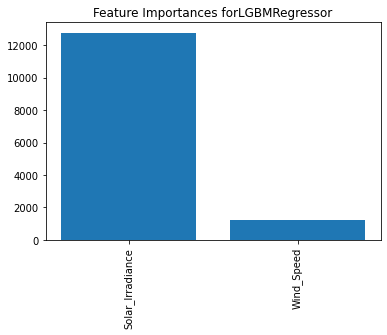

In [ ]:
plot_feat_imp(X_train, best_lgbm)

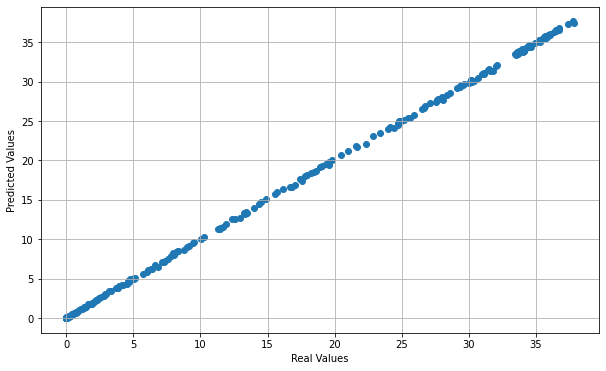

In [ ]:
plot_real_pred(X_test, y_testa, best_lgbm)

## 2. Gradient Boosting Regressor

In [ ]:
grad_params = {'n_estimators':[3000, 5000], 'criterion':['squared_error'], 'min_samples_split':[2], 
              'min_samples_leaf':[1], 'max_depth': [3], 'max_leaf_nodes': [10],
               'learning_rate':[0.05]}

In [ ]:
grid_grad = GridSearchCV(GradientBoostingRegressor(random_state = model_seed), param_grid = grad_params, 
                          scoring= 'neg_root_mean_squared_error', cv= 5,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_grad.fit(X_train, y_traina)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 19.4 s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.05], 'max_depth': [3],
                         'max_leaf_nodes': [10], 'min_samples_leaf': [1],
                         'min_samples_split': [2],
                         'n_estimators': [3000, 5000]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_grad.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'max_leaf_nodes': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 5000}

In [ ]:
grid_grad.best_score_

-0.1915300086625491

### Tuning History

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'max_leaf_nodes': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 3000}

-0.19161785497276798

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 2000}

-0.19192767358160737

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'max_leaf_nodes': 1000,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1500}

-0.19298592040776325

### Getting Final results

In [ ]:
best_grad = grid_grad.best_estimator_

In [ ]:
grad_map = {'Untuned model':GradientBoostingRegressor(), 'Tuned': best_grad}

In [ ]:
compare_tuned(grad_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.07  0.183  0.099  1.0  2.192713e+13  1.336962
1  Untuned model      0.0  0.248  0.142  1.0  2.416287e+13  1.815328

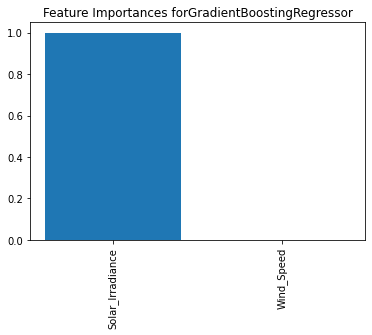

In [ ]:
plot_feat_imp(X_train, best_grad)

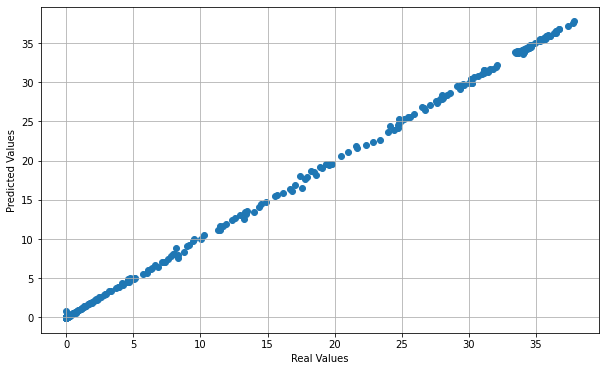

In [ ]:
plot_real_pred(X_test, y_testa, best_grad)

## 3. XGB Regressor

In [ ]:
xgb_params = {'n_estimators':[1000, 1500], 'booster':['gbtree'], 'max_depth':[2,3], 
              'max_leaves':[0], 'colsample_bynode': [1],
               'learning_rate':[0.3], 'reg_lambda':[0.6, 1], 'reg_alpha':[0, 0.05, 0.1],
               'colsample_bytree': [1]}

In [ ]:
grid_xgb = GridSearchCV(XGBRegressor(random_state = model_seed), param_grid = xgb_params, 
                        scoring= 'neg_root_mean_squared_error', cv= 5, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_xgb.fit(X_train, y_traina)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Wall time: 27 s


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'booster': ['g

In [ ]:
grid_xgb.best_params_ 

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 2,
 'max_leaves': 0,
 'n_estimators': 1000,
 'reg_alpha': 0.1,
 'reg_lambda': 1}

In [ ]:
grid_xgb.best_score_

-0.18192192045976863

### Tuning History

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.3,
 'max_depth': 2,
 'max_leaves': 0,
 'n_estimators': 1000,
 'reg_alpha': 0.05,
 'reg_lambda': 0.6}

-0.18283240962275818

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 2,
 'max_leaves': 0,
 'n_estimators': 5000,
 'reg_alpha': 0,
 'reg_lambda': 0.6}

-0.1864575567179877

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 2,
 'max_leaves': 0,
 'n_estimators': 3000,
 'reg_alpha': 0,
 'reg_lambda': 0.6}

-0.1879322273234872

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 2,
 'max_leaves': 0,
 'n_estimators': 2000,
 'reg_alpha': 0,
 'reg_lambda': 0.6}

-0.19017287374753922

{'booster': 'dart',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 3,
 'max_leaves': 0,
 'n_estimators': 1000,
 'reg_alpha': 0,
 'reg_lambda': 0.4}

-0.19977789651466304

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'learning_rate': 0.1,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 400,
 'reg_alpha': 0,
 'reg_lambda': 0.3}

 -0.21065251367419258

### Getting Final results

In [ ]:
best_xgb = grid_xgb.best_estimator_

In [ ]:
xgb_map = {'Untuned model':XGBRegressor(), 'Tuned': best_xgb}

In [ ]:
compare_tuned(xgb_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.01  0.158  0.101  1.0  3.381691e+13  1.157885
1  Untuned model      0.0  0.265  0.143  1.0  6.770562e+12  1.942124

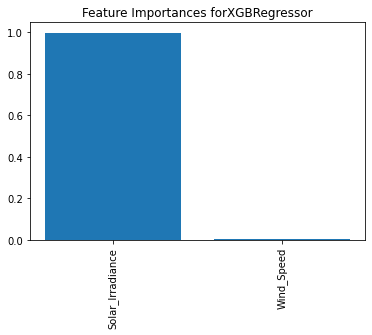

In [ ]:
plot_feat_imp(X_train, best_xgb)

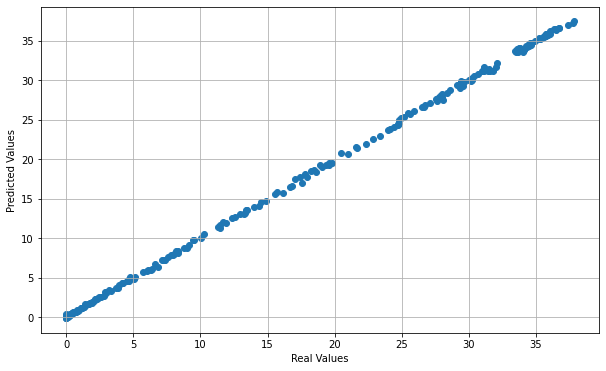

In [ ]:
plot_real_pred(X_test, y_testa, best_xgb)

## 4. Random Forest Regressor

In [ ]:
rf_params = {'n_estimators':[300,500], 'max_depth':[None], 'min_samples_split': [2,3],
             'min_samples_leaf': [1,2], 'max_leaf_nodes':[None, 300]}

In [ ]:
grid_rf = GridSearchCV(RandomForestRegressor(random_state = model_seed ), param_grid = rf_params, 
                       scoring= 'neg_root_mean_squared_error', cv= 5,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_rf.fit(X_train, y_traina)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Wall time: 37.6 s


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_leaf_nodes': [None, 300],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [300, 500]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_rf.best_params_

{'max_depth': None,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [ ]:
grid_rf.best_score_

-0.33271110775670376

### Tuning History

{'max_depth': None,
 'max_leaf_nodes': 500,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

-0.33271110775670376

{'max_depth': None,
 'max_leaf_nodes': 500,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 800}

-0.3744656348191273

### Getting Final results

In [ ]:
best_rf = grid_rf.best_estimator_

In [ ]:
rf_map = {'Untuned model':RandomForestRegressor(), 'Tuned': best_rf}

In [ ]:
compare_tuned(rf_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae   r2   mape     RRMSE
0  Untuned model     0.01  0.291  0.149  1.0  0.017  2.131947
1          Tuned     0.02  0.292  0.148  1.0  0.017  2.133988

There's no visible improvement with Random Forest

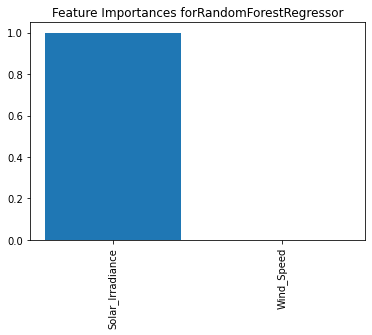

In [ ]:
plot_feat_imp(X_train, best_rf)

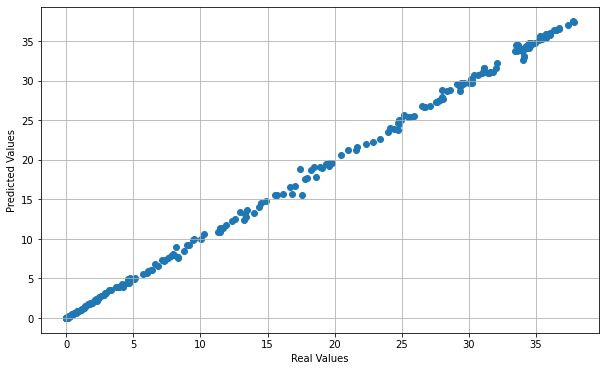

In [ ]:
plot_real_pred(X_test, y_testa, best_rf)

## 5. Bagging Regressor

In [ ]:
bag_params = {'n_estimators':[190, 200, 250],'max_samples':[ 0.8, 0.9, 1],
               'warm_start': [False], 'max_features':[1,2]}

In [ ]:
grid_bag = GridSearchCV(BaggingRegressor(random_state = model_seed), param_grid = bag_params,
                         scoring= 'neg_root_mean_squared_error', cv= 5,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_bag.fit(X_train, y_traina)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Wall time: 24.8 s


GridSearchCV(cv=5, estimator=BaggingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1, 2], 'max_samples': [0.8, 0.9, 1],
                         'n_estimators': [190, 200, 250],
                         'warm_start': [False]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_bag.best_params_

{'max_features': 2,
 'max_samples': 0.9,
 'n_estimators': 200,
 'warm_start': False}

In [ ]:
grid_bag.best_score_

-0.34035784101552025

### Tuning History

{'max_features': 2,
 'max_samples': 0.8,
 'n_estimators': 200,
 'warm_start': False}

-0.345392476322652

{'max_features': 2,
 'max_samples': 0.7,
 'n_estimators': 200,
 'warm_start': False}

-0.35682548954107823

### Getting Final results

In [ ]:
best_bag = grid_bag.best_estimator_

In [ ]:
bag_map = {'Untuned model':BaggingRegressor(), 'Tuned': best_bag}

In [ ]:
compare_tuned(bag_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae     r2   mape     RRMSE
0          Tuned     0.01  0.294  0.149  1.000  0.017  2.150452
1  Untuned model      0.0  0.315  0.158  0.999  0.017  2.306385

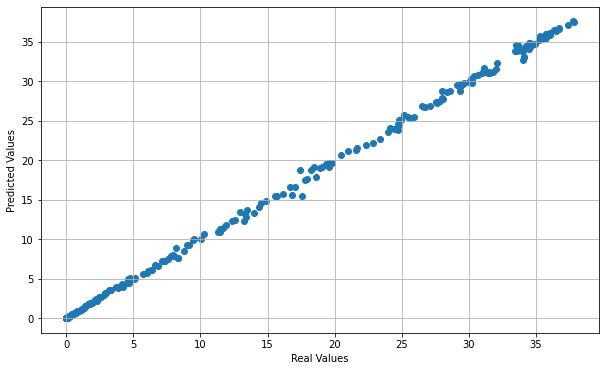

In [ ]:
plot_real_pred(X_test, y_testa, best_bag)

## 6. Support Vector Machine
I think the SVM has a good potential especially when other kernels are tried although in this case a linear kernel isn't bad as the main feature has a good linear relationship with the target.

In [ ]:
x_train_scaledm, x_test_scaledm = scale_datasets(X_training, X_testing, kind ='min')
x_train_scaled, x_test_scaled = scale_datasets(X_training, X_testing)

In [ ]:
X_testing

Solar_Irradiance  Wind_Speed  Ambient_Temp  month  dayofyear       day  \
0            0.951495    0.201411      0.790316    0.0   0.000000  0.000000   
1            0.945723    0.284483      0.784529    0.0   0.002740  0.033333   
2            0.927687    0.239028      0.773727    0.0   0.005479  0.066667   
3            0.928671    0.168495      0.793017    0.0   0.008219  0.100000   
4            0.921213    0.272727      0.766397    0.0   0.010959  0.133333   
..                ...         ...           ...    ...        ...       ...   
360          0.967878    0.294671      0.806520    1.0   0.986301  0.866667   
361          0.967163    0.452978      0.820795    1.0   0.989041  0.900000   
362          0.960892    0.340125      0.834491    1.0   0.991781  0.933333   
363          0.968855    0.478840      0.845679    1.0   0.994521  0.966667   
364          0.971990    0.468652      0.802855    1.0   0.997260  1.000000   

      weekday  weekofyear  
0    0.666667    1.000000  
1    0.833333    1.000000  
2    1.000000    1.000000  
3    0.000000    0.000000  
4    0.166667    0.000000  
..        ...         ...  
360  0.000000    0.980769  
361  0.166667    0.980769  
362  0.333333    0.980769  
363  0.500000    0.980769  
364  0.666667    0.980769  

[365 rows x 8 columns]

In [ ]:
sv = SVR()

In [ ]:
sv.fit(x_train_scaledm[['Solar_Irradiance', 'Wind_Speed']], y_traina)

SVR()

In [ ]:
np.sqrt(mean_squared_error(y_testa, sv.predict(x_test_scaledm[['Solar_Irradiance', 'Wind_Speed']])))

0.6156727292952441

In [ ]:
sv = SVR()

In [ ]:
sv.fit(x_train_scaled[['Solar_Irradiance', 'Wind_Speed']], y_traina)

SVR()

In [ ]:
np.sqrt(mean_squared_error(y_testa, sv.predict(x_test_scaled[['Solar_Irradiance', 'Wind_Speed']])))

0.9824480572267086

### MinMax scaler performed better than Standard Scaler for SVM

In [ ]:
svr_params = {'kernel':['rbf'], 'degree':[1,2], 'C':[900,1000, 1500, 2000, 3000, 5000], 
              'gamma':[1.2,1.25, 1.3, 1.4]} 
              

In [ ]:
grid_svr = GridSearchCV(SVR(), param_grid = svr_params, scoring= 'neg_root_mean_squared_error', cv= 5, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_svr.fit(X_train, y_traina)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Wall time: 12.6 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [900, 1000, 1500, 2000, 3000, 5000],
                         'degree': [1, 2], 'gamma': [1.2, 1.25, 1.3, 1.4],
                         'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_svr.best_params_ 

{'C': 1000, 'degree': 1, 'gamma': 1.3, 'kernel': 'rbf'}

In [ ]:
grid_svr.best_score_

-0.060584727330735264

### Tuning History

{'C': 1000, 'degree': 1, 'gamma': 1.25, 'kernel': 'rbf'}
-0.06370991670598065

{'C': 500, 'degree': 1, 'gamma': 1.25, 'kernel': 'rbf'}
-0.06732201416291216

### Getting Final results

In [ ]:
best_svr = grid_svr.best_estimator_

In [ ]:
svr_map = {'Untuned model':SVR(), 'Tuned': best_svr}

In [ ]:
compare_tuned(svr_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae     r2          mape     RRMSE
0          Tuned      0.0  0.065  0.055  1.000  9.065504e+13  0.473722
1  Untuned model      0.0  0.616  0.246  0.998  2.885659e+14  4.505765

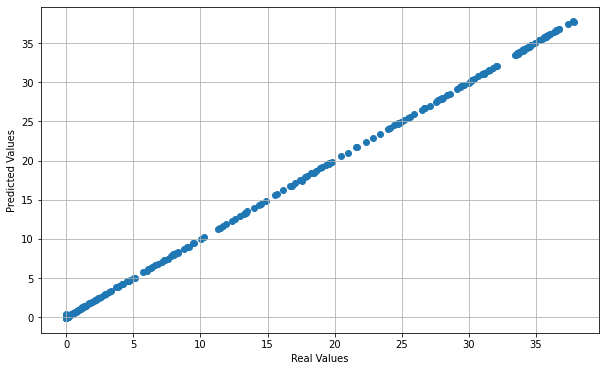

In [ ]:
plot_real_pred(X_test, y_testa, best_svr)

# 7. KNN Regressor

In [ ]:
knn_params = {'n_neighbors':[2,3,4,5,6,7,8,9,10,11,12,13], 'weights':['uniform', 'distance'], 'p':[1,2,3], 
             'metric': ['euclidean', 'manhattan', 'minkowski']} 
              

In [ ]:
grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid = knn_params, scoring= 'neg_root_mean_squared_error', cv= 5, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_knn.fit(X_train, y_traina)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Wall time: 8.11 s


GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13],
                         'p': [1, 2, 3], 'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_knn.best_params_ 

{'metric': 'manhattan', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}

In [ ]:
grid_knn.best_score_

-0.45772989420649335

### Getting Final results

In [ ]:
best_knn = grid_knn.best_estimator_

In [ ]:
knn_map = {'Untuned model':KNeighborsRegressor(), 'Tuned': best_knn}

In [ ]:
compare_tuned(knn_map, X_train, X_test, y_traina, y_testa)

model run_time   rmse    mae     r2          mape     RRMSE
0          Tuned      0.0  0.448  0.252  0.999  1.365865e+13  3.277946
1  Untuned model      0.0  0.458  0.264  0.999  2.850768e+13  3.350433

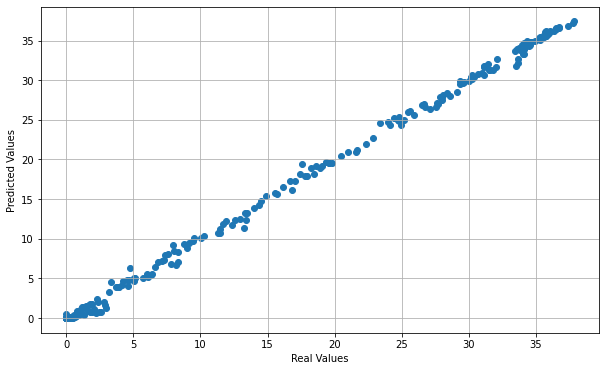

In [ ]:
plot_real_pred(X_test, y_testa, best_knn)

# 8. Artificial Neural Network (ANN)

In [ ]:
hidden_units1 = 384
hidden_units2 = 32
hidden_units3 = 64
hidden_units4 = 96
hidden_units5 = 64
learning_rate = 0.009
# Creating model using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
    tf.keras.Input(shape=(2,)),
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units5, kernel_initializer='normal', activation='relu'),

    Dense(1, kernel_initializer='normal', activation='linear')
  ])
    return model

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15)

In [ ]:
x_train_scaled, x_test_scaled = x_train_scaled[['Solar_Irradiance', 'Wind_Speed']], x_test_scaled[['Solar_Irradiance', 'Wind_Speed']]

In [ ]:
mse = MeanSquaredError()
model = build_model_using_sequential()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[mse]
)
# train the model
history = model.fit(
    x_train_scaled, 
    y_traina, 
    epochs=50, 
    batch_size=32,
    validation_split=0.2, callbacks = [early_stopping]
)

In [ ]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
    
# Plotting the history
plot_history(history, 'mean_squared_error')

In [ ]:
annpr = model.predict(x_test_scaled)

In [ ]:
np.sqrt(mean_squared_error(y_testa, annpr))

## Tuning the Neural Network using Keras Tuner

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  tf.keras.Input(shape=(2,))

  
  for i in range(hp.Int('layer', 2, 15)):
    model.add(Dense(hp.Int('units_'+ str(i), min_value=32, max_value=512, step=32), kernel_initializer='normal',
                    activation='relu'))  

  hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.005])
  
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['mse'])

  return model

In [ ]:
# max trials just says how many combination of hyperparameters should I try, them executions say for each combination, how
# many times should I train on that ? Because for NNs we get different results for the same model

tuner = kt.RandomSearch(model_builder,
                     objective=kt.Objective("val_mse", direction="min"),
                     max_trials=50,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
tuner.search(x_train_scaled.values, y_traina.values, epochs=50, validation_split=0.2, callbacks=[stop_early],
             batch_size =64)

# Getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Building the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_scaled, y_traina, epochs=50, validation_split=0.2, batch_size =64)

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retraining the model
hypermodel.fit(x_train_scaled, y_traina, epochs=best_epoch, validation_split=0.2, batch_size = 64)

In [ ]:
eval_result = hypermodel.evaluate(x_test_scaled, y_testa)
print("[test loss, test mse]:", eval_result)

In [ ]:
hypermodel.summary()

In [ ]:
#hypermodel.save('best_power.h5')

## I got the best result after tuning and saved it. That's what was used below.

<a name="summary_power"></a>
## 14. Summary and Conclusions for Efficiency

In [ ]:
def visualize_pred(X_train, X_test, y_train, y_test, train_pr, test_pr, model):
    '''Plots the predicted and real values overtime'''
    plt.figure(figsize = (12,8))
    plt.plot(X_train.Date, y_train, color = 'b', label = 'Real')
    plt.plot(X_train.Date, train_pr, color = 'r', label = model)
    plt.text(pd.to_datetime('04/25/2019'),30, 'Training Data', fontsize = 14)
    plt.text(pd.to_datetime('04/25/2021'),30, 'Testing Data', fontsize = 14)

    plt.plot(X_test.Date, y_test, color = 'b')
    plt.plot(X_test.Date, test_pr, color = 'r')
    plt.axvline(X_test.Date.min(), color= 'k', ls = '--')
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Power Output (W)', fontsize = 14)
    
    plt.legend()
    #plt.savefig('pred'+model+'.jpg', dpi = 300)
    plt.show()
    

In [ ]:
def total_report(model_map, X_traindate, X_testdate, X_train, X_test, X_trainsc, X_testsc, y_train, y_test ):
    df_models = pd.DataFrame(columns=['model', 'Time', 'MSE', 'RMSE', 'MAE', 'r2', 'mape', 'RRMSE', 'Error'])

    for a, key in enumerate(model_map):
        if key == 'ANN':
            regressor = model_map[key]
            start_time = time.time()
            regressor.fit(X_trainsc, y_train, epochs=50, batch_size= 32)
            end_time = time.time()
            y_pred_tr = regressor.predict(X_trainsc)
            start_time_pr = time.time()
            y_pred_te = regressor.predict(X_testsc)
            end_time_pr = time.time()
        else:
            regressor = model_map[key]
            start_time = time.time()
            regressor.fit(X_train, y_train)
            end_time = time.time()
            y_pred_tr = regressor.predict(X_train)
            start_time_pr = time.time()
            y_pred_te = regressor.predict(X_test)
            end_time_pr = time.time()
            
        # metrics
        train_time = end_time - start_time
        pr_time = end_time_pr - start_time_pr
        #print(pr_time, train_time)
        #tr_te = ['train', 'test']
        rmse = [np.sqrt(mean_squared_error(y_train, y_pred_tr)),  np.sqrt(mean_squared_error(y_test, y_pred_te))] 
        mse = [mean_squared_error(y_train, y_pred_tr), mean_squared_error(y_test, y_pred_te)]
        mae = [mean_absolute_error(y_train, y_pred_tr), mean_absolute_error(y_test, y_pred_te)]
        r2 = [r2_score(y_train, y_pred_tr), r2_score(y_test, y_pred_te)]
        mape = [mean_absolute_percentage_error(y_train, y_pred_tr), mean_absolute_percentage_error(y_test, y_pred_te)]
        rrmse = [np.sqrt((mean_squared_error(y_train, y_pred_tr)/mean_squared_error(y_train, 
                                                                                    [np.mean(y_train)]*len(y_train))))*100,
                 np.sqrt((mean_squared_error(y_test, y_pred_te)/mean_squared_error(y_test, [np.mean(y_test)]*len(y_test))))*100]

        
        row_tr = {'model': key,
           'Time_trte': train_time,
            'MSE':mse[0],
           'RMSE': rmse[0],
            'MAE':mae[0],
            'r2': r2[0],
            'mape': mape[0] ,
            'RRMSE': rrmse[0],
            'Error': 'Train',
            'Time': 'Training'
        }
                      
        row_te = {'model': key,
           'Time_trte': pr_time,
            'MSE':mse[1],
           'RMSE': rmse[1],
            'MAE':mae[1],
            'r2': r2[1],
            'mape': mape[1] ,
            'RRMSE': rrmse[1],
            'Error': 'Test',
             'Time': 'Testing'
        }
        visualize_pred(X_traindate, X_testdate, y_train, y_test, y_pred_tr, y_pred_te, key)
        df_models = df_models.append(row_tr, ignore_index=True)
        df_models = df_models.append(row_te, ignore_index=True)
                                                                    
    # dispaying the top 5 models wrt rmse
    display(df_models)
    sorted_df = df_models.sort_values(['RMSE', 'Error'], ascending = False).iloc[:,:].reset_index(drop = True)
    sorted_df = round(sorted_df, 3)
    display(sorted_df)
    display_metrics = ['MSE', 'RMSE', 'MAE', 'RRMSE', 'Time_trte']
    for metric in display_metrics:
        if metric == 'Time_trte':
            palette = {'Training':'red', 'Testing':'green'}
            sorted_df = df_models.sort_values(['Time_trte', 'Time'], ascending = False).iloc[:,:].reset_index(drop = True)
            sorted_df = round(sorted_df, 3)
            plt.figure(figsize = (12,8))
            ax0 = sns.barplot(x= 'model', y=metric, data= sorted_df, hue= 'Time', palette= palette ) 
            plt.ylabel('Time (s)', fontsize = 13)
            plt.xlabel('Model', fontsize = 13)
            plt.title('Training and Testing Time for Eight Supervised Learning Models', fontsize = 15)
            for container in ax0.containers:
                ax0.bar_label(container)
            #plt.savefig('metric'+metric+'.jpg', dpi = 300)
            plt.show()
        else:
            plt.figure(figsize = (12,8))
            ax0 = sns.barplot(x= 'model', y=metric, data= sorted_df, hue= 'Error', )
            plt.ylabel(metric, fontsize = 13)
            plt.xlabel('Model', fontsize = 13)
            #plt.title(metric + ' for Eight Supervised Learning Models', fontsize = 15)
            for container in ax0.containers:
                ax0.bar_label(container)
            #plt.savefig('metric'+metric+'.jpg', dpi = 300)
            plt.show()
                                                                            

In [ ]:
tf.random.set_seed(2000)
load_mod = tf.keras.models.load_model('Saved_Neural_Nets/best_power.h5')
#load_mod.fit(x_train_scaled, y_traina, epochs=50, batch_size= 32)

In [ ]:
#np.sqrt(mean_squared_error(y_testa, load_mod.predict(x_test_scaled)))

In [ ]:
# best models map
best_regressors = {
    'LGBM': best_lgbm,
    'XGB':best_xgb,
    'RandomForest': best_rf,
    'GradientBoosting': best_grad,
    'Bagging': best_bag,
    'SVR': best_svr,
    'KNN': best_knn,
    'ANN': load_mod
}

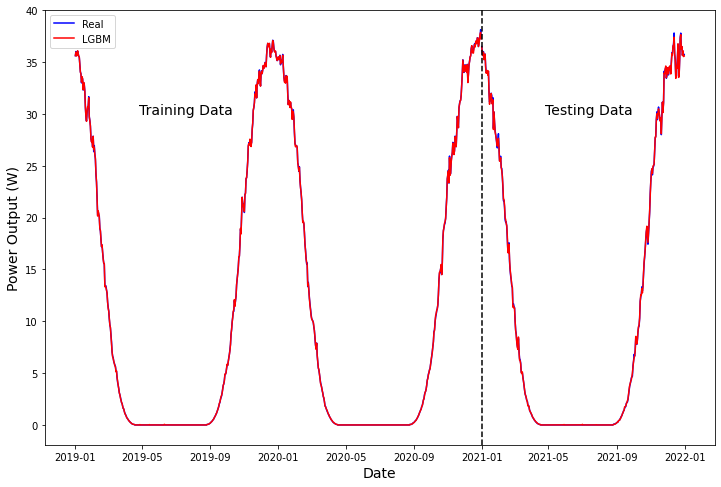

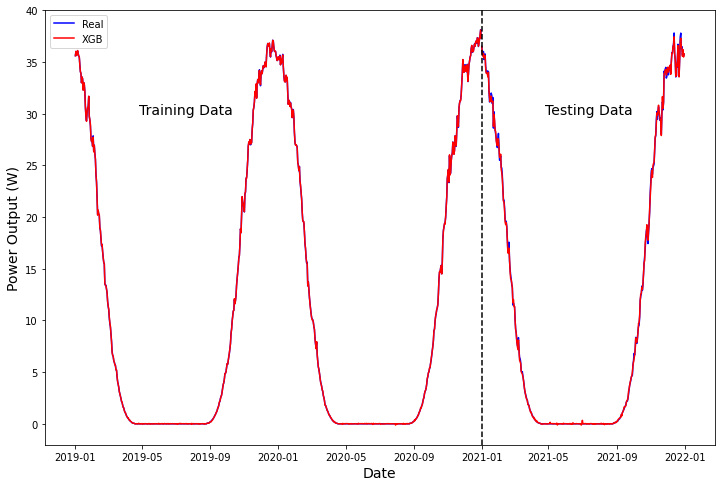

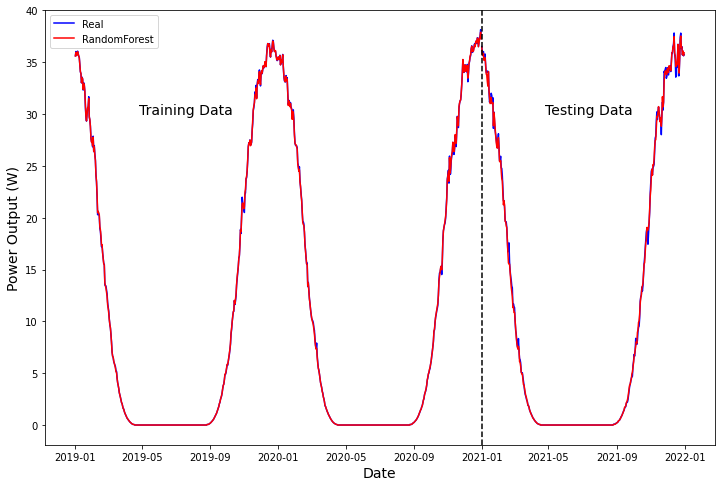

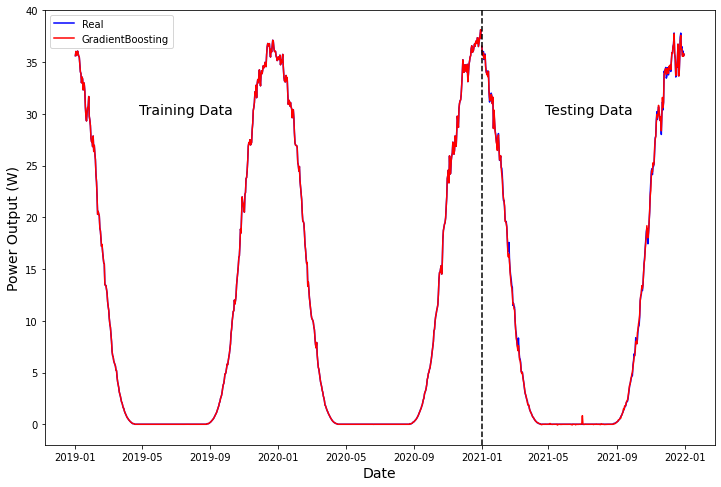

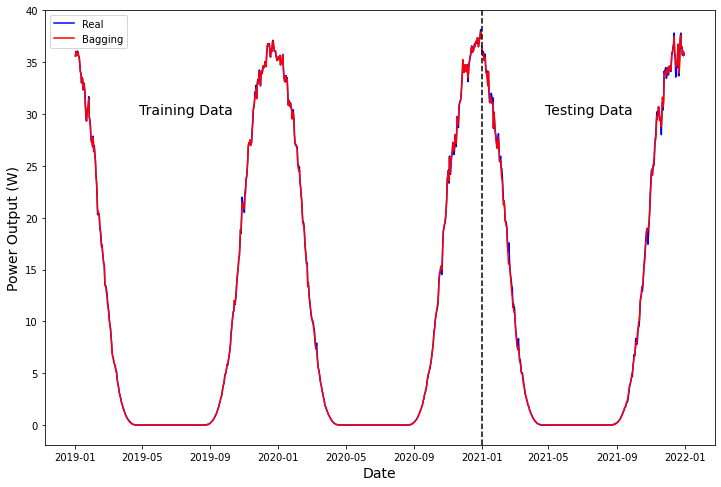

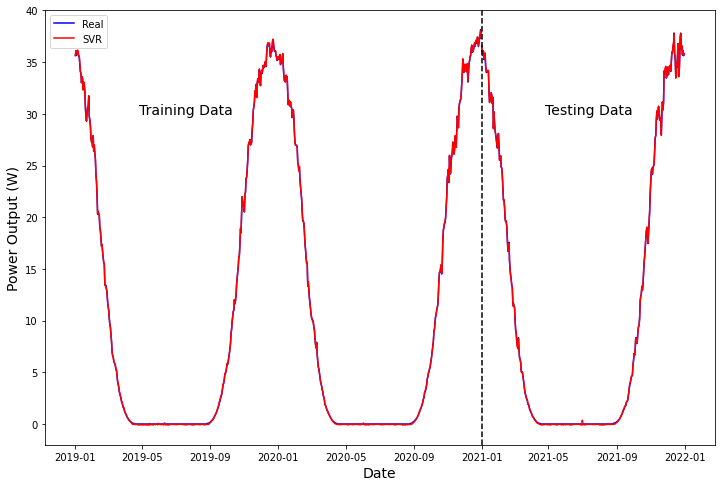

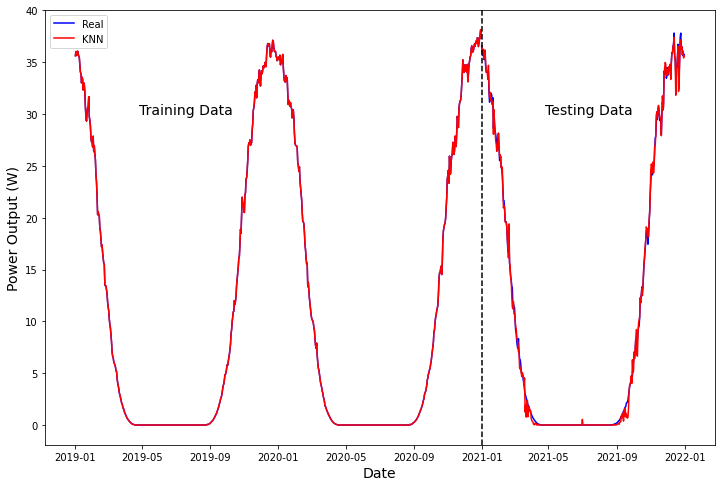

Epoch 1/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 2/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0178 - mean_squared_error: 0.0178
Epoch 3/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0350 - mean_squared_error: 0.0350
Epoch 4/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0288 - mean_squared_error: 0.0288
Epoch 5/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0373 - mean_squared_error: 0.0373
Epoch 6/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0523 - mean_squared_error: 0.0523
Epoch 7/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0676 - mean_squared_error: 0.0676
Epoch 8/50
23/23 [==============================] - 0s 3ms/step - loss: 0.0145 - mean_squared_error: 0.0145
Epoch 9/50
23/23 [==============================] - 0s 4ms/step - loss: 0.0171 - mean_squared_error: 0.0171
Epoch 10/50
23/23 [=========

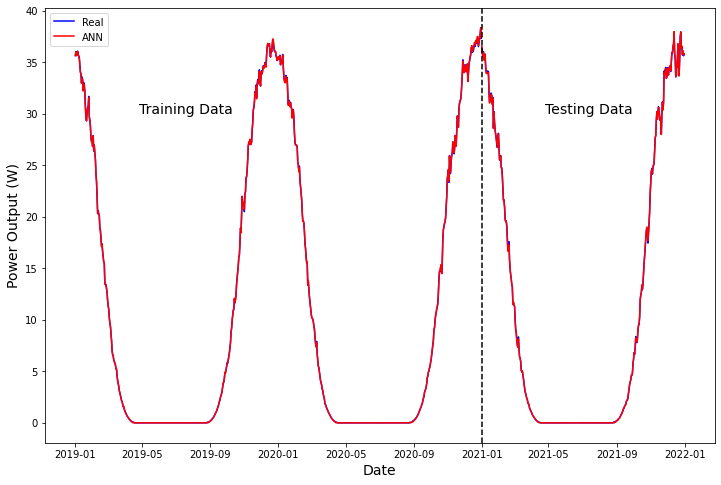

model      Time       MSE      RMSE       MAE        r2  \
0               LGBM  Training  0.003442  0.058671  0.035393  0.999982   
1               LGBM   Testing  0.010209  0.101038  0.061837  0.999945   
2                XGB  Training  0.001758  0.041934  0.028449  0.999991   
3                XGB   Testing  0.025032  0.158215  0.101215  0.999866   
4       RandomForest  Training  0.009054  0.095152  0.048570  0.999952   
5       RandomForest   Testing  0.085025  0.291591  0.148024  0.999545   
6   GradientBoosting  Training  0.000002  0.001364  0.000976  1.000000   
7   GradientBoosting   Testing  0.033373  0.182684  0.098850  0.999821   
8            Bagging  Training  0.011570  0.107565  0.054407  0.999939   
9            Bagging   Testing  0.086342  0.293840  0.149206  0.999538   
10               SVR  Training  0.003344  0.057828  0.051359  0.999982   
11               SVR   Testing  0.004190  0.064730  0.055133  0.999978   
12               KNN  Training  0.000000  0.000000  0.000000  1.000000   
13               KNN   Testing  0.200616  0.447902  0.252325  0.998926   
14               ANN  Training  0.002817  0.053078  0.033340  0.999985   
15               ANN   Testing  0.003475  0.058948  0.036926  0.999981   

            mape     RRMSE  Error  Time_trte  
0   3.683191e+12  0.426833  Train  10.035510  
1   4.817167e+12  0.739444   Test   0.097000  
2   2.038658e+13  0.305069  Train   0.703222  
3   3.381691e+13  1.157885   Test   0.009001  
4   5.608760e-03  0.692233  Train   1.420999  
5   1.706421e-02  2.133988   Test   0.087001  
6   1.290373e+12  0.009926  Train   4.252432  
7   2.192713e+13  1.336962   Test   0.029009  
8   6.209174e-03  0.782537  Train   0.556562  
9   1.689213e-02  2.150452   Test   0.030996  
10  8.626453e+13  0.420697  Train   0.112548  
11  9.065504e+13  0.473722   Test   0.005417  
12  0.000000e+00  0.000000  Train   0.006997  
13  1.365865e+13  3.277946   Test   0.005001  
14  3.433649e+12  0.386146  Train   4.718594  
15  3.922760e+12  0.431408   Test   0.060001

model      Time    MSE   RMSE    MAE     r2          mape  \
0                KNN   Testing  0.201  0.448  0.252  0.999  1.365865e+13   
1            Bagging   Testing  0.086  0.294  0.149  1.000  1.700000e-02   
2       RandomForest   Testing  0.085  0.292  0.148  1.000  1.700000e-02   
3   GradientBoosting   Testing  0.033  0.183  0.099  1.000  2.192713e+13   
4                XGB   Testing  0.025  0.158  0.101  1.000  3.381691e+13   
5            Bagging  Training  0.012  0.108  0.054  1.000  6.000000e-03   
6               LGBM   Testing  0.010  0.101  0.062  1.000  4.817167e+12   
7       RandomForest  Training  0.009  0.095  0.049  1.000  6.000000e-03   
8                SVR   Testing  0.004  0.065  0.055  1.000  9.065504e+13   
9                ANN   Testing  0.003  0.059  0.037  1.000  3.922760e+12   
10              LGBM  Training  0.003  0.059  0.035  1.000  3.683191e+12   
11               SVR  Training  0.003  0.058  0.051  1.000  8.626453e+13   
12               ANN  Training  0.003  0.053  0.033  1.000  3.433649e+12   
13               XGB  Training  0.002  0.042  0.028  1.000  2.038658e+13   
14  GradientBoosting  Training  0.000  0.001  0.001  1.000  1.290373e+12   
15               KNN  Training  0.000  0.000  0.000  1.000  0.000000e+00   

    RRMSE  Error  Time_trte  
0   3.278   Test      0.005  
1   2.150   Test      0.031  
2   2.134   Test      0.087  
3   1.337   Test      0.029  
4   1.158   Test      0.009  
5   0.783  Train      0.557  
6   0.739   Test      0.097  
7   0.692  Train      1.421  
8   0.474   Test      0.005  
9   0.431   Test      0.060  
10  0.427  Train     10.036  
11  0.421  Train      0.113  
12  0.386  Train      4.719  
13  0.305  Train      0.703  
14  0.010  Train      4.252  
15  0.000  Train      0.007

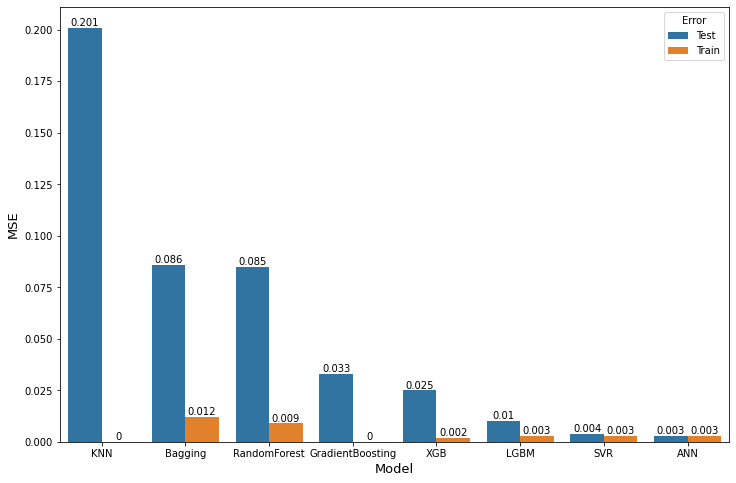

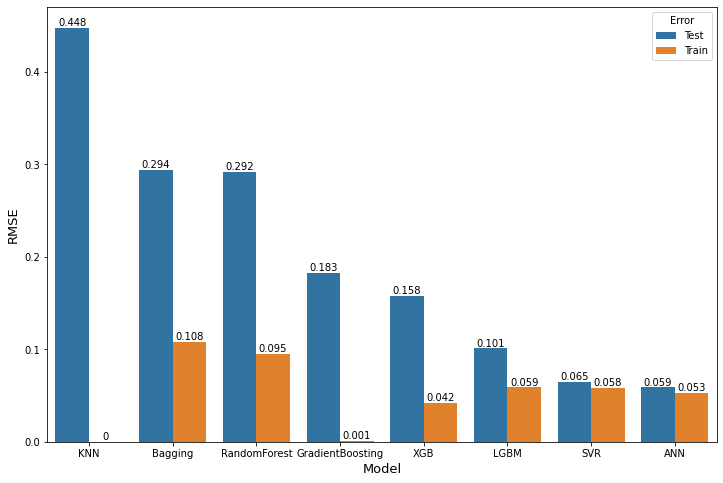

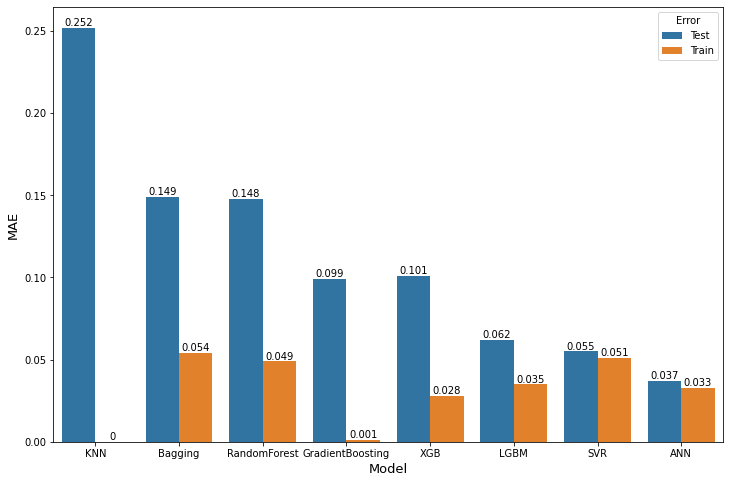

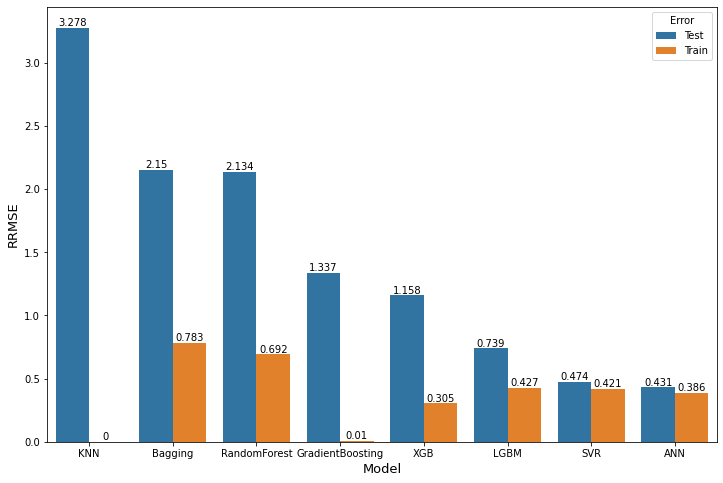

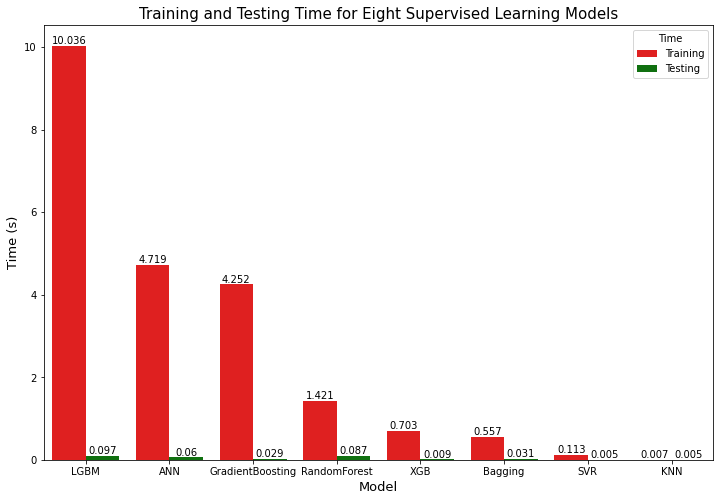

In [ ]:
total_report(best_regressors, X_traina, X_testa, X_train, X_test, x_train_scaled, x_test_scaled, y_traina, y_testa)

In [ ]:
load_mod.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 64)                192       
_________________________________________________________________
dense_21 (Dense)             (None, 480)               31200     
_________________________________________________________________
dense_22 (Dense)             (None, 160)               76960     
_________________________________________________________________
dense_23 (Dense)             (None, 288)               46368     
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 289       
Total params: 155,009
Trainable params: 155,009
Non-trainable params: 0
_________________________________________________________________


# Conclusion

1. An ANN with 4 fully connected layers with the relu activation function gave the lowest results of rmse of 0.059, mae of	0.037, r2 score of 1.000 and rrmse of 0.431.
2. SVR came second with rmse of 0.065, mae of 0.055, r2 score of 1 and RRMSE of 0.474 on the test set.
3. The training and testing speed recorded here is from a laptop running on intel core i5  @2.4ghz clock speed with quadcore processor and 16gb ram. Definitely a GPU or a more advanced system with better processing power will train faster.
3. Wind speed was more important than ambient temp used together with solar irradiance (only these two features were used for all models) I think because it provided more space in the dimensional plot. Tree based models basically do logical splits and then take a mean. For categories found using wind speed with irradiance, there's freer points. See [EDA above](#above)
5. The tuned KNN, bagging, gradient boosting and random forest overfitted on the training set.
6. LGBM had the highest training time followed by the ANN.

### Resizing Images

In [ ]:
direc = os.listdir('predict')
for img in direc:
        # Here, I open all pictures, resize and save  
    image = Image.open(img)
    print('Resizing '+img+ '...')
    new_image = image.resize((4667, 3500))
    new_image.save('resized_'+img, dpi = (300, 300))
    print('Completed \n')

<a name="eff"></a>
## 15. EDA for Efficiency feature

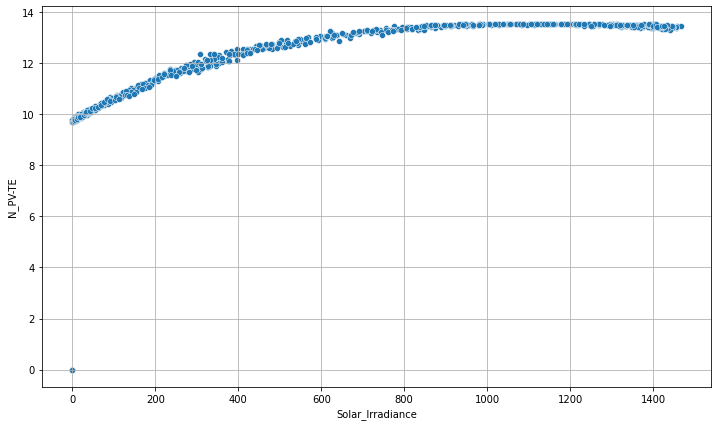

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Solar_Irradiance', y='N_PV-TE', data = antarctica_df)
plt.grid()

Observation

1. We notice that from around 800 w/m2 of solar Irradiance, the values remain constant, basically there's a limit to the efficiency.
2. When solar Irradiance is 0, that's the only time there's 0 efficiency as long as Irradiance takes a value > 0 there's always efficiency.
3. Minimum efficiency after 0 is around 10 so for all working panels, there's a minimum efficiency of around 10%
4. The 0 days are actually outliers.

In [ ]:
# Doing some analysis on 0 days
antarctica_df[antarctica_df['Solar_Irradiance'] <= 0]

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp  P_PV-TE  N_PV-TE  \
108 2019-04-18               0.0        7.04        231.83      0.0      0.0   
109 2019-04-19               0.0        9.23        225.50      0.0      0.0   
110 2019-04-20               0.0       10.96        225.41      0.0      0.0   
111 2019-04-21               0.0       10.69        226.51      0.0      0.0   
112 2019-04-22               0.0        7.55        231.76      0.0      0.0   
..         ...               ...         ...           ...      ...      ...   
964 2021-08-21               0.0        9.48        212.77      0.0      0.0   
965 2021-08-22               0.0        9.16        212.39      0.0      0.0   
966 2021-08-23               0.0        9.39        214.55      0.0      0.0   
967 2021-08-24               0.0       10.26        216.65      0.0      0.0   
968 2021-08-25               0.0        9.85        217.03      0.0      0.0   

    power_bin eff_bin  month  dayofyear  day  weekday  weekofyear Temperature  
108    lowest  lowest      4        108   18        3          16      lowest  
109    lowest  lowest      4        109   19        4          16      lowest  
110    lowest  lowest      4        110   20        5          16      lowest  
111    lowest  lowest      4        111   21        6          16      lowest  
112    lowest  lowest      4        112   22        0          17      lowest  
..        ...     ...    ...        ...  ...      ...         ...         ...  
964    lowest  lowest      8        233   21        5          33      lowest  
965    lowest  lowest      8        234   22        6          33      lowest  
966    lowest  lowest      8        235   23        0          34      lowest  
967    lowest  lowest      8        236   24        1          34      lowest  
968     lower     low      8        237   25        2          34      lowest  

[391 rows x 14 columns]

In [ ]:
antarctica_df[np.logical_and(antarctica_df['Solar_Irradiance'] <= 0.1, antarctica_df['N_PV-TE'] > 0)]

Date  Solar_Irradiance  Wind_Speed  Ambient_Temp   P_PV-TE  \
107 2019-04-17            0.0759        8.82        230.86  0.033703   
603 2020-08-25            0.0549       11.75        220.08  0.061181   

      N_PV-TE power_bin eff_bin  month  dayofyear  day  weekday  weekofyear  \
107  9.794357    lowest  lowest      4        107   17        2          16   
603  9.709169    lowest  lowest      8        238   25        1          35   

    Temperature  
107      lowest  
603      lowest

When solar irradiance is 0, efficiency is always 0, so 2021-08-25 is an outlier day. (This data was already removed from the dataset)

<a name="logt"></a>
### 16. Log transform on Solar Irradiance

(array([475.,  37.,  31.,  23.,  26.,  19.,  24.,  17.,  18.,  16.,  15.,
         14.,  19.,  12.,  13.,  15.,  14.,  17.,  12.,  14.,  19.,  17.,
         21.,  21.,  21.,  18.,  22.,  39.,  49.,  38.]),
 array([   0.     ,   48.90717,   97.81434,  146.72151,  195.62868,
         244.53585,  293.44302,  342.35019,  391.25736,  440.16453,
         489.0717 ,  537.97887,  586.88604,  635.79321,  684.70038,
         733.60755,  782.51472,  831.42189,  880.32906,  929.23623,
         978.1434 , 1027.05057, 1075.95774, 1124.86491, 1173.77208,
        1222.67925, 1271.58642, 1320.49359, 1369.40076, 1418.30793,
        1467.2151 ]),
 <BarContainer object of 30 artists>)

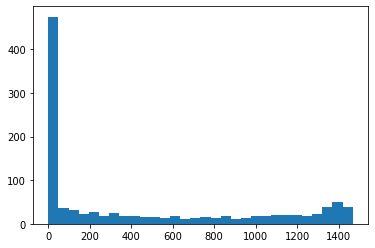

In [ ]:
# The solar Irradiance distribution is skewed it will affect linear models
plt.hist(antarctica_df[['Solar_Irradiance']], bins=30)

In [ ]:
def log(val):
    return math.log(val, 10)

# log transforming solar irrad
antarctica_df['new_solar'] = antarctica_df.Solar_Irradiance+1
antarctica_df['irrad_log'] = antarctica_df.new_solar.apply(log)


(array([395.,   2.,   4.,   1.,   3.,   4.,   3.,   3.,   6.,   5.,   6.,
          5.,   8.,   7.,  11.,  11.,  11.,  14.,  14.,  18.,  21.,  23.,
         27.,  31.,  35.,  40.,  43.,  59.,  90., 196.]),
 array([0.        , 0.10555966, 0.21111931, 0.31667897, 0.42223862,
        0.52779828, 0.63335794, 0.73891759, 0.84447725, 0.95003691,
        1.05559656, 1.16115622, 1.26671587, 1.37227553, 1.47783519,
        1.58339484, 1.6889545 , 1.79451416, 1.90007381, 2.00563347,
        2.11119312, 2.21675278, 2.32231244, 2.42787209, 2.53343175,
        2.63899141, 2.74455106, 2.85011072, 2.95567037, 3.06123003,
        3.16678969]),
 <BarContainer object of 30 artists>)

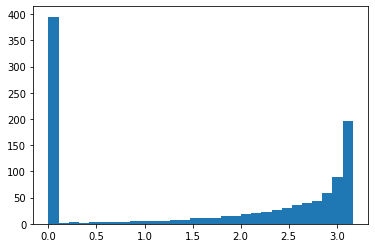

In [ ]:
plt.hist(antarctica_df[['irrad_log']], bins=30)

<AxesSubplot: xlabel='Ambient_Temp', ylabel='N_PV-TE'>

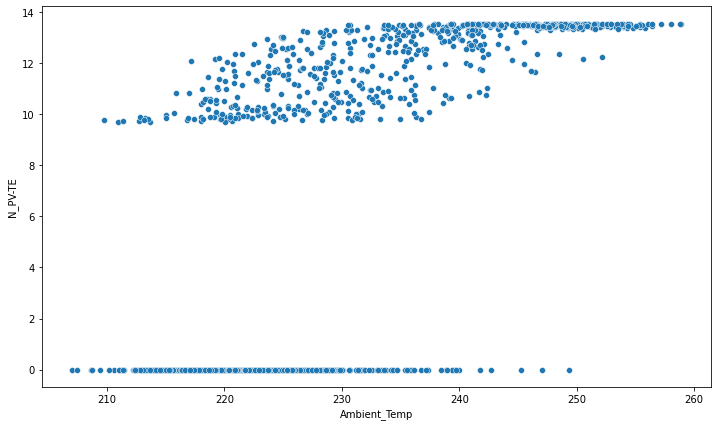

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Ambient_Temp', y='N_PV-TE', data = antarctica_df)

Observation
1. Unlike in Solar Irradiance, the efficiency can take a value of 0 even when the ambient temperature isn't 0.

<AxesSubplot: xlabel='Wind_Speed', ylabel='N_PV-TE'>

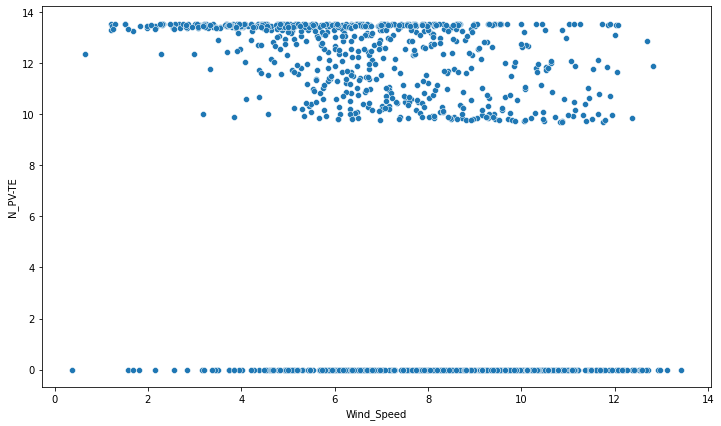

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Wind_Speed', y='N_PV-TE', data = antarctica_df)

From these we see that Solar Irradiance is a Key feature towards predicting both power output and efficiency

<a name = 'sect' a></a>
## EDA with Efficiency Binned

In [ ]:
antarctica_df.groupby('eff_bin')['N_PV-TE'].mean()

eff_bin
lowest      1.096433
lower      10.148221
low        10.504892
mediest    11.546426
medium     12.407192
mid        13.008862
high       13.365793
higher     13.458112
highest    13.501728
peak       13.535902
Name: N_PV-TE, dtype: float64

<AxesSubplot: xlabel='Ambient_Temp', ylabel='irrad_log'>

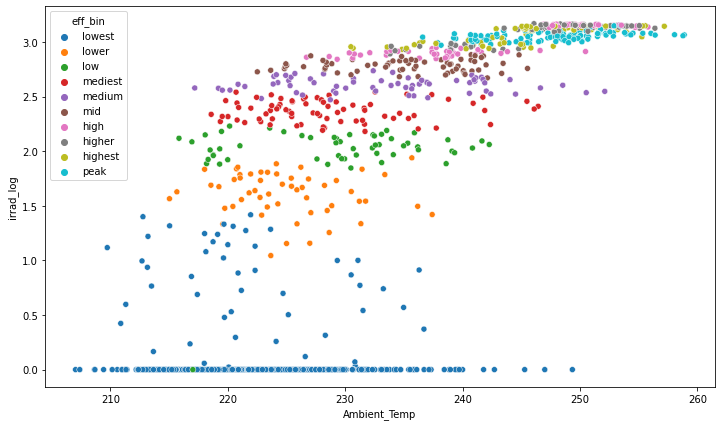

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Ambient_Temp', y='irrad_log', data = antarctica_df, hue='eff_bin')

<AxesSubplot: xlabel='Wind_Speed', ylabel='irrad_log'>

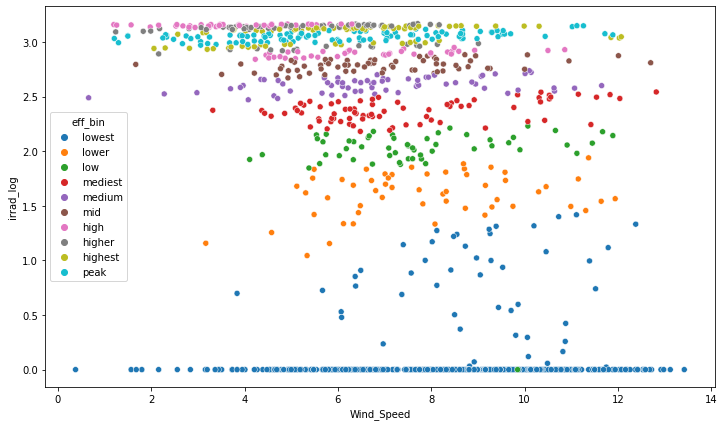

In [ ]:
plt.figure(figsize= (12,7))
sns.scatterplot(x='Wind_Speed', y='irrad_log', data = antarctica_df, hue='eff_bin')

# Why KNN will perform poorly 
Using any of the other features with solar irrad, knn seems to be horizontally binned now, if we scale both y and x axis knn won't realize that it should take horizontal closeness. To make the nearest neighbours considered horizontally, that could be achieved by scaling the wind speed axis and leaving the Solar axis unscaled.

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

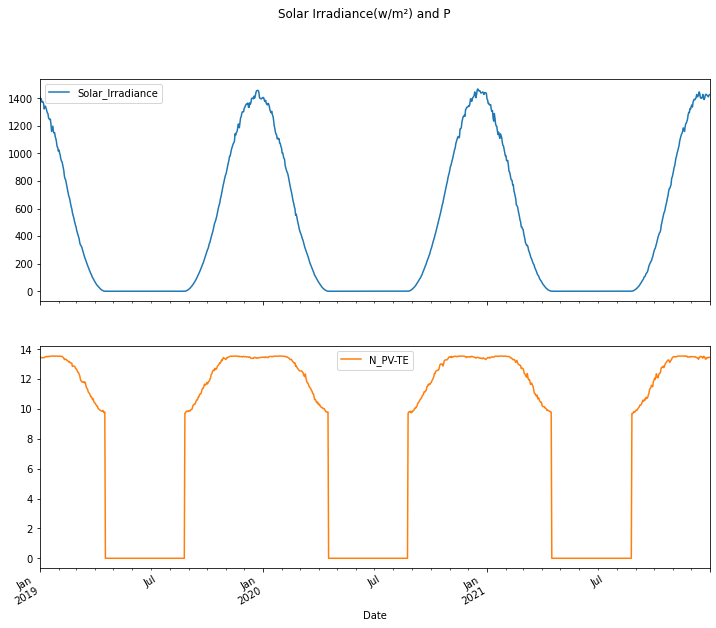

In [ ]:
# Comparing Seasonality and stationarity of Irradiance to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Solar_Irradiance', 'N_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Solar Irradiance(w/m²) and P', figsize = (12,10))


Observations
1. The Values are seasonal and stationary although we see that there are no varying values (no roughness in plot) after 0 till around 10. But the peaks occur at similar times. Again this explains the relationship we saw earlier

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

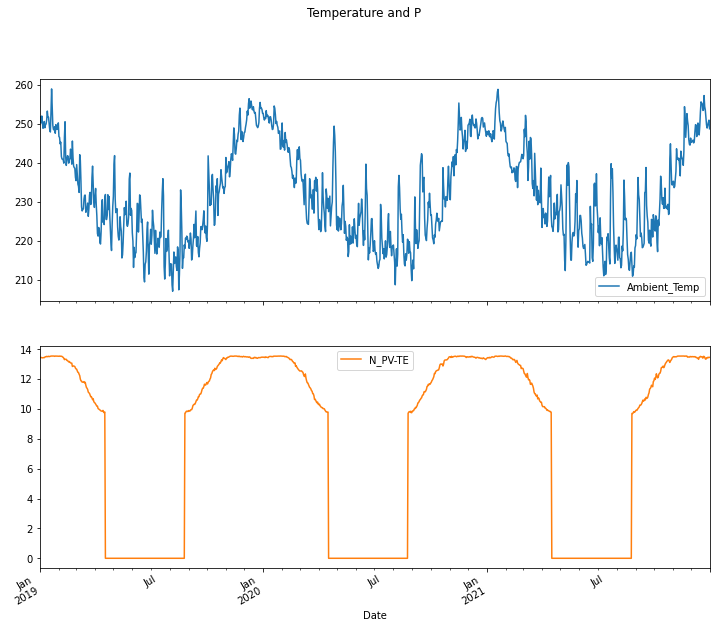

In [ ]:
# Comparing Seasonality of Temperature to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Ambient_Temp', 'N_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Temperature and P', figsize = (12,10))

array([<AxesSubplot: xlabel='Date'>, <AxesSubplot: xlabel='Date'>],
      dtype=object)

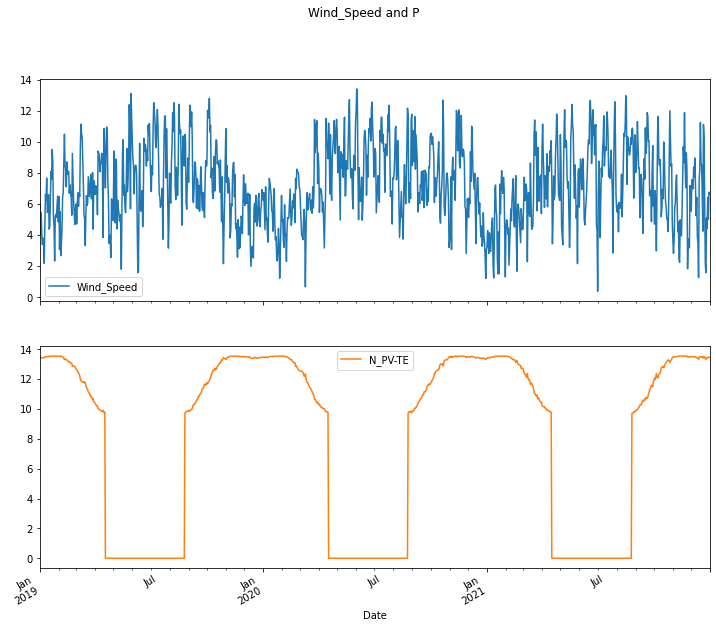

In [ ]:
# Comparing trend of Wind Speed to the target Variable

sub = antarctica_df.copy()
sub = sub[['Date', 'Wind_Speed', 'N_PV-TE']]
sub.set_index('Date', inplace= True)
sub.plot(subplots = True, title = 'Wind_Speed and P', figsize = (12,10))


<a name="outlier" ></a>
### 17. Outlier detection and removal
(This was handled above) [here](#outlier_handled)

In [ ]:
# I scaled down solar Irradiance to make the plot below
antarctica_df['irr_scaled'] = antarctica_df.Solar_Irradiance/(antarctica_df.Solar_Irradiance.max()/14)+0.1

In [ ]:
# day of year and efficiency
plt.figure(figsize= (12,7))
sns.scatterplot(x='dayofyear', y='N_PV-TE', data = antarctica_df)

# scaling down the Solar Irradiance to be between 0-10 to make good comparison with efficiency
sns.scatterplot(x='dayofyear', y='irr_scaled', data = antarctica_df)
plt.grid()

Observations
1. The plot above brings out the relationship of efficiency each year, this is basically the diagram at the peaks we see that at the last 60 days of the year and the first 40 days, we have a constant efficiency and that's also the period where irradiance is highest. And when irradiance drops to 0, efficiency drops to 0
2. From the plots above, we notice an outlier at around august 2021, the efficiency value was higher than usual, I'll be removing that.

In [ ]:
# on inspection above I noticed it was on the 25th August
antarctica_df = antarctica_df[antarctica_df.Date != '2021-08-25']

In [ ]:
# replotting
plt.figure(figsize= (12,7))
sns.scatterplot(x='dayofyear', y='N_PV-TE', data = antarctica_df)

sns.scatterplot(x='dayofyear', y='irr_scaled', data = antarctica_df)
plt.grid()

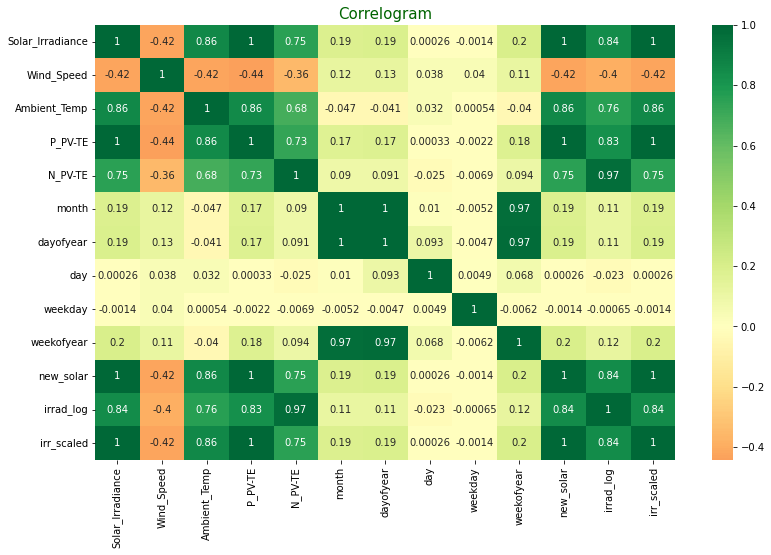

In [ ]:
# Correlation Heatmap
corr = antarctica_df.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

Observations
1. We notice the highest correlation of efficiency with log transform of Solar Irradiance 

In [ ]:
antarctica_dfe = antarctica_df.copy()[['irrad_log', 'Wind_Speed', 'Ambient_Temp', 'dayofyear', 'weekofyear', 'month', 'day',
                                       'weekday', 'N_PV-TE', 'Date']]

In [ ]:
n_train = antarctica_dfe.shape[0] - round(antarctica_dfe.shape[0]*0.333)
n_train

731

In [ ]:
X_train1 = antarctica_dfe.drop(['N_PV-TE'], axis= 1).iloc[:n_train, :]
y_traine = antarctica_dfe[['N_PV-TE']].iloc[:n_train, :]

X_test1 = antarctica_dfe.drop(['N_PV-TE'], axis= 1).iloc[n_train:, :]
y_teste = antarctica_dfe[['N_PV-TE']].iloc[n_train:, :]

In [ ]:
X_traine = X_train1.drop('Date', axis = 1)
X_teste = X_test1.drop('Date', axis = 1)

In [ ]:
X_test1.Date.min()

Timestamp('2021-01-01 00:00:00')

In [ ]:
X_traine, X_teste = scale_datasets(X_traine, X_teste, kind ='min')

In [ ]:
regressors_e = {
    'LGBM': LGBMRegressor(random_state=1),
    'Linear_regression':LinearRegression(),
    'Ridge': Ridge(),
    'XGB': XGBRegressor(random_state = 66),
    'cat': CatBoostRegressor(random_state = 77),
    'RandomForest': RandomForestRegressor(random_state = 99),
    'Decision Tree': DecisionTreeRegressor(random_state = 12),
    'Adaboost': AdaBoostRegressor(random_state= 40),
    'Gboosting': GradientBoostingRegressor(random_state= 42)
}
for mods in regressors_e:
    recurse(X_traine, y_traine, regressors_e[mods])

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Optimal Number of features for LGBMRegressor is: 3
['irrad_log' 'Wind_Speed' 'dayofyear']
[-2.37777157e+01 -1.24084743e-03 -1.17494845e-03 -1.29966691e-03
 -1.48366778e-03 -1.49082242e-03 -1.49601506e-03 -1.49093738e-03] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Optimal Number of features for LinearRegression is: 2
['irrad_log' 'Ambient_Temp']
[-2.55748587 -2.49367167 -2.85291832 -3.36494909 -3.15462582 -3.06771672
 -3.06927954 -5.80681913] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Optimal Number of features for Ridge is: 4
['irrad_log' 'Wind_Speed'

184:	learn: 0.1276007	total: 440ms	remaining: 1.94s
185:	learn: 0.1267767	total: 443ms	remaining: 1.94s
186:	learn: 0.1262828	total: 446ms	remaining: 1.94s
187:	learn: 0.1252682	total: 448ms	remaining: 1.93s
188:	learn: 0.1242374	total: 450ms	remaining: 1.93s
189:	learn: 0.1238521	total: 453ms	remaining: 1.93s
190:	learn: 0.1232626	total: 456ms	remaining: 1.93s
191:	learn: 0.1226838	total: 458ms	remaining: 1.93s
192:	learn: 0.1219038	total: 461ms	remaining: 1.93s
193:	learn: 0.1215803	total: 463ms	remaining: 1.92s
194:	learn: 0.1212135	total: 466ms	remaining: 1.92s
195:	learn: 0.1204646	total: 468ms	remaining: 1.92s
196:	learn: 0.1202046	total: 471ms	remaining: 1.92s
197:	learn: 0.1194710	total: 473ms	remaining: 1.92s
198:	learn: 0.1193058	total: 477ms	remaining: 1.92s
199:	learn: 0.1191642	total: 482ms	remaining: 1.93s
200:	learn: 0.1185811	total: 485ms	remaining: 1.93s
201:	learn: 0.1178796	total: 487ms	remaining: 1.92s
202:	learn: 0.1173491	total: 489ms	remaining: 1.92s
203:	learn: 

363:	learn: 0.0698173	total: 904ms	remaining: 1.58s
364:	learn: 0.0696333	total: 906ms	remaining: 1.58s
365:	learn: 0.0694441	total: 909ms	remaining: 1.57s
366:	learn: 0.0693489	total: 912ms	remaining: 1.57s
367:	learn: 0.0692434	total: 914ms	remaining: 1.57s
368:	learn: 0.0690978	total: 917ms	remaining: 1.57s
369:	learn: 0.0689464	total: 919ms	remaining: 1.56s
370:	learn: 0.0686854	total: 922ms	remaining: 1.56s
371:	learn: 0.0684796	total: 925ms	remaining: 1.56s
372:	learn: 0.0684443	total: 927ms	remaining: 1.56s
373:	learn: 0.0682873	total: 930ms	remaining: 1.56s
374:	learn: 0.0682011	total: 932ms	remaining: 1.55s
375:	learn: 0.0680887	total: 935ms	remaining: 1.55s
376:	learn: 0.0679743	total: 938ms	remaining: 1.55s
377:	learn: 0.0676966	total: 940ms	remaining: 1.55s
378:	learn: 0.0675350	total: 943ms	remaining: 1.54s
379:	learn: 0.0671676	total: 945ms	remaining: 1.54s
380:	learn: 0.0671275	total: 947ms	remaining: 1.54s
381:	learn: 0.0669063	total: 950ms	remaining: 1.54s
382:	learn: 

571:	learn: 0.0424260	total: 1.37s	remaining: 1.02s
572:	learn: 0.0423476	total: 1.37s	remaining: 1.02s
573:	learn: 0.0423307	total: 1.37s	remaining: 1.02s
574:	learn: 0.0422236	total: 1.38s	remaining: 1.02s
575:	learn: 0.0421259	total: 1.38s	remaining: 1.01s
576:	learn: 0.0420521	total: 1.38s	remaining: 1.01s
577:	learn: 0.0419213	total: 1.39s	remaining: 1.01s
578:	learn: 0.0418446	total: 1.39s	remaining: 1.01s
579:	learn: 0.0417718	total: 1.4s	remaining: 1.01s
580:	learn: 0.0416999	total: 1.4s	remaining: 1.01s
581:	learn: 0.0416338	total: 1.4s	remaining: 1.01s
582:	learn: 0.0416043	total: 1.4s	remaining: 1s
583:	learn: 0.0414807	total: 1.41s	remaining: 1s
584:	learn: 0.0413703	total: 1.41s	remaining: 999ms
585:	learn: 0.0412825	total: 1.41s	remaining: 997ms
586:	learn: 0.0412366	total: 1.41s	remaining: 994ms
587:	learn: 0.0411869	total: 1.42s	remaining: 992ms
588:	learn: 0.0411273	total: 1.42s	remaining: 989ms
589:	learn: 0.0410515	total: 1.42s	remaining: 986ms
590:	learn: 0.0409208	

772:	learn: 0.0313788	total: 1.82s	remaining: 535ms
773:	learn: 0.0313356	total: 1.82s	remaining: 533ms
774:	learn: 0.0313040	total: 1.83s	remaining: 530ms
775:	learn: 0.0312835	total: 1.83s	remaining: 528ms
776:	learn: 0.0312631	total: 1.83s	remaining: 526ms
777:	learn: 0.0312072	total: 1.83s	remaining: 524ms
778:	learn: 0.0311721	total: 1.84s	remaining: 521ms
779:	learn: 0.0311475	total: 1.84s	remaining: 519ms
780:	learn: 0.0311288	total: 1.84s	remaining: 517ms
781:	learn: 0.0310970	total: 1.84s	remaining: 514ms
782:	learn: 0.0310681	total: 1.85s	remaining: 512ms
783:	learn: 0.0310342	total: 1.85s	remaining: 510ms
784:	learn: 0.0310040	total: 1.85s	remaining: 507ms
785:	learn: 0.0309483	total: 1.85s	remaining: 505ms
786:	learn: 0.0308940	total: 1.86s	remaining: 503ms
787:	learn: 0.0308330	total: 1.86s	remaining: 500ms
788:	learn: 0.0307850	total: 1.86s	remaining: 498ms
789:	learn: 0.0307440	total: 1.86s	remaining: 496ms
790:	learn: 0.0307010	total: 1.87s	remaining: 493ms
791:	learn: 

975:	learn: 0.0243177	total: 2.28s	remaining: 56.1ms
976:	learn: 0.0243040	total: 2.28s	remaining: 53.8ms
977:	learn: 0.0242541	total: 2.29s	remaining: 51.5ms
978:	learn: 0.0242275	total: 2.29s	remaining: 49.1ms
979:	learn: 0.0242216	total: 2.29s	remaining: 46.8ms
980:	learn: 0.0241948	total: 2.3s	remaining: 44.5ms
981:	learn: 0.0241667	total: 2.3s	remaining: 42.1ms
982:	learn: 0.0241323	total: 2.3s	remaining: 39.8ms
983:	learn: 0.0241063	total: 2.3s	remaining: 37.5ms
984:	learn: 0.0240891	total: 2.31s	remaining: 35.1ms
985:	learn: 0.0240744	total: 2.31s	remaining: 32.8ms
986:	learn: 0.0240374	total: 2.31s	remaining: 30.5ms
987:	learn: 0.0239950	total: 2.32s	remaining: 28.1ms
988:	learn: 0.0239548	total: 2.32s	remaining: 25.8ms
989:	learn: 0.0239158	total: 2.32s	remaining: 23.4ms
990:	learn: 0.0239033	total: 2.32s	remaining: 21.1ms
991:	learn: 0.0238633	total: 2.33s	remaining: 18.8ms
992:	learn: 0.0238249	total: 2.33s	remaining: 16.4ms
993:	learn: 0.0237841	total: 2.33s	remaining: 14.1

154:	learn: 0.1333256	total: 351ms	remaining: 1.91s
155:	learn: 0.1327740	total: 353ms	remaining: 1.91s
156:	learn: 0.1319388	total: 356ms	remaining: 1.91s
157:	learn: 0.1314175	total: 359ms	remaining: 1.91s
158:	learn: 0.1303378	total: 361ms	remaining: 1.91s
159:	learn: 0.1296143	total: 363ms	remaining: 1.91s
160:	learn: 0.1290748	total: 366ms	remaining: 1.91s
161:	learn: 0.1280349	total: 368ms	remaining: 1.91s
162:	learn: 0.1275648	total: 371ms	remaining: 1.9s
163:	learn: 0.1265368	total: 373ms	remaining: 1.9s
164:	learn: 0.1261847	total: 375ms	remaining: 1.9s
165:	learn: 0.1251661	total: 378ms	remaining: 1.9s
166:	learn: 0.1241713	total: 380ms	remaining: 1.9s
167:	learn: 0.1232525	total: 383ms	remaining: 1.9s
168:	learn: 0.1227931	total: 385ms	remaining: 1.89s
169:	learn: 0.1222850	total: 387ms	remaining: 1.89s
170:	learn: 0.1216104	total: 390ms	remaining: 1.89s
171:	learn: 0.1207933	total: 392ms	remaining: 1.89s
172:	learn: 0.1204546	total: 394ms	remaining: 1.88s
173:	learn: 0.1200

359:	learn: 0.0610417	total: 810ms	remaining: 1.44s
360:	learn: 0.0608183	total: 812ms	remaining: 1.44s
361:	learn: 0.0607481	total: 814ms	remaining: 1.44s
362:	learn: 0.0604182	total: 817ms	remaining: 1.43s
363:	learn: 0.0603860	total: 820ms	remaining: 1.43s
364:	learn: 0.0602569	total: 822ms	remaining: 1.43s
365:	learn: 0.0599501	total: 825ms	remaining: 1.43s
366:	learn: 0.0596913	total: 827ms	remaining: 1.43s
367:	learn: 0.0594260	total: 830ms	remaining: 1.42s
368:	learn: 0.0590601	total: 832ms	remaining: 1.42s
369:	learn: 0.0587258	total: 834ms	remaining: 1.42s
370:	learn: 0.0583910	total: 837ms	remaining: 1.42s
371:	learn: 0.0582706	total: 839ms	remaining: 1.42s
372:	learn: 0.0580470	total: 843ms	remaining: 1.42s
373:	learn: 0.0579851	total: 846ms	remaining: 1.42s
374:	learn: 0.0578906	total: 847ms	remaining: 1.41s
375:	learn: 0.0575775	total: 850ms	remaining: 1.41s
376:	learn: 0.0575581	total: 851ms	remaining: 1.41s
377:	learn: 0.0575258	total: 853ms	remaining: 1.4s
378:	learn: 0

567:	learn: 0.0380849	total: 1.26s	remaining: 962ms
568:	learn: 0.0380150	total: 1.27s	remaining: 961ms
569:	learn: 0.0379622	total: 1.27s	remaining: 958ms
570:	learn: 0.0379430	total: 1.27s	remaining: 956ms
571:	learn: 0.0379330	total: 1.27s	remaining: 954ms
572:	learn: 0.0378736	total: 1.28s	remaining: 952ms
573:	learn: 0.0378010	total: 1.28s	remaining: 950ms
574:	learn: 0.0377559	total: 1.28s	remaining: 948ms
575:	learn: 0.0377281	total: 1.28s	remaining: 946ms
576:	learn: 0.0376252	total: 1.29s	remaining: 944ms
577:	learn: 0.0375697	total: 1.29s	remaining: 942ms
578:	learn: 0.0375208	total: 1.3s	remaining: 943ms
579:	learn: 0.0374508	total: 1.3s	remaining: 942ms
580:	learn: 0.0374377	total: 1.31s	remaining: 942ms
581:	learn: 0.0373760	total: 1.31s	remaining: 940ms
582:	learn: 0.0372691	total: 1.31s	remaining: 938ms
583:	learn: 0.0371994	total: 1.31s	remaining: 936ms
584:	learn: 0.0371638	total: 1.32s	remaining: 934ms
585:	learn: 0.0370985	total: 1.32s	remaining: 931ms
586:	learn: 0.

775:	learn: 0.0281651	total: 1.9s	remaining: 547ms
776:	learn: 0.0281133	total: 1.9s	remaining: 545ms
777:	learn: 0.0281101	total: 1.9s	remaining: 542ms
778:	learn: 0.0280933	total: 1.9s	remaining: 540ms
779:	learn: 0.0280700	total: 1.9s	remaining: 537ms
780:	learn: 0.0280658	total: 1.91s	remaining: 535ms
781:	learn: 0.0280116	total: 1.91s	remaining: 532ms
782:	learn: 0.0279944	total: 1.91s	remaining: 530ms
783:	learn: 0.0279766	total: 1.91s	remaining: 527ms
784:	learn: 0.0279245	total: 1.92s	remaining: 525ms
785:	learn: 0.0278925	total: 1.92s	remaining: 522ms
786:	learn: 0.0278496	total: 1.92s	remaining: 520ms
787:	learn: 0.0278049	total: 1.92s	remaining: 518ms
788:	learn: 0.0277793	total: 1.93s	remaining: 516ms
789:	learn: 0.0277460	total: 1.93s	remaining: 513ms
790:	learn: 0.0277033	total: 1.93s	remaining: 511ms
791:	learn: 0.0276810	total: 1.94s	remaining: 508ms
792:	learn: 0.0276269	total: 1.94s	remaining: 506ms
793:	learn: 0.0275853	total: 1.94s	remaining: 503ms
794:	learn: 0.027

939:	learn: 0.0236209	total: 2.37s	remaining: 151ms
940:	learn: 0.0236073	total: 2.37s	remaining: 149ms
941:	learn: 0.0235940	total: 2.37s	remaining: 146ms
942:	learn: 0.0235665	total: 2.37s	remaining: 144ms
943:	learn: 0.0235349	total: 2.38s	remaining: 141ms
944:	learn: 0.0235079	total: 2.38s	remaining: 138ms
945:	learn: 0.0235018	total: 2.38s	remaining: 136ms
946:	learn: 0.0234701	total: 2.38s	remaining: 133ms
947:	learn: 0.0234512	total: 2.39s	remaining: 131ms
948:	learn: 0.0234420	total: 2.39s	remaining: 128ms
949:	learn: 0.0234095	total: 2.39s	remaining: 126ms
950:	learn: 0.0233697	total: 2.39s	remaining: 123ms
951:	learn: 0.0233577	total: 2.4s	remaining: 121ms
952:	learn: 0.0233362	total: 2.4s	remaining: 118ms
953:	learn: 0.0232980	total: 2.4s	remaining: 116ms
954:	learn: 0.0232907	total: 2.4s	remaining: 113ms
955:	learn: 0.0232694	total: 2.4s	remaining: 111ms
956:	learn: 0.0232516	total: 2.41s	remaining: 108ms
957:	learn: 0.0232225	total: 2.41s	remaining: 106ms
958:	learn: 0.023

150:	learn: 0.1551434	total: 293ms	remaining: 1.65s
151:	learn: 0.1541795	total: 296ms	remaining: 1.65s
152:	learn: 0.1537040	total: 298ms	remaining: 1.65s
153:	learn: 0.1522547	total: 300ms	remaining: 1.65s
154:	learn: 0.1507626	total: 302ms	remaining: 1.65s
155:	learn: 0.1493992	total: 304ms	remaining: 1.65s
156:	learn: 0.1480344	total: 306ms	remaining: 1.65s
157:	learn: 0.1468462	total: 309ms	remaining: 1.64s
158:	learn: 0.1456071	total: 311ms	remaining: 1.64s
159:	learn: 0.1451909	total: 312ms	remaining: 1.64s
160:	learn: 0.1444508	total: 315ms	remaining: 1.64s
161:	learn: 0.1432484	total: 317ms	remaining: 1.64s
162:	learn: 0.1427352	total: 319ms	remaining: 1.64s
163:	learn: 0.1415105	total: 322ms	remaining: 1.64s
164:	learn: 0.1409056	total: 324ms	remaining: 1.64s
165:	learn: 0.1402543	total: 328ms	remaining: 1.65s
166:	learn: 0.1398878	total: 331ms	remaining: 1.65s
167:	learn: 0.1387671	total: 333ms	remaining: 1.65s
168:	learn: 0.1381271	total: 335ms	remaining: 1.65s
169:	learn: 

367:	learn: 0.0659864	total: 745ms	remaining: 1.28s
368:	learn: 0.0658546	total: 748ms	remaining: 1.28s
369:	learn: 0.0656906	total: 750ms	remaining: 1.28s
370:	learn: 0.0656172	total: 753ms	remaining: 1.28s
371:	learn: 0.0655184	total: 755ms	remaining: 1.27s
372:	learn: 0.0654442	total: 757ms	remaining: 1.27s
373:	learn: 0.0652900	total: 759ms	remaining: 1.27s
374:	learn: 0.0650978	total: 761ms	remaining: 1.27s
375:	learn: 0.0649365	total: 764ms	remaining: 1.27s
376:	learn: 0.0648791	total: 766ms	remaining: 1.26s
377:	learn: 0.0646927	total: 768ms	remaining: 1.26s
378:	learn: 0.0646429	total: 770ms	remaining: 1.26s
379:	learn: 0.0645117	total: 772ms	remaining: 1.26s
380:	learn: 0.0643324	total: 774ms	remaining: 1.26s
381:	learn: 0.0641562	total: 777ms	remaining: 1.26s
382:	learn: 0.0639730	total: 781ms	remaining: 1.26s
383:	learn: 0.0637304	total: 784ms	remaining: 1.26s
384:	learn: 0.0637005	total: 786ms	remaining: 1.25s
385:	learn: 0.0636663	total: 787ms	remaining: 1.25s
386:	learn: 

593:	learn: 0.0467247	total: 1.19s	remaining: 816ms
594:	learn: 0.0466510	total: 1.2s	remaining: 814ms
595:	learn: 0.0466497	total: 1.2s	remaining: 812ms
596:	learn: 0.0466427	total: 1.2s	remaining: 810ms
597:	learn: 0.0465875	total: 1.2s	remaining: 809ms
598:	learn: 0.0465514	total: 1.2s	remaining: 807ms
599:	learn: 0.0464754	total: 1.21s	remaining: 805ms
600:	learn: 0.0463986	total: 1.21s	remaining: 803ms
601:	learn: 0.0463525	total: 1.21s	remaining: 801ms
602:	learn: 0.0463007	total: 1.21s	remaining: 799ms
603:	learn: 0.0462438	total: 1.22s	remaining: 798ms
604:	learn: 0.0461899	total: 1.22s	remaining: 796ms
605:	learn: 0.0461481	total: 1.22s	remaining: 794ms
606:	learn: 0.0461053	total: 1.22s	remaining: 792ms
607:	learn: 0.0460369	total: 1.23s	remaining: 790ms
608:	learn: 0.0460190	total: 1.23s	remaining: 788ms
609:	learn: 0.0459545	total: 1.23s	remaining: 787ms
610:	learn: 0.0458594	total: 1.23s	remaining: 786ms
611:	learn: 0.0458006	total: 1.24s	remaining: 784ms
612:	learn: 0.045

803:	learn: 0.0369566	total: 1.64s	remaining: 401ms
804:	learn: 0.0369123	total: 1.65s	remaining: 399ms
805:	learn: 0.0368706	total: 1.65s	remaining: 397ms
806:	learn: 0.0368487	total: 1.65s	remaining: 395ms
807:	learn: 0.0368061	total: 1.65s	remaining: 393ms
808:	learn: 0.0367444	total: 1.66s	remaining: 391ms
809:	learn: 0.0367146	total: 1.66s	remaining: 389ms
810:	learn: 0.0366851	total: 1.66s	remaining: 387ms
811:	learn: 0.0366440	total: 1.66s	remaining: 385ms
812:	learn: 0.0366084	total: 1.67s	remaining: 383ms
813:	learn: 0.0365509	total: 1.67s	remaining: 381ms
814:	learn: 0.0364876	total: 1.67s	remaining: 379ms
815:	learn: 0.0364541	total: 1.67s	remaining: 377ms
816:	learn: 0.0364332	total: 1.67s	remaining: 375ms
817:	learn: 0.0364018	total: 1.68s	remaining: 373ms
818:	learn: 0.0363576	total: 1.68s	remaining: 372ms
819:	learn: 0.0363103	total: 1.68s	remaining: 370ms
820:	learn: 0.0362824	total: 1.69s	remaining: 368ms
821:	learn: 0.0362521	total: 1.69s	remaining: 366ms
822:	learn: 

4:	learn: 5.0268764	total: 10.8ms	remaining: 2.14s
5:	learn: 4.8384836	total: 13.5ms	remaining: 2.23s
6:	learn: 4.6576029	total: 15.6ms	remaining: 2.21s
7:	learn: 4.4936758	total: 17.5ms	remaining: 2.17s
8:	learn: 4.3403631	total: 19.4ms	remaining: 2.14s
9:	learn: 4.1824686	total: 21.4ms	remaining: 2.12s
10:	learn: 4.0296653	total: 23.4ms	remaining: 2.1s
11:	learn: 3.8819176	total: 26ms	remaining: 2.14s
12:	learn: 3.7467511	total: 28.2ms	remaining: 2.14s
13:	learn: 3.6134920	total: 30.3ms	remaining: 2.13s
14:	learn: 3.4843867	total: 32.2ms	remaining: 2.11s
15:	learn: 3.3636592	total: 34.3ms	remaining: 2.11s
16:	learn: 3.2534363	total: 36.4ms	remaining: 2.1s
17:	learn: 3.1332130	total: 38.5ms	remaining: 2.1s
18:	learn: 3.0246569	total: 40.7ms	remaining: 2.1s
19:	learn: 2.9273168	total: 44.2ms	remaining: 2.17s
20:	learn: 2.8195777	total: 46.3ms	remaining: 2.16s
21:	learn: 2.7185992	total: 48.5ms	remaining: 2.15s
22:	learn: 2.6177928	total: 50.5ms	remaining: 2.15s
23:	learn: 2.5209286	tot

238:	learn: 0.0899705	total: 455ms	remaining: 1.45s
239:	learn: 0.0894802	total: 457ms	remaining: 1.45s
240:	learn: 0.0890122	total: 459ms	remaining: 1.45s
241:	learn: 0.0886396	total: 462ms	remaining: 1.45s
242:	learn: 0.0881863	total: 463ms	remaining: 1.44s
243:	learn: 0.0878276	total: 465ms	remaining: 1.44s
244:	learn: 0.0874788	total: 468ms	remaining: 1.44s
245:	learn: 0.0871823	total: 470ms	remaining: 1.44s
246:	learn: 0.0868249	total: 473ms	remaining: 1.44s
247:	learn: 0.0862908	total: 475ms	remaining: 1.44s
248:	learn: 0.0859039	total: 477ms	remaining: 1.44s
249:	learn: 0.0855265	total: 479ms	remaining: 1.44s
250:	learn: 0.0850159	total: 481ms	remaining: 1.43s
251:	learn: 0.0847121	total: 483ms	remaining: 1.43s
252:	learn: 0.0843954	total: 485ms	remaining: 1.43s
253:	learn: 0.0842225	total: 487ms	remaining: 1.43s
254:	learn: 0.0838409	total: 491ms	remaining: 1.44s
255:	learn: 0.0835384	total: 493ms	remaining: 1.43s
256:	learn: 0.0832588	total: 496ms	remaining: 1.43s
257:	learn: 

465:	learn: 0.0512638	total: 903ms	remaining: 1.03s
466:	learn: 0.0511453	total: 905ms	remaining: 1.03s
467:	learn: 0.0511215	total: 907ms	remaining: 1.03s
468:	learn: 0.0510547	total: 909ms	remaining: 1.03s
469:	learn: 0.0509879	total: 911ms	remaining: 1.03s
470:	learn: 0.0508923	total: 913ms	remaining: 1.02s
471:	learn: 0.0508130	total: 915ms	remaining: 1.02s
472:	learn: 0.0507416	total: 917ms	remaining: 1.02s
473:	learn: 0.0506435	total: 919ms	remaining: 1.02s
474:	learn: 0.0505147	total: 921ms	remaining: 1.02s
475:	learn: 0.0504982	total: 923ms	remaining: 1.02s
476:	learn: 0.0504123	total: 925ms	remaining: 1.01s
477:	learn: 0.0502896	total: 927ms	remaining: 1.01s
478:	learn: 0.0502358	total: 929ms	remaining: 1.01s
479:	learn: 0.0501871	total: 931ms	remaining: 1.01s
480:	learn: 0.0501280	total: 933ms	remaining: 1.01s
481:	learn: 0.0500794	total: 936ms	remaining: 1.01s
482:	learn: 0.0499676	total: 941ms	remaining: 1.01s
483:	learn: 0.0498809	total: 943ms	remaining: 1s
484:	learn: 0.0

699:	learn: 0.0387296	total: 1.35s	remaining: 578ms
700:	learn: 0.0386896	total: 1.35s	remaining: 576ms
701:	learn: 0.0386611	total: 1.35s	remaining: 574ms
702:	learn: 0.0386186	total: 1.35s	remaining: 572ms
703:	learn: 0.0385769	total: 1.36s	remaining: 570ms
704:	learn: 0.0385081	total: 1.36s	remaining: 568ms
705:	learn: 0.0384759	total: 1.36s	remaining: 567ms
706:	learn: 0.0384404	total: 1.36s	remaining: 565ms
707:	learn: 0.0384083	total: 1.36s	remaining: 563ms
708:	learn: 0.0383944	total: 1.37s	remaining: 561ms
709:	learn: 0.0383818	total: 1.37s	remaining: 559ms
710:	learn: 0.0383274	total: 1.37s	remaining: 557ms
711:	learn: 0.0383118	total: 1.37s	remaining: 555ms
712:	learn: 0.0382805	total: 1.38s	remaining: 554ms
713:	learn: 0.0382525	total: 1.38s	remaining: 552ms
714:	learn: 0.0381875	total: 1.38s	remaining: 550ms
715:	learn: 0.0381538	total: 1.38s	remaining: 548ms
716:	learn: 0.0380833	total: 1.39s	remaining: 547ms
717:	learn: 0.0380781	total: 1.39s	remaining: 545ms
718:	learn: 

933:	learn: 0.0315014	total: 1.79s	remaining: 127ms
934:	learn: 0.0314829	total: 1.79s	remaining: 125ms
935:	learn: 0.0314480	total: 1.8s	remaining: 123ms
936:	learn: 0.0314275	total: 1.8s	remaining: 121ms
937:	learn: 0.0314240	total: 1.8s	remaining: 119ms
938:	learn: 0.0313890	total: 1.8s	remaining: 117ms
939:	learn: 0.0313747	total: 1.8s	remaining: 115ms
940:	learn: 0.0313519	total: 1.81s	remaining: 113ms
941:	learn: 0.0313369	total: 1.81s	remaining: 111ms
942:	learn: 0.0312929	total: 1.81s	remaining: 109ms
943:	learn: 0.0312791	total: 1.81s	remaining: 108ms
944:	learn: 0.0312483	total: 1.81s	remaining: 106ms
945:	learn: 0.0312165	total: 1.82s	remaining: 104ms
946:	learn: 0.0312106	total: 1.82s	remaining: 102ms
947:	learn: 0.0311908	total: 1.82s	remaining: 99.9ms
948:	learn: 0.0311714	total: 1.82s	remaining: 98ms
949:	learn: 0.0311647	total: 1.83s	remaining: 96.1ms
950:	learn: 0.0311344	total: 1.83s	remaining: 94.2ms
951:	learn: 0.0311149	total: 1.83s	remaining: 92.4ms
952:	learn: 0.

151:	learn: 0.1306480	total: 284ms	remaining: 1.58s
152:	learn: 0.1301525	total: 286ms	remaining: 1.58s
153:	learn: 0.1296968	total: 288ms	remaining: 1.58s
154:	learn: 0.1281527	total: 290ms	remaining: 1.58s
155:	learn: 0.1275148	total: 292ms	remaining: 1.58s
156:	learn: 0.1270455	total: 294ms	remaining: 1.58s
157:	learn: 0.1259696	total: 296ms	remaining: 1.58s
158:	learn: 0.1255464	total: 298ms	remaining: 1.58s
159:	learn: 0.1245514	total: 301ms	remaining: 1.58s
160:	learn: 0.1242436	total: 303ms	remaining: 1.58s
161:	learn: 0.1232303	total: 305ms	remaining: 1.57s
162:	learn: 0.1226661	total: 306ms	remaining: 1.57s
163:	learn: 0.1220272	total: 308ms	remaining: 1.57s
164:	learn: 0.1210384	total: 311ms	remaining: 1.57s
165:	learn: 0.1198449	total: 313ms	remaining: 1.57s
166:	learn: 0.1190527	total: 315ms	remaining: 1.57s
167:	learn: 0.1180196	total: 318ms	remaining: 1.57s
168:	learn: 0.1170680	total: 320ms	remaining: 1.57s
169:	learn: 0.1160578	total: 323ms	remaining: 1.57s
170:	learn: 

381:	learn: 0.0596476	total: 727ms	remaining: 1.18s
382:	learn: 0.0595422	total: 729ms	remaining: 1.17s
383:	learn: 0.0594568	total: 731ms	remaining: 1.17s
384:	learn: 0.0593315	total: 733ms	remaining: 1.17s
385:	learn: 0.0592468	total: 735ms	remaining: 1.17s
386:	learn: 0.0591758	total: 737ms	remaining: 1.17s
387:	learn: 0.0591532	total: 739ms	remaining: 1.17s
388:	learn: 0.0590708	total: 741ms	remaining: 1.16s
389:	learn: 0.0588421	total: 743ms	remaining: 1.16s
390:	learn: 0.0587271	total: 745ms	remaining: 1.16s
391:	learn: 0.0586722	total: 747ms	remaining: 1.16s
392:	learn: 0.0585918	total: 749ms	remaining: 1.16s
393:	learn: 0.0585678	total: 751ms	remaining: 1.16s
394:	learn: 0.0585003	total: 753ms	remaining: 1.15s
395:	learn: 0.0584180	total: 755ms	remaining: 1.15s
396:	learn: 0.0583395	total: 757ms	remaining: 1.15s
397:	learn: 0.0583129	total: 760ms	remaining: 1.15s
398:	learn: 0.0582772	total: 763ms	remaining: 1.15s
399:	learn: 0.0581334	total: 765ms	remaining: 1.15s
400:	learn: 

617:	learn: 0.0429186	total: 1.17s	remaining: 725ms
618:	learn: 0.0428693	total: 1.18s	remaining: 723ms
619:	learn: 0.0428580	total: 1.18s	remaining: 722ms
620:	learn: 0.0428302	total: 1.18s	remaining: 720ms
621:	learn: 0.0427612	total: 1.18s	remaining: 718ms
622:	learn: 0.0427466	total: 1.18s	remaining: 716ms
623:	learn: 0.0426926	total: 1.19s	remaining: 714ms
624:	learn: 0.0426798	total: 1.19s	remaining: 713ms
625:	learn: 0.0426073	total: 1.19s	remaining: 711ms
626:	learn: 0.0425418	total: 1.19s	remaining: 709ms
627:	learn: 0.0425142	total: 1.19s	remaining: 707ms
628:	learn: 0.0424401	total: 1.2s	remaining: 705ms
629:	learn: 0.0424153	total: 1.2s	remaining: 704ms
630:	learn: 0.0423890	total: 1.2s	remaining: 702ms
631:	learn: 0.0423403	total: 1.2s	remaining: 700ms
632:	learn: 0.0423337	total: 1.2s	remaining: 699ms
633:	learn: 0.0422906	total: 1.21s	remaining: 697ms
634:	learn: 0.0422685	total: 1.21s	remaining: 696ms
635:	learn: 0.0422548	total: 1.21s	remaining: 695ms
636:	learn: 0.042

843:	learn: 0.0354806	total: 1.61s	remaining: 298ms
844:	learn: 0.0354330	total: 1.62s	remaining: 297ms
845:	learn: 0.0354029	total: 1.62s	remaining: 295ms
846:	learn: 0.0354018	total: 1.62s	remaining: 293ms
847:	learn: 0.0353970	total: 1.62s	remaining: 291ms
848:	learn: 0.0353943	total: 1.63s	remaining: 289ms
849:	learn: 0.0353928	total: 1.63s	remaining: 287ms
850:	learn: 0.0353557	total: 1.63s	remaining: 286ms
851:	learn: 0.0353242	total: 1.63s	remaining: 284ms
852:	learn: 0.0353226	total: 1.63s	remaining: 282ms
853:	learn: 0.0352938	total: 1.64s	remaining: 280ms
854:	learn: 0.0352732	total: 1.64s	remaining: 278ms
855:	learn: 0.0352187	total: 1.64s	remaining: 276ms
856:	learn: 0.0351615	total: 1.64s	remaining: 274ms
857:	learn: 0.0351455	total: 1.65s	remaining: 272ms
858:	learn: 0.0351232	total: 1.65s	remaining: 270ms
859:	learn: 0.0351081	total: 1.65s	remaining: 269ms
860:	learn: 0.0350784	total: 1.65s	remaining: 267ms
861:	learn: 0.0350560	total: 1.66s	remaining: 265ms
862:	learn: 

63:	learn: 0.6217524	total: 100ms	remaining: 1.47s
64:	learn: 0.6023488	total: 102ms	remaining: 1.47s
65:	learn: 0.5828322	total: 104ms	remaining: 1.47s
66:	learn: 0.5641048	total: 106ms	remaining: 1.47s
67:	learn: 0.5483853	total: 108ms	remaining: 1.47s
68:	learn: 0.5310979	total: 113ms	remaining: 1.52s
69:	learn: 0.5153150	total: 119ms	remaining: 1.57s
70:	learn: 0.4990328	total: 120ms	remaining: 1.57s
71:	learn: 0.4833843	total: 122ms	remaining: 1.57s
72:	learn: 0.4684689	total: 123ms	remaining: 1.56s
73:	learn: 0.4560071	total: 125ms	remaining: 1.56s
74:	learn: 0.4425447	total: 126ms	remaining: 1.56s
75:	learn: 0.4292464	total: 128ms	remaining: 1.55s
76:	learn: 0.4167189	total: 129ms	remaining: 1.55s
77:	learn: 0.4047534	total: 131ms	remaining: 1.54s
78:	learn: 0.3926518	total: 132ms	remaining: 1.54s
79:	learn: 0.3815956	total: 134ms	remaining: 1.54s
80:	learn: 0.3706292	total: 136ms	remaining: 1.54s
81:	learn: 0.3616411	total: 139ms	remaining: 1.55s
82:	learn: 0.3523046	total: 141

237:	learn: 0.0774887	total: 385ms	remaining: 1.23s
238:	learn: 0.0771812	total: 387ms	remaining: 1.23s
239:	learn: 0.0765636	total: 389ms	remaining: 1.23s
240:	learn: 0.0764895	total: 391ms	remaining: 1.23s
241:	learn: 0.0761239	total: 392ms	remaining: 1.23s
242:	learn: 0.0758248	total: 393ms	remaining: 1.23s
243:	learn: 0.0754568	total: 395ms	remaining: 1.22s
244:	learn: 0.0751669	total: 396ms	remaining: 1.22s
245:	learn: 0.0748602	total: 397ms	remaining: 1.22s
246:	learn: 0.0743892	total: 399ms	remaining: 1.22s
247:	learn: 0.0740707	total: 401ms	remaining: 1.22s
248:	learn: 0.0736706	total: 403ms	remaining: 1.22s
249:	learn: 0.0733495	total: 405ms	remaining: 1.22s
250:	learn: 0.0731748	total: 407ms	remaining: 1.21s
251:	learn: 0.0728760	total: 409ms	remaining: 1.21s
252:	learn: 0.0724896	total: 410ms	remaining: 1.21s
253:	learn: 0.0722684	total: 412ms	remaining: 1.21s
254:	learn: 0.0717543	total: 414ms	remaining: 1.21s
255:	learn: 0.0713544	total: 418ms	remaining: 1.21s
256:	learn: 

413:	learn: 0.0498663	total: 671ms	remaining: 950ms
414:	learn: 0.0497767	total: 673ms	remaining: 949ms
415:	learn: 0.0497374	total: 675ms	remaining: 947ms
416:	learn: 0.0497221	total: 676ms	remaining: 945ms
417:	learn: 0.0496272	total: 678ms	remaining: 944ms
418:	learn: 0.0495672	total: 680ms	remaining: 942ms
419:	learn: 0.0494819	total: 681ms	remaining: 941ms
420:	learn: 0.0494688	total: 683ms	remaining: 939ms
421:	learn: 0.0493421	total: 685ms	remaining: 938ms
422:	learn: 0.0493267	total: 687ms	remaining: 937ms
423:	learn: 0.0492464	total: 689ms	remaining: 935ms
424:	learn: 0.0492168	total: 690ms	remaining: 934ms
425:	learn: 0.0492030	total: 691ms	remaining: 932ms
426:	learn: 0.0491384	total: 694ms	remaining: 931ms
427:	learn: 0.0490917	total: 696ms	remaining: 930ms
428:	learn: 0.0490224	total: 698ms	remaining: 929ms
429:	learn: 0.0489811	total: 700ms	remaining: 927ms
430:	learn: 0.0489686	total: 702ms	remaining: 927ms
431:	learn: 0.0488783	total: 704ms	remaining: 926ms
432:	learn: 

583:	learn: 0.0423573	total: 959ms	remaining: 683ms
584:	learn: 0.0423161	total: 961ms	remaining: 682ms
585:	learn: 0.0422846	total: 962ms	remaining: 680ms
586:	learn: 0.0422425	total: 964ms	remaining: 678ms
587:	learn: 0.0422043	total: 966ms	remaining: 677ms
588:	learn: 0.0421759	total: 967ms	remaining: 675ms
589:	learn: 0.0421610	total: 969ms	remaining: 674ms
590:	learn: 0.0421099	total: 971ms	remaining: 672ms
591:	learn: 0.0420824	total: 973ms	remaining: 670ms
592:	learn: 0.0420699	total: 975ms	remaining: 669ms
593:	learn: 0.0420634	total: 977ms	remaining: 667ms
594:	learn: 0.0420498	total: 978ms	remaining: 666ms
595:	learn: 0.0420289	total: 980ms	remaining: 664ms
596:	learn: 0.0420020	total: 981ms	remaining: 662ms
597:	learn: 0.0419611	total: 983ms	remaining: 661ms
598:	learn: 0.0419372	total: 984ms	remaining: 659ms
599:	learn: 0.0419232	total: 986ms	remaining: 657ms
600:	learn: 0.0419036	total: 988ms	remaining: 656ms
601:	learn: 0.0418772	total: 992ms	remaining: 656ms
602:	learn: 

758:	learn: 0.0385409	total: 1.24s	remaining: 395ms
759:	learn: 0.0385245	total: 1.25s	remaining: 394ms
760:	learn: 0.0385223	total: 1.25s	remaining: 392ms
761:	learn: 0.0385183	total: 1.25s	remaining: 390ms
762:	learn: 0.0385041	total: 1.25s	remaining: 389ms
763:	learn: 0.0385003	total: 1.25s	remaining: 387ms
764:	learn: 0.0384969	total: 1.25s	remaining: 386ms
765:	learn: 0.0384813	total: 1.26s	remaining: 384ms
766:	learn: 0.0384776	total: 1.26s	remaining: 382ms
767:	learn: 0.0384635	total: 1.26s	remaining: 381ms
768:	learn: 0.0384450	total: 1.26s	remaining: 379ms
769:	learn: 0.0384160	total: 1.26s	remaining: 377ms
770:	learn: 0.0384024	total: 1.26s	remaining: 376ms
771:	learn: 0.0383931	total: 1.27s	remaining: 374ms
772:	learn: 0.0383666	total: 1.27s	remaining: 373ms
773:	learn: 0.0383240	total: 1.27s	remaining: 371ms
774:	learn: 0.0382987	total: 1.27s	remaining: 369ms
775:	learn: 0.0382789	total: 1.27s	remaining: 368ms
776:	learn: 0.0382674	total: 1.28s	remaining: 367ms
777:	learn: 

933:	learn: 0.0362545	total: 1.53s	remaining: 108ms
934:	learn: 0.0362453	total: 1.53s	remaining: 107ms
935:	learn: 0.0362386	total: 1.53s	remaining: 105ms
936:	learn: 0.0362308	total: 1.53s	remaining: 103ms
937:	learn: 0.0362275	total: 1.54s	remaining: 102ms
938:	learn: 0.0362144	total: 1.54s	remaining: 100ms
939:	learn: 0.0361911	total: 1.54s	remaining: 98.3ms
940:	learn: 0.0361894	total: 1.54s	remaining: 96.7ms
941:	learn: 0.0361849	total: 1.54s	remaining: 95.1ms
942:	learn: 0.0361756	total: 1.55s	remaining: 93.5ms
943:	learn: 0.0361745	total: 1.55s	remaining: 91.8ms
944:	learn: 0.0361618	total: 1.55s	remaining: 90.2ms
945:	learn: 0.0361602	total: 1.55s	remaining: 88.6ms
946:	learn: 0.0361400	total: 1.55s	remaining: 86.9ms
947:	learn: 0.0361313	total: 1.55s	remaining: 85.3ms
948:	learn: 0.0361236	total: 1.56s	remaining: 83.6ms
949:	learn: 0.0361101	total: 1.56s	remaining: 82ms
950:	learn: 0.0361079	total: 1.56s	remaining: 80.4ms
951:	learn: 0.0360972	total: 1.56s	remaining: 78.8ms
9

173:	learn: 0.0955716	total: 279ms	remaining: 1.32s
174:	learn: 0.0953259	total: 281ms	remaining: 1.33s
175:	learn: 0.0949465	total: 283ms	remaining: 1.32s
176:	learn: 0.0946905	total: 285ms	remaining: 1.32s
177:	learn: 0.0944149	total: 286ms	remaining: 1.32s
178:	learn: 0.0937525	total: 288ms	remaining: 1.32s
179:	learn: 0.0936117	total: 290ms	remaining: 1.32s
180:	learn: 0.0933228	total: 291ms	remaining: 1.32s
181:	learn: 0.0926968	total: 292ms	remaining: 1.31s
182:	learn: 0.0920246	total: 293ms	remaining: 1.31s
183:	learn: 0.0912611	total: 295ms	remaining: 1.31s
184:	learn: 0.0903503	total: 297ms	remaining: 1.31s
185:	learn: 0.0895481	total: 299ms	remaining: 1.31s
186:	learn: 0.0892931	total: 301ms	remaining: 1.31s
187:	learn: 0.0887684	total: 302ms	remaining: 1.3s
188:	learn: 0.0880512	total: 304ms	remaining: 1.3s
189:	learn: 0.0872809	total: 306ms	remaining: 1.3s
190:	learn: 0.0870769	total: 307ms	remaining: 1.3s
191:	learn: 0.0866278	total: 309ms	remaining: 1.3s
192:	learn: 0.086

354:	learn: 0.0522505	total: 565ms	remaining: 1.03s
355:	learn: 0.0522317	total: 567ms	remaining: 1.02s
356:	learn: 0.0521062	total: 569ms	remaining: 1.02s
357:	learn: 0.0519471	total: 571ms	remaining: 1.02s
358:	learn: 0.0519320	total: 572ms	remaining: 1.02s
359:	learn: 0.0517938	total: 574ms	remaining: 1.02s
360:	learn: 0.0517735	total: 576ms	remaining: 1.02s
361:	learn: 0.0517562	total: 578ms	remaining: 1.02s
362:	learn: 0.0516808	total: 580ms	remaining: 1.02s
363:	learn: 0.0515509	total: 582ms	remaining: 1.02s
364:	learn: 0.0515373	total: 583ms	remaining: 1.01s
365:	learn: 0.0514054	total: 585ms	remaining: 1.01s
366:	learn: 0.0512590	total: 587ms	remaining: 1.01s
367:	learn: 0.0511850	total: 589ms	remaining: 1.01s
368:	learn: 0.0511690	total: 591ms	remaining: 1.01s
369:	learn: 0.0510310	total: 593ms	remaining: 1.01s
370:	learn: 0.0509817	total: 594ms	remaining: 1.01s
371:	learn: 0.0508658	total: 597ms	remaining: 1.01s
372:	learn: 0.0507258	total: 599ms	remaining: 1.01s
373:	learn: 

526:	learn: 0.0422555	total: 852ms	remaining: 765ms
527:	learn: 0.0421934	total: 854ms	remaining: 763ms
528:	learn: 0.0421370	total: 855ms	remaining: 762ms
529:	learn: 0.0420786	total: 857ms	remaining: 760ms
530:	learn: 0.0420444	total: 859ms	remaining: 759ms
531:	learn: 0.0420121	total: 861ms	remaining: 758ms
532:	learn: 0.0419740	total: 862ms	remaining: 756ms
533:	learn: 0.0419622	total: 864ms	remaining: 754ms
534:	learn: 0.0419541	total: 865ms	remaining: 752ms
535:	learn: 0.0419446	total: 867ms	remaining: 750ms
536:	learn: 0.0419083	total: 868ms	remaining: 749ms
537:	learn: 0.0418799	total: 870ms	remaining: 747ms
538:	learn: 0.0418436	total: 872ms	remaining: 746ms
539:	learn: 0.0418114	total: 874ms	remaining: 744ms
540:	learn: 0.0417718	total: 875ms	remaining: 743ms
541:	learn: 0.0417311	total: 877ms	remaining: 741ms
542:	learn: 0.0417234	total: 878ms	remaining: 739ms
543:	learn: 0.0417138	total: 880ms	remaining: 738ms
544:	learn: 0.0416694	total: 882ms	remaining: 737ms
545:	learn: 

704:	learn: 0.0379738	total: 1.14s	remaining: 476ms
705:	learn: 0.0379587	total: 1.14s	remaining: 474ms
706:	learn: 0.0379454	total: 1.14s	remaining: 473ms
707:	learn: 0.0379419	total: 1.14s	remaining: 471ms
708:	learn: 0.0379244	total: 1.14s	remaining: 470ms
709:	learn: 0.0379199	total: 1.15s	remaining: 468ms
710:	learn: 0.0378849	total: 1.15s	remaining: 466ms
711:	learn: 0.0378618	total: 1.15s	remaining: 465ms
712:	learn: 0.0378428	total: 1.15s	remaining: 463ms
713:	learn: 0.0378127	total: 1.15s	remaining: 462ms
714:	learn: 0.0377953	total: 1.15s	remaining: 460ms
715:	learn: 0.0377604	total: 1.16s	remaining: 459ms
716:	learn: 0.0377229	total: 1.16s	remaining: 457ms
717:	learn: 0.0376894	total: 1.16s	remaining: 455ms
718:	learn: 0.0376693	total: 1.16s	remaining: 454ms
719:	learn: 0.0376632	total: 1.16s	remaining: 452ms
720:	learn: 0.0376407	total: 1.17s	remaining: 451ms
721:	learn: 0.0376179	total: 1.17s	remaining: 449ms
722:	learn: 0.0375922	total: 1.2s	remaining: 460ms
723:	learn: 0

914:	learn: 0.0348750	total: 1.56s	remaining: 145ms
915:	learn: 0.0348578	total: 1.56s	remaining: 144ms
916:	learn: 0.0348449	total: 1.57s	remaining: 142ms
917:	learn: 0.0348411	total: 1.57s	remaining: 140ms
918:	learn: 0.0348250	total: 1.57s	remaining: 138ms
919:	learn: 0.0348110	total: 1.57s	remaining: 137ms
920:	learn: 0.0347954	total: 1.57s	remaining: 135ms
921:	learn: 0.0347880	total: 1.58s	remaining: 133ms
922:	learn: 0.0347857	total: 1.58s	remaining: 132ms
923:	learn: 0.0347602	total: 1.58s	remaining: 130ms
924:	learn: 0.0347514	total: 1.58s	remaining: 128ms
925:	learn: 0.0347425	total: 1.58s	remaining: 127ms
926:	learn: 0.0347322	total: 1.58s	remaining: 125ms
927:	learn: 0.0347088	total: 1.59s	remaining: 123ms
928:	learn: 0.0346909	total: 1.59s	remaining: 121ms
929:	learn: 0.0346799	total: 1.59s	remaining: 120ms
930:	learn: 0.0346713	total: 1.59s	remaining: 118ms
931:	learn: 0.0346689	total: 1.59s	remaining: 116ms
932:	learn: 0.0346433	total: 1.59s	remaining: 114ms
933:	learn: 

72:	learn: 0.4283415	total: 98.9ms	remaining: 1.25s
73:	learn: 0.4137333	total: 101ms	remaining: 1.26s
74:	learn: 0.4008899	total: 102ms	remaining: 1.26s
75:	learn: 0.3884129	total: 103ms	remaining: 1.26s
76:	learn: 0.3754719	total: 105ms	remaining: 1.25s
77:	learn: 0.3636109	total: 106ms	remaining: 1.25s
78:	learn: 0.3517818	total: 107ms	remaining: 1.25s
79:	learn: 0.3402803	total: 109ms	remaining: 1.25s
80:	learn: 0.3302156	total: 110ms	remaining: 1.25s
81:	learn: 0.3196656	total: 112ms	remaining: 1.25s
82:	learn: 0.3107596	total: 113ms	remaining: 1.25s
83:	learn: 0.3007097	total: 114ms	remaining: 1.25s
84:	learn: 0.2911503	total: 116ms	remaining: 1.25s
85:	learn: 0.2821066	total: 117ms	remaining: 1.24s
86:	learn: 0.2732381	total: 118ms	remaining: 1.24s
87:	learn: 0.2650187	total: 119ms	remaining: 1.24s
88:	learn: 0.2567105	total: 121ms	remaining: 1.24s
89:	learn: 0.2490362	total: 123ms	remaining: 1.24s
90:	learn: 0.2415495	total: 124ms	remaining: 1.24s
91:	learn: 0.2344397	total: 12

272:	learn: 0.0536709	total: 375ms	remaining: 999ms
273:	learn: 0.0535918	total: 377ms	remaining: 999ms
274:	learn: 0.0535258	total: 379ms	remaining: 999ms
275:	learn: 0.0534500	total: 380ms	remaining: 998ms
276:	learn: 0.0534160	total: 382ms	remaining: 996ms
277:	learn: 0.0533427	total: 383ms	remaining: 995ms
278:	learn: 0.0533291	total: 384ms	remaining: 993ms
279:	learn: 0.0532593	total: 385ms	remaining: 991ms
280:	learn: 0.0532303	total: 387ms	remaining: 990ms
281:	learn: 0.0531702	total: 388ms	remaining: 988ms
282:	learn: 0.0531421	total: 390ms	remaining: 989ms
283:	learn: 0.0530646	total: 392ms	remaining: 988ms
284:	learn: 0.0529974	total: 393ms	remaining: 986ms
285:	learn: 0.0529110	total: 394ms	remaining: 985ms
286:	learn: 0.0528460	total: 396ms	remaining: 983ms
287:	learn: 0.0527636	total: 397ms	remaining: 982ms
288:	learn: 0.0526876	total: 398ms	remaining: 980ms
289:	learn: 0.0526111	total: 400ms	remaining: 979ms
290:	learn: 0.0525407	total: 401ms	remaining: 977ms
291:	learn: 

465:	learn: 0.0470934	total: 654ms	remaining: 749ms
466:	learn: 0.0470757	total: 656ms	remaining: 748ms
467:	learn: 0.0470583	total: 657ms	remaining: 747ms
468:	learn: 0.0470400	total: 658ms	remaining: 745ms
469:	learn: 0.0470232	total: 660ms	remaining: 744ms
470:	learn: 0.0469903	total: 661ms	remaining: 742ms
471:	learn: 0.0469387	total: 662ms	remaining: 741ms
472:	learn: 0.0469327	total: 664ms	remaining: 740ms
473:	learn: 0.0469116	total: 665ms	remaining: 738ms
474:	learn: 0.0468954	total: 667ms	remaining: 737ms
475:	learn: 0.0468607	total: 668ms	remaining: 735ms
476:	learn: 0.0468571	total: 669ms	remaining: 734ms
477:	learn: 0.0468416	total: 671ms	remaining: 732ms
478:	learn: 0.0468358	total: 672ms	remaining: 731ms
479:	learn: 0.0468273	total: 673ms	remaining: 729ms
480:	learn: 0.0468235	total: 674ms	remaining: 728ms
481:	learn: 0.0468041	total: 676ms	remaining: 727ms
482:	learn: 0.0467840	total: 678ms	remaining: 725ms
483:	learn: 0.0467802	total: 679ms	remaining: 724ms
484:	learn: 

666:	learn: 0.0444320	total: 933ms	remaining: 466ms
667:	learn: 0.0444260	total: 935ms	remaining: 465ms
668:	learn: 0.0444218	total: 937ms	remaining: 464ms
669:	learn: 0.0444196	total: 938ms	remaining: 462ms
670:	learn: 0.0443869	total: 940ms	remaining: 461ms
671:	learn: 0.0443726	total: 941ms	remaining: 459ms
672:	learn: 0.0443646	total: 942ms	remaining: 458ms
673:	learn: 0.0443568	total: 944ms	remaining: 456ms
674:	learn: 0.0443422	total: 945ms	remaining: 455ms
675:	learn: 0.0443386	total: 946ms	remaining: 454ms
676:	learn: 0.0443360	total: 948ms	remaining: 452ms
677:	learn: 0.0443295	total: 949ms	remaining: 451ms
678:	learn: 0.0443234	total: 951ms	remaining: 449ms
679:	learn: 0.0443190	total: 952ms	remaining: 448ms
680:	learn: 0.0442870	total: 953ms	remaining: 447ms
681:	learn: 0.0442814	total: 955ms	remaining: 445ms
682:	learn: 0.0442793	total: 956ms	remaining: 444ms
683:	learn: 0.0442746	total: 957ms	remaining: 442ms
684:	learn: 0.0442586	total: 958ms	remaining: 441ms
685:	learn: 

862:	learn: 0.0427156	total: 1.21s	remaining: 192ms
863:	learn: 0.0427141	total: 1.21s	remaining: 191ms
864:	learn: 0.0427063	total: 1.21s	remaining: 189ms
865:	learn: 0.0426851	total: 1.22s	remaining: 188ms
866:	learn: 0.0426820	total: 1.22s	remaining: 187ms
867:	learn: 0.0426706	total: 1.22s	remaining: 185ms
868:	learn: 0.0426606	total: 1.22s	remaining: 184ms
869:	learn: 0.0426557	total: 1.22s	remaining: 183ms
870:	learn: 0.0426419	total: 1.23s	remaining: 181ms
871:	learn: 0.0426344	total: 1.23s	remaining: 180ms
872:	learn: 0.0426271	total: 1.23s	remaining: 179ms
873:	learn: 0.0426222	total: 1.23s	remaining: 178ms
874:	learn: 0.0426015	total: 1.24s	remaining: 177ms
875:	learn: 0.0425942	total: 1.24s	remaining: 175ms
876:	learn: 0.0425928	total: 1.24s	remaining: 174ms
877:	learn: 0.0425725	total: 1.24s	remaining: 172ms
878:	learn: 0.0425625	total: 1.24s	remaining: 171ms
879:	learn: 0.0425566	total: 1.24s	remaining: 169ms
880:	learn: 0.0425417	total: 1.24s	remaining: 168ms
881:	learn: 

32:	learn: 1.7515282	total: 45.6ms	remaining: 1.33s
33:	learn: 1.6866284	total: 47.8ms	remaining: 1.36s
34:	learn: 1.6291676	total: 49.2ms	remaining: 1.36s
35:	learn: 1.5747286	total: 50.8ms	remaining: 1.36s
36:	learn: 1.5168528	total: 52.2ms	remaining: 1.36s
37:	learn: 1.4617699	total: 53.3ms	remaining: 1.35s
38:	learn: 1.4084082	total: 54.2ms	remaining: 1.33s
39:	learn: 1.3560805	total: 55.6ms	remaining: 1.33s
40:	learn: 1.3138901	total: 57ms	remaining: 1.33s
41:	learn: 1.2651339	total: 58.4ms	remaining: 1.33s
42:	learn: 1.2239047	total: 59.8ms	remaining: 1.33s
43:	learn: 1.1794774	total: 61.1ms	remaining: 1.33s
44:	learn: 1.1373629	total: 62.3ms	remaining: 1.32s
45:	learn: 1.0969629	total: 63.5ms	remaining: 1.31s
46:	learn: 1.0580174	total: 64.8ms	remaining: 1.31s
47:	learn: 1.0231159	total: 66.1ms	remaining: 1.31s
48:	learn: 0.9858007	total: 67.3ms	remaining: 1.3s
49:	learn: 0.9517356	total: 68.6ms	remaining: 1.3s
50:	learn: 0.9168864	total: 69.9ms	remaining: 1.3s
51:	learn: 0.8848

233:	learn: 0.0568712	total: 323ms	remaining: 1.06s
234:	learn: 0.0567168	total: 324ms	remaining: 1.06s
235:	learn: 0.0565915	total: 326ms	remaining: 1.05s
236:	learn: 0.0564204	total: 327ms	remaining: 1.05s
237:	learn: 0.0563994	total: 329ms	remaining: 1.05s
238:	learn: 0.0562055	total: 330ms	remaining: 1.05s
239:	learn: 0.0560394	total: 331ms	remaining: 1.05s
240:	learn: 0.0558739	total: 333ms	remaining: 1.05s
241:	learn: 0.0558192	total: 334ms	remaining: 1.04s
242:	learn: 0.0556623	total: 335ms	remaining: 1.04s
243:	learn: 0.0556348	total: 337ms	remaining: 1.04s
244:	learn: 0.0555746	total: 338ms	remaining: 1.04s
245:	learn: 0.0555515	total: 339ms	remaining: 1.04s
246:	learn: 0.0555348	total: 341ms	remaining: 1.04s
247:	learn: 0.0553950	total: 342ms	remaining: 1.04s
248:	learn: 0.0553770	total: 343ms	remaining: 1.03s
249:	learn: 0.0553601	total: 345ms	remaining: 1.03s
250:	learn: 0.0552268	total: 346ms	remaining: 1.03s
251:	learn: 0.0550984	total: 348ms	remaining: 1.03s
252:	learn: 

432:	learn: 0.0476413	total: 603ms	remaining: 789ms
433:	learn: 0.0476347	total: 605ms	remaining: 789ms
434:	learn: 0.0476284	total: 606ms	remaining: 787ms
435:	learn: 0.0476239	total: 608ms	remaining: 786ms
436:	learn: 0.0476116	total: 609ms	remaining: 784ms
437:	learn: 0.0475801	total: 610ms	remaining: 783ms
438:	learn: 0.0475313	total: 611ms	remaining: 781ms
439:	learn: 0.0475286	total: 613ms	remaining: 780ms
440:	learn: 0.0475242	total: 614ms	remaining: 778ms
441:	learn: 0.0474996	total: 616ms	remaining: 777ms
442:	learn: 0.0474619	total: 617ms	remaining: 776ms
443:	learn: 0.0474576	total: 619ms	remaining: 775ms
444:	learn: 0.0474516	total: 620ms	remaining: 773ms
445:	learn: 0.0474229	total: 621ms	remaining: 772ms
446:	learn: 0.0473781	total: 623ms	remaining: 770ms
447:	learn: 0.0473720	total: 624ms	remaining: 769ms
448:	learn: 0.0473679	total: 625ms	remaining: 767ms
449:	learn: 0.0473432	total: 626ms	remaining: 766ms
450:	learn: 0.0473032	total: 628ms	remaining: 764ms
451:	learn: 

635:	learn: 0.0448605	total: 882ms	remaining: 505ms
636:	learn: 0.0448517	total: 884ms	remaining: 504ms
637:	learn: 0.0448474	total: 885ms	remaining: 502ms
638:	learn: 0.0448095	total: 886ms	remaining: 501ms
639:	learn: 0.0448028	total: 888ms	remaining: 499ms
640:	learn: 0.0447993	total: 889ms	remaining: 498ms
641:	learn: 0.0447942	total: 890ms	remaining: 496ms
642:	learn: 0.0447855	total: 892ms	remaining: 495ms
643:	learn: 0.0447486	total: 893ms	remaining: 494ms
644:	learn: 0.0447308	total: 894ms	remaining: 492ms
645:	learn: 0.0447224	total: 896ms	remaining: 491ms
646:	learn: 0.0447195	total: 897ms	remaining: 489ms
647:	learn: 0.0446834	total: 899ms	remaining: 488ms
648:	learn: 0.0446751	total: 900ms	remaining: 487ms
649:	learn: 0.0446599	total: 901ms	remaining: 485ms
650:	learn: 0.0446560	total: 903ms	remaining: 484ms
651:	learn: 0.0446498	total: 904ms	remaining: 482ms
652:	learn: 0.0446475	total: 905ms	remaining: 481ms
653:	learn: 0.0446448	total: 906ms	remaining: 480ms
654:	learn: 

838:	learn: 0.0429287	total: 1.16s	remaining: 223ms
839:	learn: 0.0429273	total: 1.16s	remaining: 221ms
840:	learn: 0.0429034	total: 1.16s	remaining: 220ms
841:	learn: 0.0428980	total: 1.16s	remaining: 219ms
842:	learn: 0.0428893	total: 1.17s	remaining: 217ms
843:	learn: 0.0428855	total: 1.17s	remaining: 216ms
844:	learn: 0.0428749	total: 1.17s	remaining: 214ms
845:	learn: 0.0428516	total: 1.17s	remaining: 213ms
846:	learn: 0.0428438	total: 1.17s	remaining: 212ms
847:	learn: 0.0428313	total: 1.17s	remaining: 210ms
848:	learn: 0.0428289	total: 1.17s	remaining: 209ms
849:	learn: 0.0428205	total: 1.18s	remaining: 208ms
850:	learn: 0.0428189	total: 1.18s	remaining: 206ms
851:	learn: 0.0428168	total: 1.18s	remaining: 205ms
852:	learn: 0.0428148	total: 1.18s	remaining: 203ms
853:	learn: 0.0428045	total: 1.18s	remaining: 202ms
854:	learn: 0.0427817	total: 1.18s	remaining: 201ms
855:	learn: 0.0427736	total: 1.18s	remaining: 199ms
856:	learn: 0.0427723	total: 1.19s	remaining: 198ms
857:	learn: 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Optimal Number of features for RandomForestRegressor is: 3
['irrad_log' 'Wind_Speed' 'day']
[-0.03114515 -0.02969876 -0.02960099 -0.02979774 -0.02989854 -0.02997445
 -0.0299907  -0.03000626] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Optimal Number of features for DecisionTreeRegressor is: 3
['irrad_log' 'Wind_Speed' 'day']
[-0.00491511 -0.00345315 -0.00340159 -0.00350777 -0.00418482 -0.00421933
 -0.00384419 -0.00425563] 

Fitting estimator with 8 features.
Fitting estimator with 7 features.
Fitting estimator with 6 features.
Fitting estimator with 5 features.
Fitting estimator with 4 features.
Fitting estimator with 3 features.
Fitting estimator with 2 features.
Optimal Number of f

In [ ]:
# manually creating something similar for SVR and KNN since svr in the rbf kernel doesnt provide coef_ or 
# feature importances
models = {'SupportVector':SVR(), 'KNN': KNeighborsRegressor(), 
         'LGBM': LGBMRegressor(random_state=1),
    'XGB': XGBRegressor(random_state = 66)
}

columns = X_teste.columns
scores = []
cols = []
test_scores = []

for model in models:
    print('FOR MODEL '+model)
    for switch in range(len(columns)):
        if switch>=0 and switch<=len(columns)-1:
            current_cols = list(columns)[:switch+1]
            #print('training on columns', current_cols)
            cross_val = cross_val_score(models[model], X_traine[current_cols], y_traine, scoring = 'neg_mean_squared_error',
                                                      cv= 5, verbose= False, n_jobs=-1)
            #print('Using {} mean rmse is {}'.format(current_cols, np.mean(cross_val*-1)))
            models[model].fit(X_traine[current_cols], y_traine)
            pred = models[model].predict(X_teste[current_cols])
            test_scores.append(np.sqrt(mean_squared_error(y_teste, pred)))
            scores.append(np.mean(cross_val*-1))
            cols.append(current_cols)
            
        else:
            break
    print('For model, we had the lowest crossval score of {} with {}'.format(min(scores), cols[scores.index(min(scores))]))
    print('For model, we had the lowest test score of {} with {}'.format(min(test_scores), 
                                                                         cols[test_scores.index(min(test_scores))]))
    print(test_scores)
    #print('trained on columns', cols, scores)
    print('\n')
    scores = []
    cols = []
    test_scores = []

FOR MODEL SupportVector
For model, we had the lowest crossval score of 0.9567837605572226 with ['irrad_log']
For model, we had the lowest test score of 0.8293136106123692 with ['irrad_log']
[0.8293136106123692, 0.8765244270456708, 1.0024319699847979, 1.0728775817191725, 1.1717270906911972, 1.2214646987199194, 1.2124229965540363, 1.253470408634737]


FOR MODEL KNN
For model, we had the lowest crossval score of 0.1755394823767093 with ['irrad_log']
For model, we had the lowest test score of 0.07012222476291197 with ['irrad_log']
[0.07012222476291197, 0.5275394963257672, 1.1522504279803998, 0.9752619242692588, 0.9920047480843529, 0.9861168334987698, 0.5074692258709134, 1.0680657002172687]


FOR MODEL LGBM
For model, we had the lowest crossval score of 0.0012206301413789256 with ['irrad_log', 'Wind_Speed', 'Ambient_Temp']
For model, we had the lowest test score of 0.030917324913488784 with ['irrad_log', 'Wind_Speed']
[0.07068159020705334, 0.030917324913488784, 0.031309963932896076, 0.03271

Summary

From the results above, it makes sense why linear models like linear regression and ridge regression take ambient temp as an important feature as we have a high positive correlation of the target with ambient temperature. But from the visualizations, we see that no feature relates very linear with the target variable. So it makes sense not to listen to the linear models and listen instead to tree based models.

In doing that, we see that irradiance log transfromed (because of the skewness caused by 0 efficiency days) and Wind speed are the most important features. 

<a name = 'model_eff'></a>
## 18. Modelling

In [ ]:
 # Using just two Features
X_traine = X_traine[['irrad_log', 'Wind_Speed']]

X_teste = X_teste[['irrad_log', 'Wind_Speed']]

In [ ]:
train_report(X_traine, X_teste, y_traine, y_teste)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.2s finished


Learning rate set to 0.038965
0:	learn: 5.8183098	total: 2.1ms	remaining: 2.09s
1:	learn: 5.6022027	total: 3.77ms	remaining: 1.88s
2:	learn: 5.3947629	total: 5.54ms	remaining: 1.84s
3:	learn: 5.2007832	total: 7.4ms	remaining: 1.84s
4:	learn: 5.0144963	total: 9.3ms	remaining: 1.85s
5:	learn: 4.8263351	total: 11.1ms	remaining: 1.83s
6:	learn: 4.6502717	total: 12.8ms	remaining: 1.82s
7:	learn: 4.4845774	total: 14.5ms	remaining: 1.8s
8:	learn: 4.3289289	total: 16.3ms	remaining: 1.79s
9:	learn: 4.1741037	total: 18.1ms	remaining: 1.79s
10:	learn: 4.0276226	total: 20ms	remaining: 1.8s
11:	learn: 3.8863215	total: 22.6ms	remaining: 1.86s
12:	learn: 3.7468965	total: 25.2ms	remaining: 1.91s
13:	learn: 3.6215952	total: 27.1ms	remaining: 1.91s
14:	learn: 3.4898921	total: 28.5ms	remaining: 1.87s
15:	learn: 3.3613063	total: 30ms	remaining: 1.84s
16:	learn: 3.2391692	total: 31.4ms	remaining: 1.81s
17:	learn: 3.1209180	total: 33.2ms	remaining: 1.81s
18:	learn: 3.0137707	total: 34.9ms	remaining: 1.8s
19

223:	learn: 0.0601288	total: 429ms	remaining: 1.49s
224:	learn: 0.0600458	total: 431ms	remaining: 1.48s
225:	learn: 0.0598844	total: 433ms	remaining: 1.48s
226:	learn: 0.0597591	total: 434ms	remaining: 1.48s
227:	learn: 0.0596955	total: 436ms	remaining: 1.48s
228:	learn: 0.0592888	total: 438ms	remaining: 1.47s
229:	learn: 0.0592142	total: 439ms	remaining: 1.47s
230:	learn: 0.0591213	total: 442ms	remaining: 1.47s
231:	learn: 0.0590717	total: 444ms	remaining: 1.47s
232:	learn: 0.0589924	total: 445ms	remaining: 1.47s
233:	learn: 0.0589398	total: 447ms	remaining: 1.46s
234:	learn: 0.0585039	total: 449ms	remaining: 1.46s
235:	learn: 0.0584434	total: 451ms	remaining: 1.46s
236:	learn: 0.0578456	total: 453ms	remaining: 1.46s
237:	learn: 0.0577036	total: 455ms	remaining: 1.46s
238:	learn: 0.0576768	total: 457ms	remaining: 1.45s
239:	learn: 0.0571192	total: 459ms	remaining: 1.45s
240:	learn: 0.0570515	total: 464ms	remaining: 1.46s
241:	learn: 0.0565346	total: 466ms	remaining: 1.46s
242:	learn: 

385:	learn: 0.0374532	total: 713ms	remaining: 1.13s
386:	learn: 0.0373029	total: 715ms	remaining: 1.13s
387:	learn: 0.0372072	total: 717ms	remaining: 1.13s
388:	learn: 0.0371605	total: 718ms	remaining: 1.13s
389:	learn: 0.0370147	total: 720ms	remaining: 1.13s
390:	learn: 0.0369639	total: 722ms	remaining: 1.12s
391:	learn: 0.0368518	total: 723ms	remaining: 1.12s
392:	learn: 0.0367621	total: 724ms	remaining: 1.12s
393:	learn: 0.0367145	total: 726ms	remaining: 1.12s
394:	learn: 0.0366318	total: 727ms	remaining: 1.11s
395:	learn: 0.0364918	total: 729ms	remaining: 1.11s
396:	learn: 0.0363405	total: 730ms	remaining: 1.11s
397:	learn: 0.0361888	total: 732ms	remaining: 1.11s
398:	learn: 0.0360429	total: 733ms	remaining: 1.1s
399:	learn: 0.0359381	total: 735ms	remaining: 1.1s
400:	learn: 0.0358355	total: 737ms	remaining: 1.1s
401:	learn: 0.0357938	total: 740ms	remaining: 1.1s
402:	learn: 0.0357069	total: 742ms	remaining: 1.1s
403:	learn: 0.0355959	total: 743ms	remaining: 1.1s
404:	learn: 0.0354

561:	learn: 0.0270812	total: 999ms	remaining: 778ms
562:	learn: 0.0270665	total: 1s	remaining: 777ms
563:	learn: 0.0270028	total: 1s	remaining: 775ms
564:	learn: 0.0269828	total: 1s	remaining: 773ms
565:	learn: 0.0269159	total: 1s	remaining: 771ms
566:	learn: 0.0268529	total: 1.01s	remaining: 769ms
567:	learn: 0.0268272	total: 1.01s	remaining: 767ms
568:	learn: 0.0268003	total: 1.01s	remaining: 765ms
569:	learn: 0.0267709	total: 1.01s	remaining: 764ms
570:	learn: 0.0267169	total: 1.01s	remaining: 762ms
571:	learn: 0.0266977	total: 1.01s	remaining: 760ms
572:	learn: 0.0266761	total: 1.02s	remaining: 758ms
573:	learn: 0.0266477	total: 1.02s	remaining: 757ms
574:	learn: 0.0265938	total: 1.02s	remaining: 755ms
575:	learn: 0.0265694	total: 1.02s	remaining: 753ms
576:	learn: 0.0265401	total: 1.03s	remaining: 752ms
577:	learn: 0.0265229	total: 1.03s	remaining: 750ms
578:	learn: 0.0264804	total: 1.03s	remaining: 749ms
579:	learn: 0.0264477	total: 1.03s	remaining: 747ms
580:	learn: 0.0264340	to

773:	learn: 0.0208279	total: 1.46s	remaining: 427ms
774:	learn: 0.0207972	total: 1.46s	remaining: 425ms
775:	learn: 0.0207887	total: 1.47s	remaining: 423ms
776:	learn: 0.0207396	total: 1.47s	remaining: 421ms
777:	learn: 0.0207153	total: 1.47s	remaining: 419ms
778:	learn: 0.0206872	total: 1.47s	remaining: 417ms
779:	learn: 0.0206707	total: 1.47s	remaining: 416ms
780:	learn: 0.0206521	total: 1.47s	remaining: 414ms
781:	learn: 0.0206423	total: 1.48s	remaining: 412ms
782:	learn: 0.0206281	total: 1.48s	remaining: 410ms
783:	learn: 0.0205843	total: 1.48s	remaining: 408ms
784:	learn: 0.0205784	total: 1.48s	remaining: 406ms
785:	learn: 0.0205569	total: 1.48s	remaining: 404ms
786:	learn: 0.0205361	total: 1.49s	remaining: 402ms
787:	learn: 0.0205203	total: 1.49s	remaining: 400ms
788:	learn: 0.0204937	total: 1.49s	remaining: 398ms
789:	learn: 0.0204763	total: 1.49s	remaining: 396ms
790:	learn: 0.0204446	total: 1.49s	remaining: 394ms
791:	learn: 0.0204101	total: 1.49s	remaining: 393ms
792:	learn: 

940:	learn: 0.0180972	total: 1.75s	remaining: 110ms
941:	learn: 0.0180926	total: 1.76s	remaining: 108ms
942:	learn: 0.0180692	total: 1.76s	remaining: 106ms
943:	learn: 0.0180630	total: 1.76s	remaining: 104ms
944:	learn: 0.0180523	total: 1.76s	remaining: 103ms
945:	learn: 0.0180296	total: 1.76s	remaining: 101ms
946:	learn: 0.0179986	total: 1.76s	remaining: 98.8ms
947:	learn: 0.0179824	total: 1.77s	remaining: 96.9ms
948:	learn: 0.0179625	total: 1.77s	remaining: 95.1ms
949:	learn: 0.0179393	total: 1.77s	remaining: 93.2ms
950:	learn: 0.0179342	total: 1.77s	remaining: 91.3ms
951:	learn: 0.0179067	total: 1.77s	remaining: 89.5ms
952:	learn: 0.0178855	total: 1.78s	remaining: 87.6ms
953:	learn: 0.0178775	total: 1.78s	remaining: 85.7ms
954:	learn: 0.0178619	total: 1.78s	remaining: 83.9ms
955:	learn: 0.0178343	total: 1.78s	remaining: 82ms
956:	learn: 0.0178090	total: 1.78s	remaining: 80.1ms
957:	learn: 0.0178003	total: 1.78s	remaining: 78.3ms
958:	learn: 0.0177876	total: 1.79s	remaining: 76.4ms
9

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.4s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.3s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_

model run_time   rmse  rmse_cv    mae     r2          mape  \
0                LGBM     0.01  0.031    0.033  0.017  1.000  1.985462e+12   
1   Linear_regression      0.0  1.479    1.548  0.940  0.940  1.295953e+15   
2               Ridge      0.0  1.482    1.544  0.954  0.940  1.389641e+15   
3                 XGB     0.01  0.036    0.043  0.018  1.000  1.501181e+12   
4                 cat     0.13  0.038    0.165  0.023  1.000  2.078238e+13   
5        RandomForest     0.02  0.041    0.128  0.020  1.000  1.687092e-03   
6       Decision Tree      0.0  0.051    0.047  0.025  1.000  2.142689e-03   
7            Adaboost      0.0  0.135    0.154  0.092  1.000  7.769757e-03   
8           Gboosting     0.01  0.043    0.039  0.022  1.000  2.113886e+12   
9             Bagging      0.0  0.041    0.164  0.021  1.000  1.762660e-03   
10                SVR      0.0  0.877    0.969  0.215  0.979  1.321252e+14   
11                KNN      0.0  0.528    0.807  0.084  0.992  2.395957e+13   

        rrmse        mbe  
0    0.511688  -0.293309  
1   24.473769   0.014554  
2   24.527178   0.011982  
3    0.590959   2.070180  
4    0.630977   1.335526  
5    0.672620   0.194151  
6    0.845584  -1.228082  
7    2.234645   9.112567  
8    0.713567   1.475061  
9    0.676047  -0.043005  
10  14.506658  39.967193  
11   8.730886   0.019363

model run_time   rmse  rmse_cv    mae   r2          mape     rrmse  \
0           LGBM     0.01  0.031    0.033  0.017  1.0  1.985462e+12  0.511688   
1            XGB     0.01  0.036    0.043  0.018  1.0  1.501181e+12  0.590959   
2            cat     0.13  0.038    0.165  0.023  1.0  2.078238e+13  0.630977   
3   RandomForest     0.02  0.041    0.128  0.020  1.0  1.687092e-03  0.672620   
4        Bagging      0.0  0.041    0.164  0.021  1.0  1.762660e-03  0.676047   
5      Gboosting     0.01  0.043    0.039  0.022  1.0  2.113886e+12  0.713567   
6  Decision Tree      0.0  0.051    0.047  0.025  1.0  2.142689e-03  0.845584   

        mbe  
0 -0.293309  
1  2.070180  
2  1.335526  
3  0.194151  
4 -0.043005  
5  1.475061  
6 -1.228082

<a name = 'model_tun'></a>
## 19. Model Tuning
Tuning the Top 5 models except catboost along with KNN, Support Vector and an ANN. 

### 1. LGBMRegressor
I actually tuned a lot of Values for each parameter but I narrowed it down to this.

In [ ]:
lgbm_params_e = {'boosting_type':['dart'], 'max_depth':[-1], 'num_leaves':[6], 
               'learning_rate':[0.25,0.3], 'n_estimators':[2000,2100], 'reg_lambda':[0],
                 'reg_alpha':[0], 'colsample_bytree': [0.9], 'min_child_samples': [5, 6]}

In [ ]:
grid_lgb_e = GridSearchCV(LGBMRegressor(seed= model_seed), param_grid = lgbm_params_e, scoring= 'neg_root_mean_squared_error', cv= 4, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_lgb_e.fit(X_traine, y_traine)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Wall time: 32.2 s


GridSearchCV(cv=4, estimator=LGBMRegressor(seed=42), n_jobs=-1,
             param_grid={'boosting_type': ['dart'], 'colsample_bytree': [0.9],
                         'learning_rate': [0.25, 0.3], 'max_depth': [-1],
                         'min_child_samples': [5, 6],
                         'n_estimators': [2000, 2100], 'num_leaves': [6],
                         'reg_alpha': [0], 'reg_lambda': [0]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_lgb_e.best_params_

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 2100,
 'num_leaves': 6,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [ ]:
grid_lgb_e.best_score_

-0.02199540158939014

### Tuning History

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.25,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 2100,
 'num_leaves': 6,
 'reg_alpha': 0,
 'reg_lambda': 0}

-0.021351897782306173

{'boosting_type': 'dart',
 'colsample_bytree': 0.9,
 'learning_rate': 0.3,
 'max_depth': -1,
 'min_child_samples': 5,
 'n_estimators': 2100,
 'num_leaves': 5,
 'reg_alpha': 0,
 'reg_lambda': 0}

-0.022409586935143628

### Getting Final results

In [ ]:
best_lgbm_e = grid_lgb_e.best_estimator_

In [ ]:
lgb_mape = {'Untuned model':LGBMRegressor(), 'Tuned': best_lgbm_e}

In [ ]:
compare_tuned(lgb_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.07  0.021  0.012  1.0  3.474306e+10  0.350769
1  Untuned model      0.0  0.031  0.017  1.0  1.985462e+12  0.511688

We notice an improvement on the tuned LGBM on the test data wrt the metrics. And looking at feature importance below, we notice that the tuned one takes iraddiance as far more important than other features which makes sense.

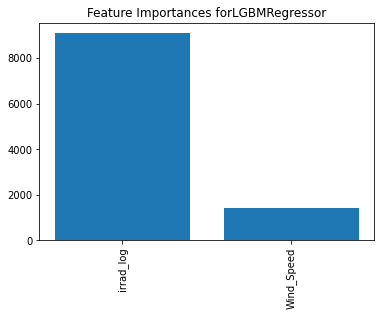

In [ ]:
plot_feat_imp(X_traine, best_lgbm_e)

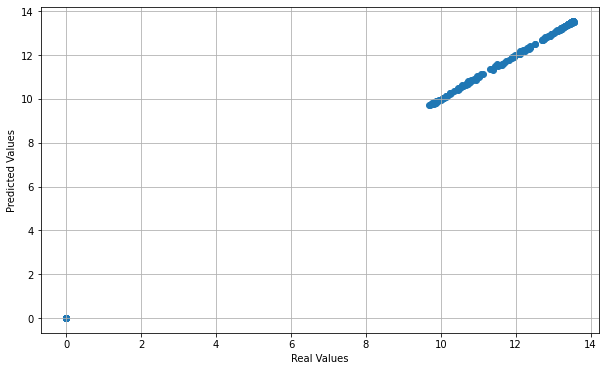

In [ ]:
plot_real_pred(X_teste, y_teste, best_lgbm_e)

### 2. XGB Regressor

In [ ]:
xgb_params_e = {'n_estimators':[1000, 1200], 'booster':['gbtree'], 'max_depth':[4, 5], 
              'max_leaves':[0], 'colsample_bynode': [1],
               'learning_rate':[0.01,0.05,0.06], 'reg_lambda':[0], 'gamma':[0], 'reg_alpha':[0],
               'colsample_bytree': [1]}

In [ ]:
grid_xgb_e = GridSearchCV(XGBRegressor(random_state =model_seed), param_grid = xgb_params_e, scoring= 'neg_root_mean_squared_error', cv= 4, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_xgb_e.fit(X_traine, y_traine)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Wall time: 11.9 s


GridSearchCV(cv=4,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=42, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'colsample_bynode': [1],
                         'colsample_bytree': [1

In [ ]:
grid_xgb_e.best_params_ 

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 1000,
 'reg_alpha': 0,
 'reg_lambda': 0}

In [ ]:
grid_xgb_e.best_score_

-0.029882937345635113

### Tuning History

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 800,
 'reg_alpha': 0,
 'reg_lambda': 0}

-0.029882937472050383

{'booster': 'gbtree',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.08,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 600,
 'reg_alpha': 0,
 'reg_lambda': 0}

-0.03058499139479354

{'booster': 'dart',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.05,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 2000,
 'reg_alpha': 0,
 'reg_lambda': 0}

-0.029883656245360234

{'booster': 'dart',
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.03,
 'max_depth': 4,
 'max_leaves': 0,
 'n_estimators': 2000,
 'reg_alpha': 0,
 'reg_lambda': 0}
 
-0.0299683327936906

### Getting Final results

In [ ]:
best_xgb_e = grid_xgb_e.best_estimator_

In [ ]:
xgb_mape= {'Untuned model':XGBRegressor(), 'Tuned': best_xgb_e}

In [ ]:
compare_tuned(xgb_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.01  0.029  0.015  1.0  1.240724e+12  0.473066
1  Untuned model      0.0  0.036  0.018  1.0  1.501181e+12  0.590959

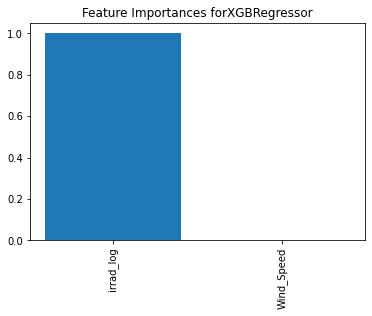

In [ ]:
plot_feat_imp(X_traine, best_xgb_e)

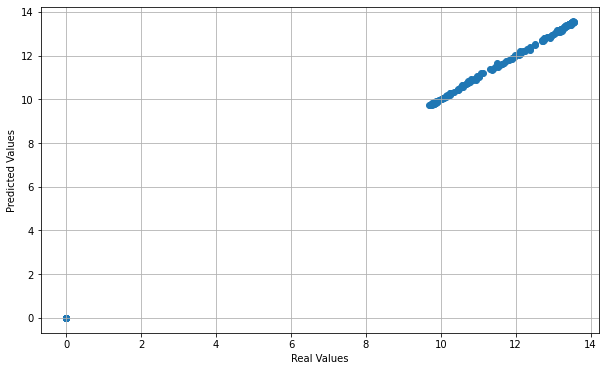

In [ ]:
plot_real_pred(X_teste, y_teste, best_xgb_e)

## 3. Random Forest Regressor

In [ ]:
rf_params_e = {'n_estimators':[300,600], 'max_depth':[None], 'min_samples_split': [2, 3],
             'min_samples_leaf': [1, 2], 'max_leaf_nodes':[None]}

In [ ]:
grid_rf_e = GridSearchCV(RandomForestRegressor(random_state=model_seed), param_grid = rf_params_e, scoring= 'neg_root_mean_squared_error', cv= 4,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_rf_e.fit(X_traine, y_traine)

Fitting 4 folds for each of 8 candidates, totalling 32 fits
Wall time: 18.5 s


GridSearchCV(cv=4, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_leaf_nodes': [None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [300, 600]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_rf_e.best_params_

{'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [ ]:
grid_rf_e.best_score_

-0.1153784572102072

### Tuning History

{'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

-0.1153784572102072

{'max_depth': None,
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 700}

-0.11723652477574889

### Getting Final results

In [ ]:
best_rf_e = grid_rf_e.best_estimator_

In [ ]:
rf_mape = {'Untuned model':RandomForestRegressor(), 'Tuned': best_rf_e}

In [ ]:
compare_tuned(rf_mape, X_traine, X_teste, y_traine, y_teste)

model run_time  rmse    mae   r2   mape     RRMSE
0  Untuned model     0.01  0.04  0.020  1.0  0.002  0.669749
1          Tuned     0.03  0.04  0.019  1.0  0.002  0.661576

There's no visible improvement with Random Forest

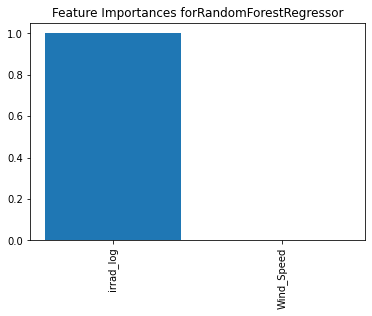

In [ ]:
plot_feat_imp(X_traine, best_rf_e)

## 4.Bagging Regressor

In [ ]:
bag_params_e = {'n_estimators':[190,200],'max_samples':[0.8, 0.9, 1],
               'warm_start': [False], 'max_features':[1,2]}

In [ ]:
grid_bag_e = GridSearchCV(BaggingRegressor(random_state =model_seed), param_grid = bag_params_e,
                         scoring= 'neg_root_mean_squared_error', cv= 4,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_bag_e.fit(X_traine, y_traine)

Fitting 4 folds for each of 12 candidates, totalling 48 fits
Wall time: 12.5 s


GridSearchCV(cv=4, estimator=BaggingRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_features': [1, 2], 'max_samples': [0.8, 0.9, 1],
                         'n_estimators': [190, 200], 'warm_start': [False]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_bag_e.best_params_

{'max_features': 2,
 'max_samples': 0.9,
 'n_estimators': 200,
 'warm_start': False}

In [ ]:
grid_bag_e.best_score_

-0.13705937149375036

### Tuning History

### Getting Final results

In [ ]:
best_bag_e = grid_bag_e.best_estimator_

In [ ]:
bag_mape = {'Untuned model':BaggingRegressor(), 'Tuned': best_bag_e}

In [ ]:
compare_tuned(bag_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse   mae   r2   mape     RRMSE
0  Untuned model      0.0  0.040  0.02  1.0  0.002  0.661993
1          Tuned     0.01  0.042  0.02  1.0  0.002  0.688439

There's no much improvement with bagging regressor

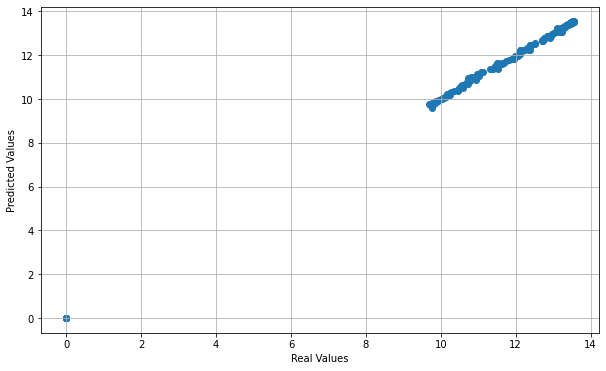

In [ ]:
plot_real_pred(X_teste, y_teste, best_bag_e)

## 5. Gradient Boosting Regressor

In [ ]:
grad_params_e = {'n_estimators':[3000], 'criterion':['squared_error'], 'min_samples_split':[2], 
              'min_samples_leaf':[2], 'max_depth': [3,4], 'max_leaf_nodes': [None],
               'learning_rate':[0.07]}

In [ ]:
grid_grad_e = GridSearchCV(GradientBoostingRegressor(random_state = model_seed), param_grid = grad_params_e, 
                          scoring= 'neg_root_mean_squared_error', cv= 5,
                       n_jobs = -1, verbose= 10)

In [ ]:
%%time
grid_grad_e.fit(X_traine, y_traine)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 14.5 s


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'criterion': ['squared_error'],
                         'learning_rate': [0.07], 'max_depth': [3, 4],
                         'max_leaf_nodes': [None], 'min_samples_leaf': [2],
                         'min_samples_split': [2], 'n_estimators': [3000]},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_grad_e.best_params_

{'criterion': 'squared_error',
 'learning_rate': 0.07,
 'max_depth': 4,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 3000}

In [ ]:
grid_grad_e.best_score_ 

-0.029057078126051693

### Tuning History

{'criterion': 'squared_error',
 'learning_rate': 0.07,
 'max_depth': 4,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 2000}

-0.029082164170848655

{'criterion': 'squared_error',
 'learning_rate': 0.05,
 'max_depth': 3,
 'max_leaf_nodes': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 1500}

-0.029612643004875656

### Getting Final results

In [ ]:
best_grad_e = grid_grad_e.best_estimator_

In [ ]:
grad_mape = {'Untuned model':GradientBoostingRegressor(), 'Tuned': best_grad_e}

In [ ]:
compare_tuned(grad_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse    mae   r2          mape     RRMSE
0          Tuned     0.06  0.027  0.014  1.0  1.569831e+12  0.448108
1  Untuned model      0.0  0.043  0.022  1.0  2.113886e+12  0.713567

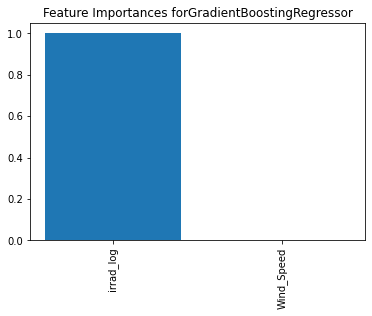

In [ ]:
plot_feat_imp(X_traine, best_grad_e)

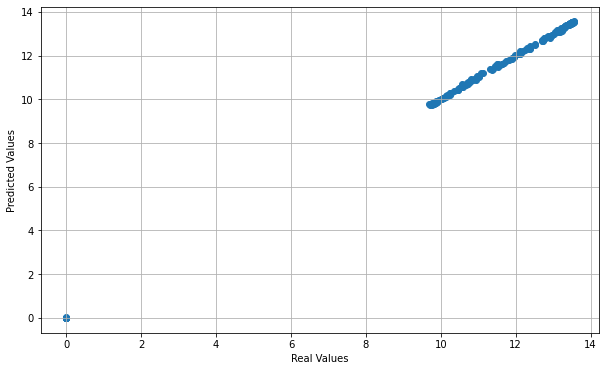

In [ ]:
plot_real_pred(X_teste, y_teste, best_grad_e)

## 6. Support Vector Machine

In [ ]:
x_train_scaledm, x_test_scaledm = scale_datasets(X_train1[['irrad_log', 'Wind_Speed']], X_test1[['irrad_log', 'Wind_Speed']]
                                                 , kind ='min')
x_train_scaled_e, x_test_scaled_e = scale_datasets(X_train1[['irrad_log', 'Wind_Speed']], X_test1[['irrad_log', 'Wind_Speed']])

### MinMax scaler performed better than Standard Scaler for SVM

In [ ]:
svr_params_e = {'kernel':['rbf'], 'degree':[1], 'C':[5000, 7000, 10000], 
                'gamma':[7, 10, 15]} 
              

In [ ]:
grid_svr_e = GridSearchCV(SVR(), param_grid = svr_params_e, scoring= 'neg_root_mean_squared_error', cv= 5, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_svr_e.fit(X_traine, y_traine)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Wall time: 27.6 s


GridSearchCV(cv=5, estimator=SVR(), n_jobs=-1,
             param_grid={'C': [5000, 7000, 10000], 'degree': [1],
                         'gamma': [7, 10, 15], 'kernel': ['rbf']},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_svr_e.best_params_ 

{'C': 7000, 'degree': 1, 'gamma': 15, 'kernel': 'rbf'}

In [ ]:
grid_svr_e.best_score_

-0.5173812039651161

#### Tuning History

{'C': 5000, 'degree': 1, 'gamma': 15, 'kernel': 'rbf'}

-0.5240788583595232

{'C': 2000, 'degree': 1, 'gamma': 10, 'kernel': 'rbf'}

-0.5435537263935626

{'C': 1500, 'degree': 1, 'gamma': 20, 'kernel': 'rbf'}

-0.5476583102447977

{'C': 120, 'degree': 1, 'gamma': 30, 'kernel': 'rbf'}

-0.5912933693634681

{'C': 100, 'degree': 1, 'gamma': 100, 'kernel': 'rbf'}

-0.6507738704020458

### Getting Final results

In [ ]:
best_svr_e = grid_svr_e.best_estimator_

In [ ]:
svr_mape = {'Untuned model':SVR(), 'Tuned': best_svr_e}

In [ ]:
compare_tuned(svr_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse    mae     r2          mape      RRMSE
0          Tuned     0.02  0.197  0.084  0.999  1.318912e+14   3.266015
1  Untuned model      0.0  0.877  0.215  0.979  1.321252e+14  14.506658

We notice good improvement

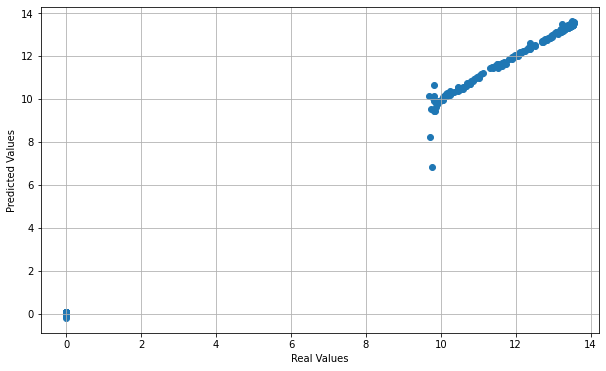

In [ ]:
plot_real_pred(x_test_scaledm, y_teste, best_svr_e)

# 7. KNN Regressor

In [ ]:
knn = KNeighborsRegressor()

In [ ]:
# Using only irrad_log on KNN
knn.fit(x_train_scaledm[['irrad_log']], y_traine)

KNeighborsRegressor()

In [ ]:
np.sqrt(mean_squared_error(y_teste, knn.predict(x_test_scaledm[['irrad_log']])))

0.07012222476291197

In [ ]:
knn_params_e = {'n_neighbors':[1,2,3,4,5,6,7,8,9,10], 'weights':['uniform', 'distance'], 'p':[4,5,6,7,8,9], 
             'metric': ['euclidean', 'manhattan', 'minkowski']} 
              

In [ ]:
grid_knn_e = GridSearchCV(KNeighborsRegressor(), param_grid = knn_params_e, scoring= 'neg_root_mean_squared_error', cv= 4, n_jobs = -1, 
                       verbose= 10)

In [ ]:
%%time
grid_knn_e.fit(X_traine, y_traine)

Fitting 4 folds for each of 360 candidates, totalling 1440 fits
Wall time: 10.9 s


GridSearchCV(cv=4, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan', 'minkowski'],
                         'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'p': [4, 5, 6, 7, 8, 9],
                         'weights': ['uniform', 'distance']},
             scoring='neg_root_mean_squared_error', verbose=10)

In [ ]:
grid_knn_e.best_params_ 

{'metric': 'minkowski', 'n_neighbors': 1, 'p': 6, 'weights': 'uniform'}

In [ ]:
grid_knn_e.best_score_

-0.6591885808254776

### Getting Final results

In [ ]:
best_knn_e = grid_knn_e.best_estimator_

In [ ]:
knn_mape = {'Untuned model':KNeighborsRegressor(), 'Tuned': best_knn_e}

In [ ]:
compare_tuned(knn_mape, X_traine, X_teste, y_traine, y_teste)

model run_time   rmse    mae     r2          mape     RRMSE
0          Tuned      0.0  0.104  0.048  1.000  4.000000e-03  1.720256
1  Untuned model      0.0  0.528  0.084  0.992  2.395957e+13  8.730886

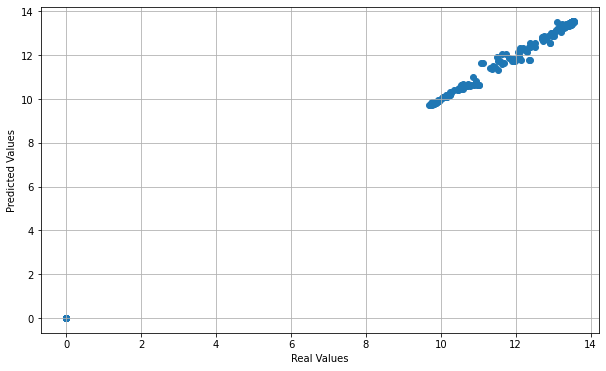

In [ ]:
plot_real_pred(X_teste, y_teste, best_knn_e)

# Why KNN performs poorly using the wind and ambient temp features with solar Irrad as compared to Irradiance alone
The efficiency value was binned into lowest, lower...peak above. See [EDA section](#sect) above for the plot.

First of all the difference between efficiency values in the lowest(mostly 0s) and lower region is much. So if just one point that should be in the lowest category gets into the lower category the error will be raised.

When irradiance values are slightly >0, we notice that there's efficiency, but now if we have a point really close to 0 like we actually do, we notice that considering the nearest neighbour using temperature or ambient temp on 2d plane, we'd have cases where points close to 0 will have nearest neighbours closer to the lowest region instead of them being in the lower region

**On training using only Irrad log**
- untuned KNN - rmse = 0.07

**with other features**
- untuned KNN - rmse = 0.528

# 8. Artificial Neural Network (ANN)

In [ ]:
def model_builder(hp):
  model = keras.Sequential()
  tf.keras.Input(shape=(2,))

  
  for i in range(hp.Int('layer', 2, 15)):
    model.add(Dense(hp.Int('units_'+ str(i), min_value=32, max_value=512, step=32), kernel_initializer='normal',
                    activation='relu'))  

  hp_learning_rate = hp.Choice('learning_rate', values=[0.0001, 0.001, 0.003, 0.005])
  
  model.add(Dense(1, kernel_initializer='normal', activation='linear'))
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['mse'])

  return model

In [ ]:
# max trials just says how many combination of hyperparameters should I try, them executions say for each combination, how
# many times should I train on that ? Because for NNs we get different results for the same model

tuner = kt.RandomSearch(model_builder,
                     objective=kt.Objective("val_mse", direction="min"),
                     max_trials=50,
                     executions_per_trial=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
tuner.search(x_train_scaled.values, y_traine.values, epochs=50, validation_split=0.2, callbacks=[stop_early],
             batch_size =64)

# Getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


In [ ]:
tuner.results_summary()

In [ ]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# Building the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train_scaled, y_traine, epochs=60, validation_split=0.2, batch_size =32)

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retraining the model
hypermodel.fit(x_train_scaled, y_traine, epochs=best_epoch, validation_split=0.2, batch_size = 32)

In [ ]:
eval_result = hypermodel.evaluate(x_test_scaled, y_teste)
print("[test loss, test mse]:", eval_result)

In [ ]:
hypermodel.summary()

In [ ]:
#hypermodel.save('best_efficiency.h5')

In [ ]:
tf.random.set_seed(20)

load_mod_e = tf.keras.models.load_model('Saved_Neural_Nets/best_efficiency.h5')
#load_mod_e.fit(x_train_scaled, y_traine, epochs=3, batch_size= 64)

In [ ]:
#np.sqrt(mean_squared_error(y_teste, load_mod_e.predict(x_test_scaled)))

<a name = 'summary_eff'></a>
## 20. Summary and Conclusions

In [ ]:
# best models map
best_regressors_e = {
    'LGBM': best_lgbm_e,
    'XGB':best_xgb_e,
    'RandomForest': best_rf_e,
    'GradientBoosting':best_grad_e,
    'Bagging': best_bag_e,
    'SVR': best_svr_e,
    'KNN': best_knn_e,
    'ANN': load_mod_e
}

In [ ]:
def visualize_pred(X_train, X_test, y_train, y_test, train_pr, test_pr, model):
    plt.figure(figsize = (12,8))
    plt.plot(X_train.Date, y_train, color = 'b', label = 'Real')
    plt.plot(X_train.Date, train_pr, color = 'r', label = model)
    plt.text(pd.to_datetime('04/25/2019'),13, 'Training Data', fontsize = 13)
    plt.text(pd.to_datetime('04/25/2021'),13, 'Testing Data', fontsize = 13)


    plt.plot(X_test.Date, y_test, color = 'b')
    plt.plot(X_test.Date, test_pr, color = 'r')
    plt.axvline(X_test.Date.min(), color= 'k', ls = '--')
    plt.xlabel('Date', fontsize = 14)
    plt.ylabel('Efficiency (%)', fontsize = 14)
    
    plt.legend()
    #plt.savefig('EFF_pred'+model+'.jpg', dpi = 300)
    plt.show()
    

In [ ]:
def total_report(model_map, X_traindate, X_testdate, X_train, X_test, X_trainsc, X_testsc, y_train, y_test ):
    df_models = pd.DataFrame(columns=['model', 'MSE', 'RMSE', 'MAE', 'r2', 'mape', 'RRMSE', 'Error'])

    for a, key in enumerate(model_map):

        start_time = time.time()
        
        if key == 'ANN':
            regressor = model_map[key]
            #X_trainsc, X_testsc = scale_datasets(X_train, X_test)
            #tf.random.set_seed(200)
            start_time = time.time()
            regressor.fit(X_trainsc, y_train, epochs=3, batch_size= 64)
            end_time = time.time()
            y_pred_tr = regressor.predict(X_trainsc)
            start_time_pr = time.time()
            y_pred_te = regressor.predict(X_testsc)
            end_time_pr = time.time()
        else:
            regressor = model_map[key]
            start_time = time.time()
            regressor.fit(X_train, y_train)
            end_time = time.time()
            y_pred_tr = regressor.predict(X_train)
            start_time_pr = time.time()
            y_pred_te = regressor.predict(X_test)
            end_time_pr = time.time()
        # metrics
        train_time = end_time - start_time
        pr_time = end_time_pr - start_time_pr
        #print(pr_time, train_time)
        #tr_te = ['train', 'test']
        rmse = [np.sqrt(mean_squared_error(y_train, y_pred_tr)),  np.sqrt(mean_squared_error(y_test, y_pred_te))] 
        mse = [mean_squared_error(y_train, y_pred_tr), mean_squared_error(y_test, y_pred_te)]
        mae = [mean_absolute_error(y_train, y_pred_tr), mean_absolute_error(y_test, y_pred_te)]
        r2 = [r2_score(y_train, y_pred_tr), r2_score(y_test, y_pred_te)]
        mape = [mean_absolute_percentage_error(y_train, y_pred_tr), mean_absolute_percentage_error(y_test, y_pred_te)]
        rrmse = [np.sqrt((mean_squared_error(y_train, y_pred_tr)/mean_squared_error(y_train, 
                                                                                    [np.mean(y_train)]*len(y_train))))*100,
                 np.sqrt((mean_squared_error(y_test, y_pred_te)/mean_squared_error(y_test, [np.mean(y_test)]*len(y_test))))*100]

        
        row_tr = {'model': key,
           'Time_trte': train_time,
            'MSE':mse[0],
           'RMSE': rmse[0],
            'MAE':mae[0],
            'r2': r2[0],
            'mape': mape[0] ,
            'RRMSE': rrmse[0],
            'Error': 'Train',
            'Time': 'Training'
        }
                      
        row_te = {'model': key,
           'Time_trte': pr_time,
            'MSE':mse[1],
           'RMSE': rmse[1],
            'MAE':mae[1],
            'r2': r2[1],
            'mape': mape[1] ,
            'RRMSE': rrmse[1],
            'Error': 'Test',
             'Time': 'Testing'
        }
        visualize_pred(X_traindate, X_testdate, y_train, y_test, y_pred_tr, y_pred_te, key)
        df_models = df_models.append(row_tr, ignore_index=True)
        df_models = df_models.append(row_te, ignore_index=True)
                                                                    
    # dispaying the top 5 models wrt rmse
    sorted_df = df_models.sort_values(['RMSE'], ascending = False).iloc[:,:].reset_index(drop = True)
    sorted_df = round(sorted_df, 3)
    display(sorted_df)
    display_metrics = ['MSE', 'RMSE', 'MAE', 'RRMSE', 'Time_trte']
    for metric in display_metrics:
        if metric == 'Time_trte':
            palette = {'Training':'red', 'Testing':'green'}
            sorted_df = df_models.sort_values(['Time_trte', 'Time'], ascending = False).iloc[:,:].reset_index(drop = True)
            sorted_df = round(sorted_df, 3)
            plt.figure(figsize = (12,8))
            ax0 = sns.barplot(x= 'model', y=metric, data= sorted_df, hue= 'Time', palette= palette ) 
            plt.ylabel('Time (s)', fontsize = 13)
            plt.xlabel('Model', fontsize = 13)
            plt.title('Training and Testing Time for Eight Supervised Learning Models', fontsize = 15)
            for container in ax0.containers:
                ax0.bar_label(container)
            #plt.savefig('metric'+metric+'.jpg', dpi = 300)
            plt.show()
        else:
            #palette = {'Train':'orange', 'Test':'blue'}
            plt.figure(figsize = (12,8))
            ax0 = sns.barplot(x= 'model', y=metric, data= sorted_df, hue= 'Error', hue_order= ['Test', 'Train'])  
            plt.ylabel(metric, fontsize = 13)
            plt.xlabel('Model', fontsize = 13)
            plt.title(metric + ' for Eight Supervised Learning Models', fontsize = 15)
            for container in ax0.containers:
                ax0.bar_label(container)
            #plt.savefig('Eff_metric'+metric+'.jpg', dpi = 300)
            plt.show()
                                                               

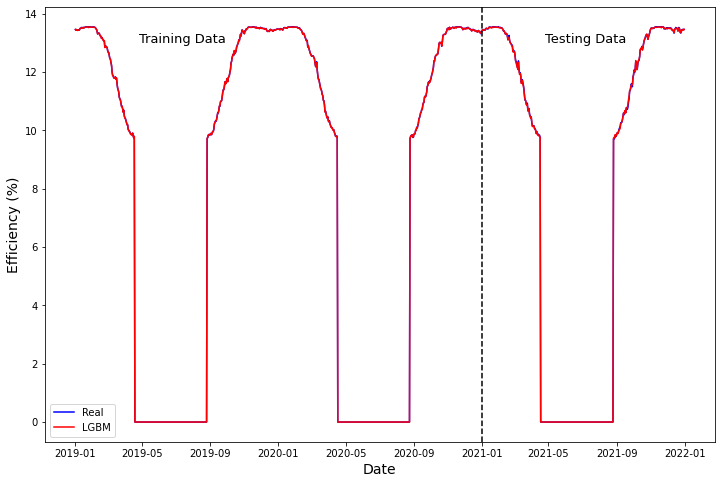

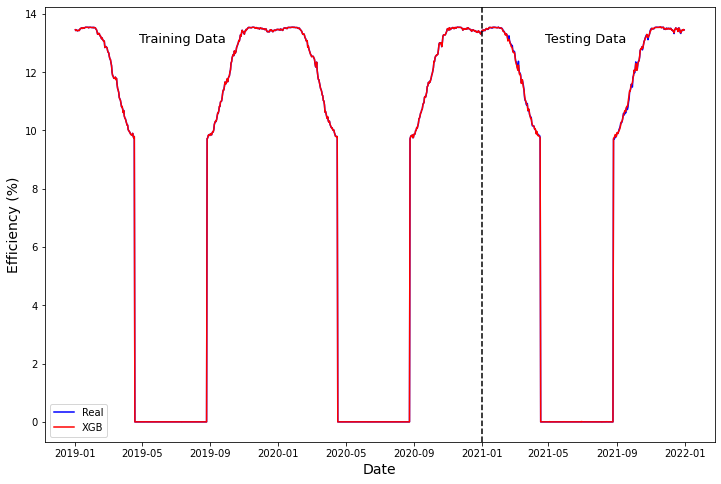

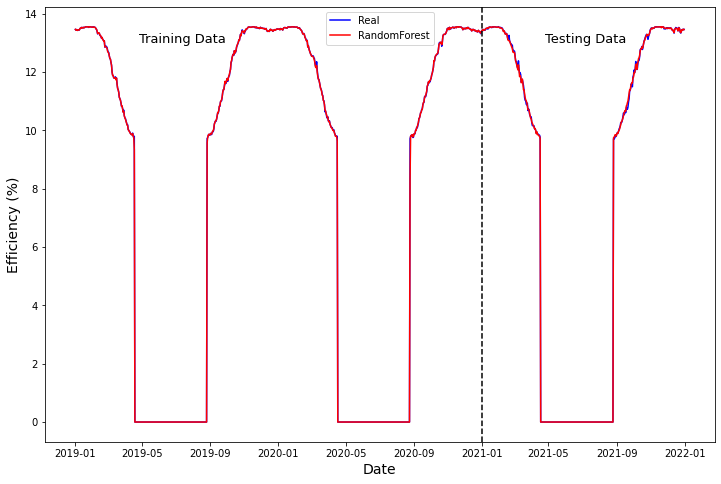

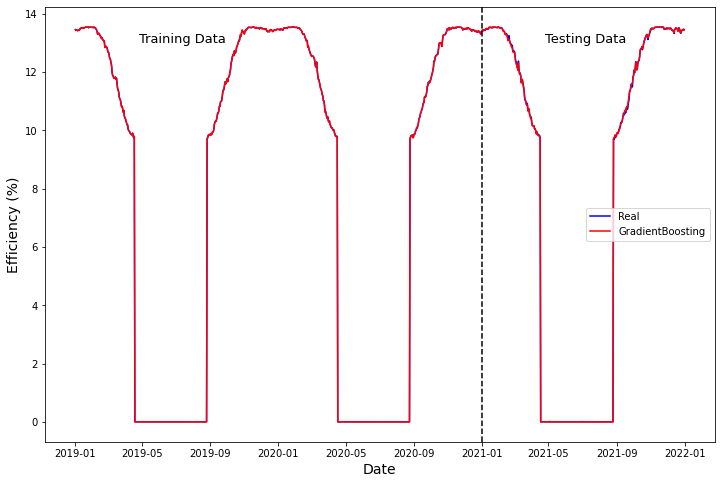

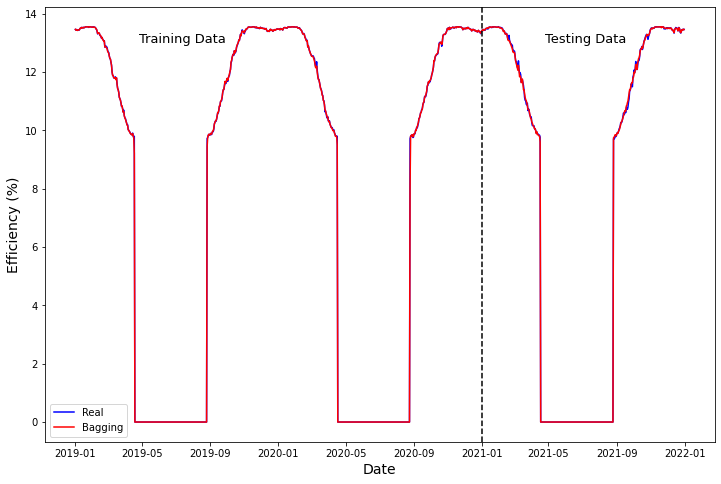

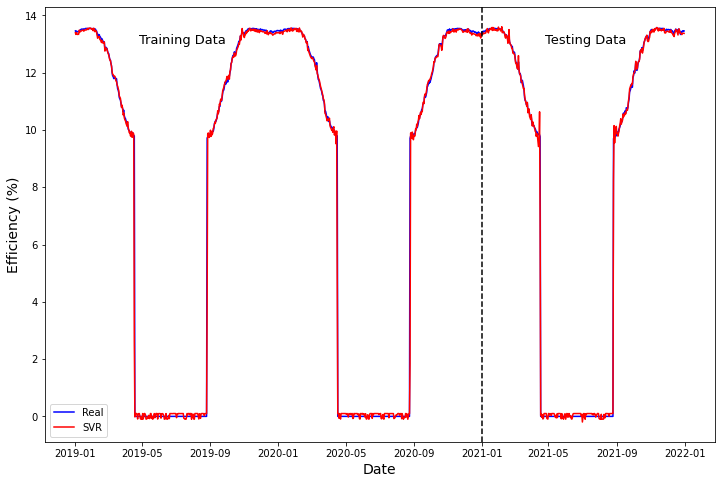

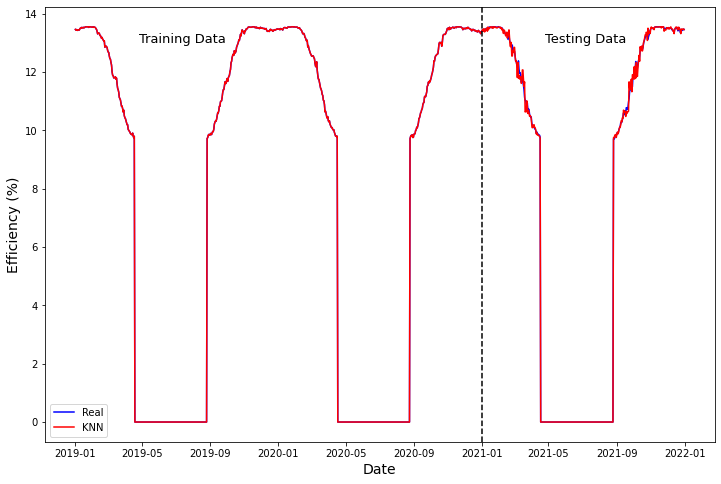

Epoch 1/3
12/12 [==============================] - 0s 12ms/step - loss: 0.5377 - mean_squared_error: 0.5377
Epoch 2/3
12/12 [==============================] - 0s 10ms/step - loss: 0.5376 - mean_squared_error: 0.5376
Epoch 3/3
12/12 [==============================] - 0s 10ms/step - loss: 0.5345 - mean_squared_error: 0.5345


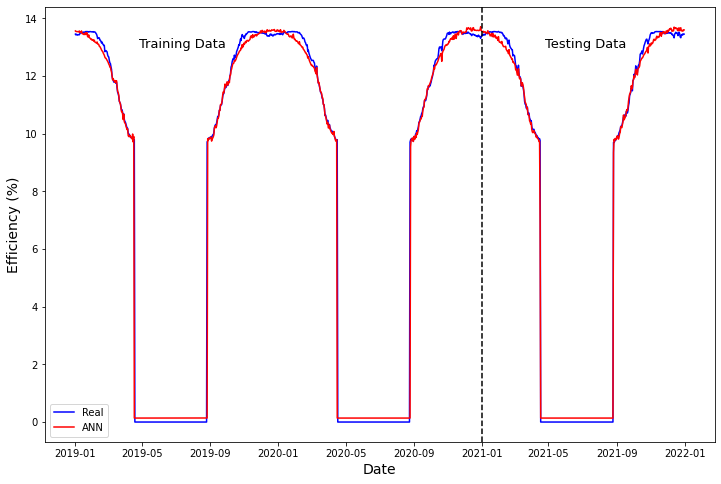

model    MSE   RMSE    MAE     r2          mape   RRMSE  Error  \
0                ANN  0.532  0.729  0.188  0.985  2.204662e+14  12.092  Train   
1                SVR  0.239  0.488  0.102  0.993  1.312887e+14   8.098  Train   
2                ANN  0.052  0.228  0.152  0.999  2.224665e+14   3.776   Test   
3                SVR  0.039  0.197  0.084  0.999  1.318912e+14   3.266   Test   
4                KNN  0.011  0.104  0.048  1.000  4.000000e-03   1.720   Test   
5            Bagging  0.005  0.069  0.010  1.000  1.000000e-03   1.150  Train   
6       RandomForest  0.003  0.057  0.009  1.000  1.000000e-03   0.945  Train   
7            Bagging  0.002  0.042  0.020  1.000  2.000000e-03   0.688   Test   
8       RandomForest  0.002  0.040  0.019  1.000  2.000000e-03   0.662   Test   
9                XGB  0.001  0.029  0.015  1.000  1.240724e+12   0.473   Test   
10  GradientBoosting  0.001  0.027  0.014  1.000  1.569831e+12   0.448   Test   
11              LGBM  0.000  0.021  0.012  1.000  3.474306e+10   0.351   Test   
12              LGBM  0.000  0.006  0.004  1.000  3.443068e+10   0.107  Train   
13               XGB  0.000  0.003  0.002  1.000  5.036580e+11   0.047  Train   
14  GradientBoosting  0.000  0.000  0.000  1.000  3.743230e+11   0.005  Train   
15               KNN  0.000  0.000  0.000  1.000  0.000000e+00   0.000  Train   

        Time  Time_trte  
0   Training      1.001  
1   Training      0.960  
2    Testing      0.094  
3    Testing      0.007  
4    Testing      0.006  
5   Training      0.728  
6   Training      1.610  
7    Testing      0.030  
8    Testing      0.171  
9    Testing      0.008  
10   Testing      0.031  
11   Testing      0.047  
12  Training      3.981  
13  Training      0.778  
14  Training      2.917  
15  Training      0.006

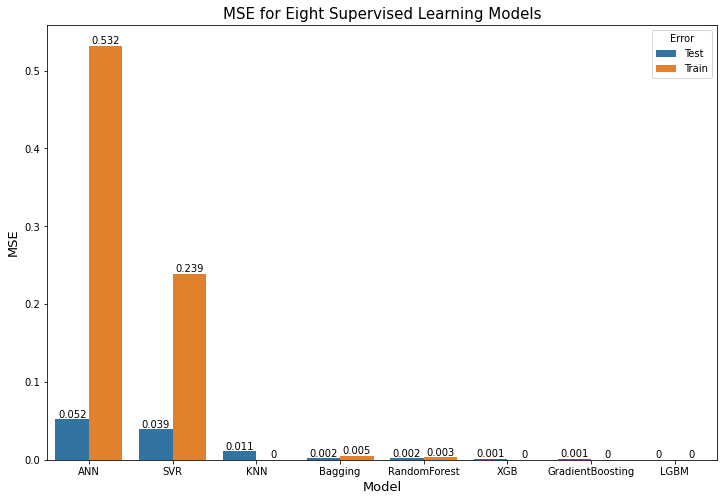

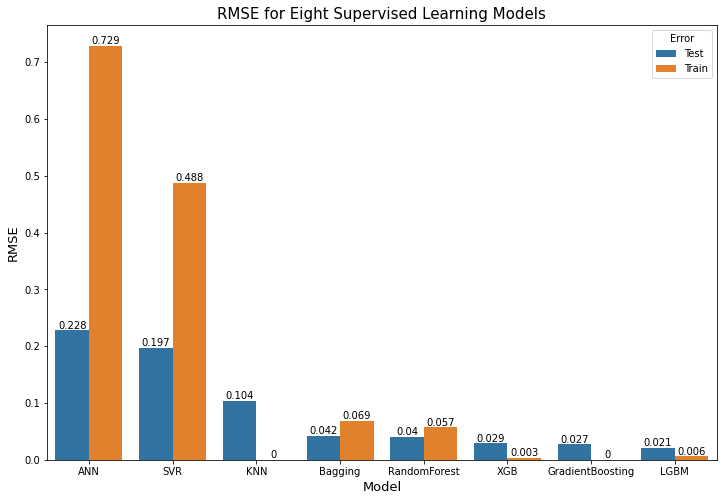

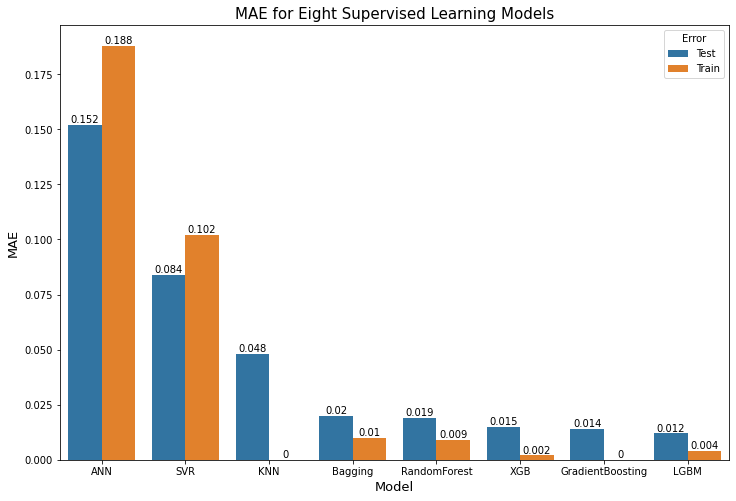

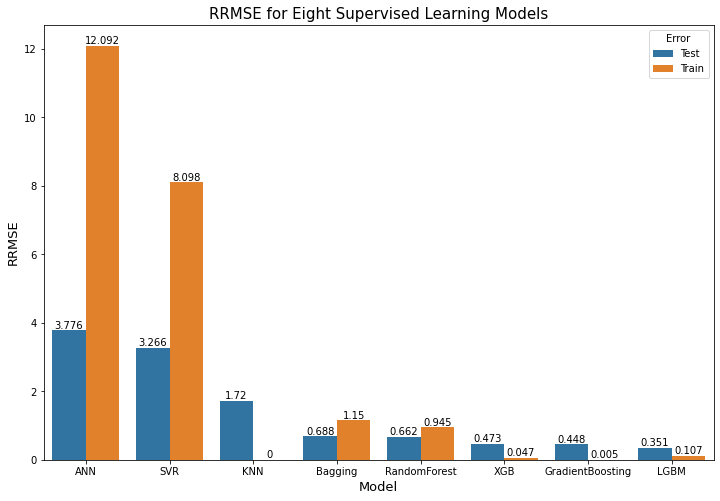

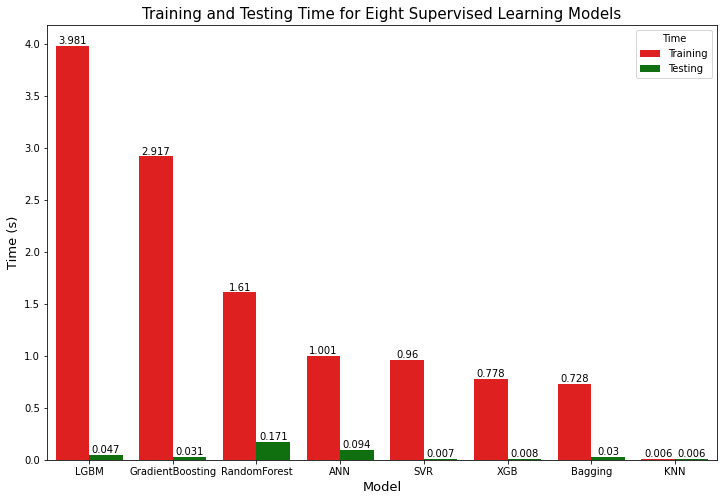

In [ ]:
total_report(best_regressors_e, X_train1, X_test1, X_traine, X_teste, x_train_scaled_e, x_test_scaled_e, y_traine, y_teste)

In [ ]:
def train_test(model, x_train, x_test):
    pred_train, pred_test = model.predict(x_train), model.predict(x_test)
    return pred_train, pred_test

In [ ]:
def all_together(model_map_pow, model_map_eff, X_train, X_test, x_train, x_test, x_traine, x_teste,
                 X_trainsc, X_testsc, X_trainsce, X_testsce, y_train_pow, y_test_pow, y_train_eff, y_test_eff):
    '''Plots real and predicted values of both Efficiency and Power on the same plot'''
    
    for key_pow, key_eff in zip(model_map_pow, model_map_eff):        
        if key_pow == 'ANN':
            regressor_pow = model_map_pow[key_pow]
            regressor_eff = model_map_eff[key_eff]
            regressor_pow.fit(X_trainsc, y_train_pow, epochs=50, batch_size= 32) 
            regressor_eff.fit(X_trainsce, y_train_eff, epochs=3, batch_size= 64)
            y_pred_tr_pow, y_pred_te_pow = train_test(regressor_pow, X_trainsc, X_testsc)
            y_pred_tr_eff, y_pred_te_eff = train_test(regressor_eff, X_trainsce, X_testsce)
        else:
            regressor_pow = model_map_pow[key_pow]
            regressor_eff = model_map_eff[key_eff]
            regressor_pow.fit(x_train, y_train_pow) 
            regressor_eff.fit(x_traine, y_train_eff)
            y_pred_tr_pow, y_pred_te_pow = train_test(regressor_pow, x_train, x_test)
            y_pred_tr_eff, y_pred_te_eff = train_test(regressor_eff, x_traine, x_teste)
            
    # Plotting real and predicted power and efficiency on the same axis
        fig, ax = plt.subplots(figsize = (12,8))
        ax1 = ax.twinx()

        ax.scatter(X_train.Date, y_pred_tr_pow, color= 'r', marker = '^', s= 45, label = key_pow+' (W)')
        ax.plot(X_train.Date, y_train_pow, color= 'r', label = 'Power (W)')
        ax.scatter(X_test.Date, y_pred_te_pow, color= 'r', marker = '^', s= 45)
        ax.plot(X_test.Date, y_test_pow, color= 'r')

        ax1.scatter(X_train.Date, y_pred_tr_eff, color = 'b', marker = '.', s= 45, label = key_pow+' (%)')
        ax1.plot(X_train.Date, y_train_eff, color = 'b', label = 'Efficiency (%)')
        ax1.scatter(X_test.Date, y_pred_te_eff, color = 'b', marker = '.', s= 45)
        ax1.plot(X_test.Date, y_test_eff, color = 'b')

        ax.set_xlabel('Date', fontsize = 13)
        ax.set_ylabel('Power (W)', fontsize = 13,color = 'r')
        ax.tick_params(axis='y', labelcolor = 'r')

        ax1.set_ylabel('Efficiency (%)', fontsize = 13, color = 'b')
        ax1.tick_params(axis='y', labelcolor = 'b')

        # Setting position of legend
        fig.legend(loc= (0.44, 0.42))
        #fig.legend(loc= 'upper center', bbox_to_anchor=(0.5, 0., 0.5, 0.5))
        
        plt.text(pd.to_datetime('04/25/2019'),13, 'Training Data', fontsize = 13)
        plt.text(pd.to_datetime('04/25/2021'),13, 'Testing Data', fontsize = 13)
        plt.axvline(X_test.Date.min(), color= 'k', ls = '--')
        plt.grid()

        # Giving plot a title
        plt.title('Real and Predicted Power and Efficiency of Panels Overtime in Antarctica', fontsize = 14)
        plt.savefig('power_and_efficiency'+key_pow+'.jpg', dpi = 300)

Epoch 1/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0632 - mean_squared_error: 0.0632
Epoch 2/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0784 - mean_squared_error: 0.0784
Epoch 3/50
23/23 [==============================] - 0s 6ms/step - loss: 0.0302 - mean_squared_error: 0.0302
Epoch 4/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0125 - mean_squared_error: 0.0125
Epoch 5/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0073 - mean_squared_error: 0.0073
Epoch 6/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0050 - mean_squared_error: 0.0050
Epoch 7/50
23/23 [==============================] - 0s 5ms/step - loss: 0.0152 - mean_squared_error: 0.0152
Epoch 8/50
23/23 [==============================] - 0s 5ms/step - loss: 1.0033 - mean_squared_error: 1.0033
Epoch 9/50
23/23 [==============================] - 0s 5ms/step - loss: 0.3128 - mean_squared_error: 0.3128
Epoch 10/50
23/23 [=========

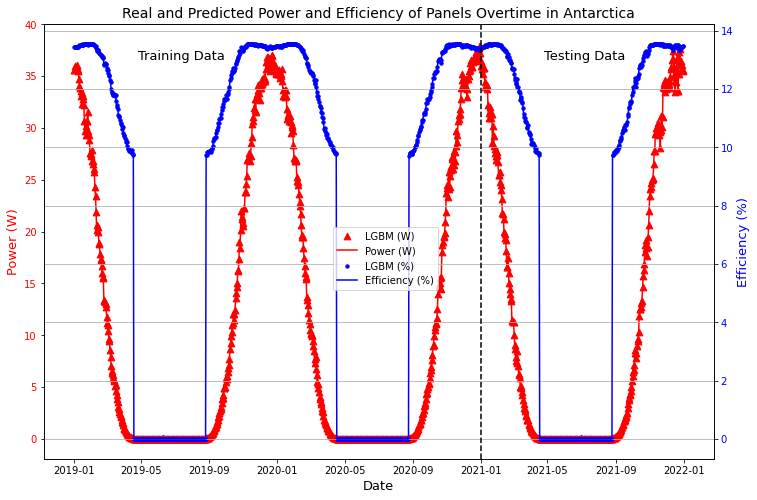

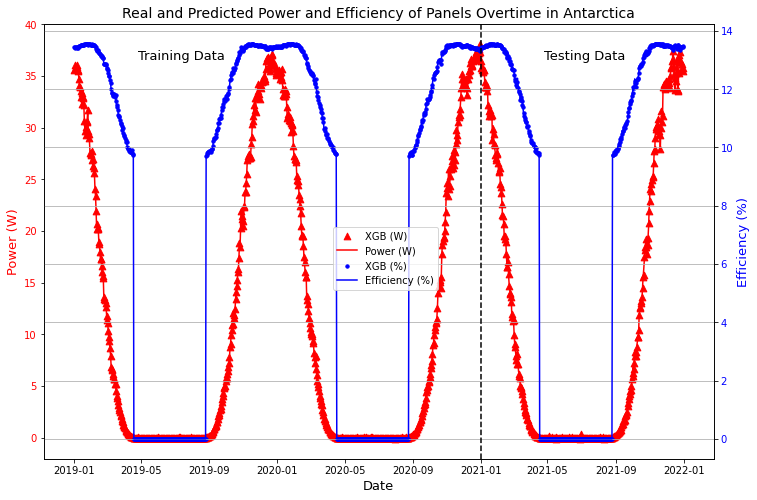

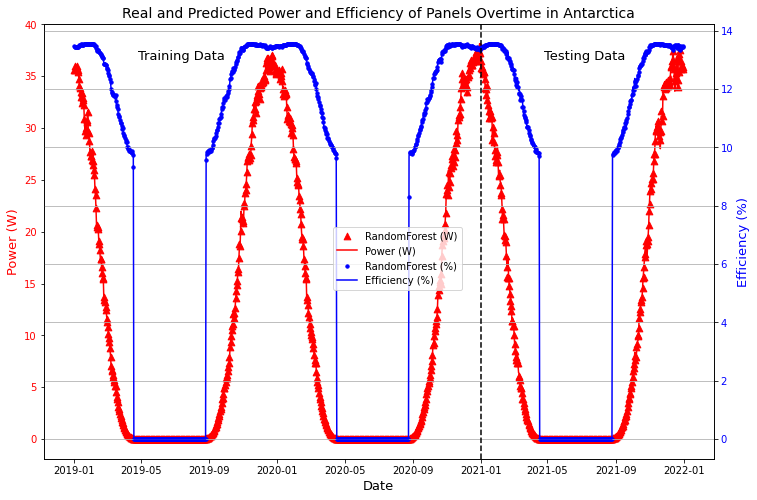

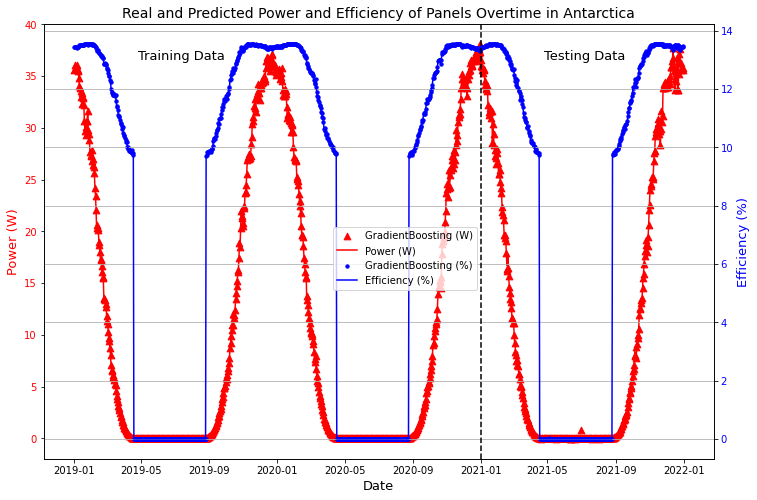

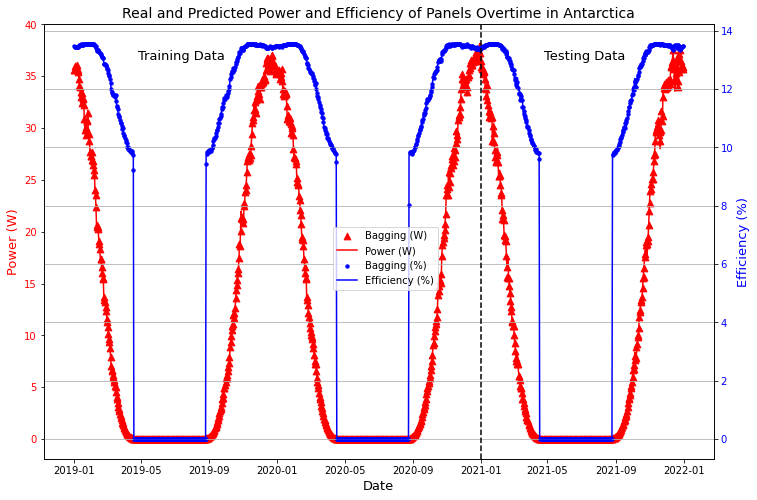

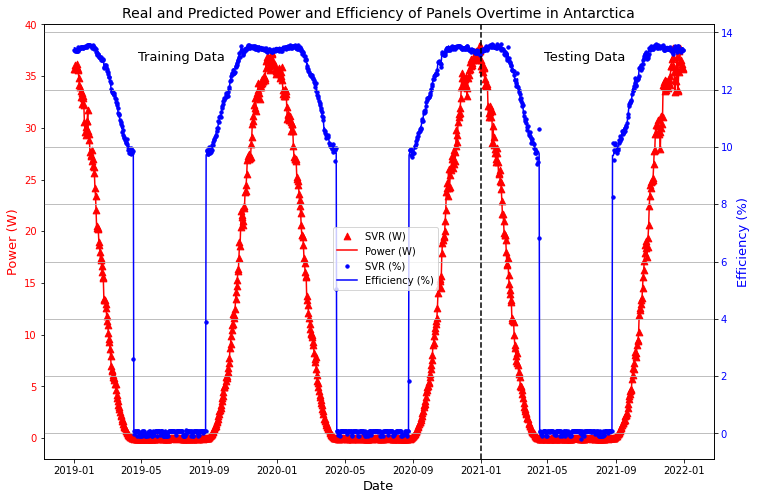

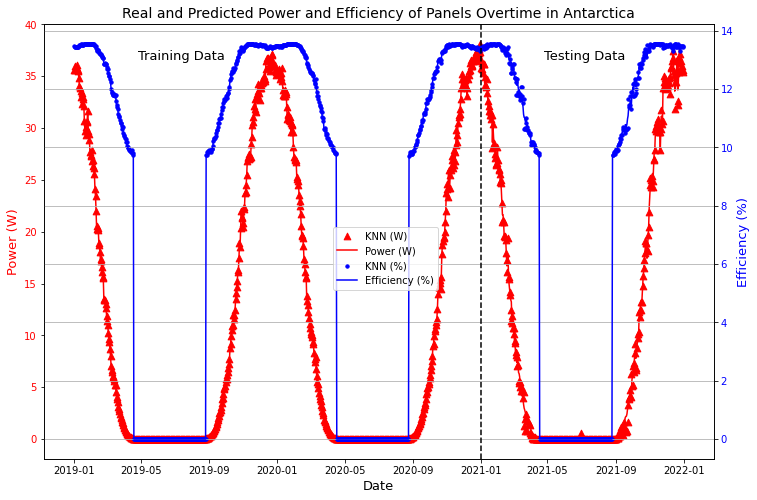

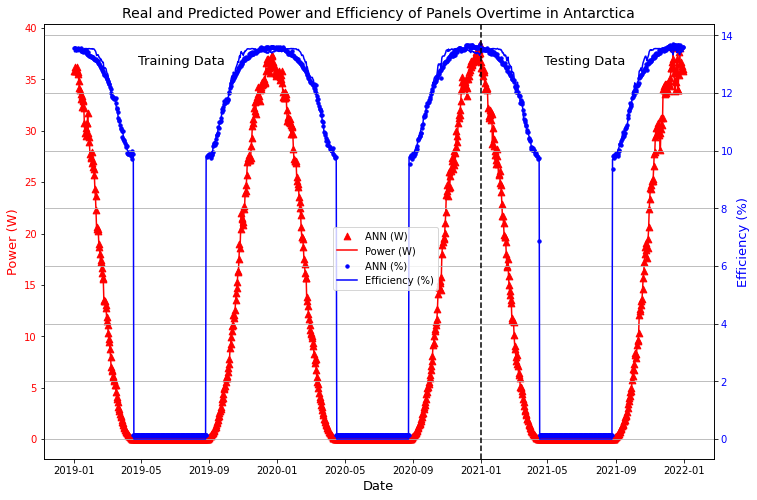

In [ ]:
all_together(best_regressors, best_regressors_e, X_train1, X_test1, X_train, X_test, X_traine, X_teste,
             x_train_scaled, x_test_scaled,x_train_scaled_e, x_test_scaled_e, y_traina, y_testa, y_traine, y_teste)

# Conclusion

Generally tree based models performed better because they are able to handle the skew because they use splits.
1. Light Gradient Boosting Machine (LGBM) Regressor gave the best results with rmse of 0.021, mae of 0.012, r2 score of 1 and RRMSE of 0.352 on the test set.
2. Gradient Boosting Regressor came second with rmse of 0.027, mae of 0.014, r2 score of 1 and RRMSE of 0.448 on the test set. 
3. Looking at the predictions SVR underfitted and performed poorly on both train and test sets.
4. The ANN underfitted on the training set and hence produced poor results on the test set.
5. KNN overfitted on the training set.
5. LGBM had the highest training time of 3.5 seconds on a pc running on intel core I5 @2.4ghz clock speed with a quadcore processor and 16gb of ram.


**The reason for the much higher train error in the ANN and the support vectors seems to be because there's more train data hence more datapoints contributing to the error.**

### Resizing Images

In [ ]:
direc = os.listdir('predict')
for img in direc:
    image = Image.open(img)
    print('Resizing '+img+ '...')
    new_image = image.resize((4667, 3500))
    new_image.save('resized_'+img, dpi = (300, 300))
    print('Completed \n')

Resizing power_and_efficiencyANN.jpg...
Completed 

Resizing power_and_efficiencyBagging.jpg...
Completed 

Resizing power_and_efficiencyGradientBoosting.jpg...
Completed 

Resizing power_and_efficiencyKNN.jpg...
Completed 

Resizing power_and_efficiencyLGBM.jpg...
Completed 

Resizing power_and_efficiencyRandomForest.jpg...
Completed 

Resizing power_and_efficiencySVR.jpg...
Completed 

Resizing power_and_efficiencyXGB.jpg...
Completed 

